In [7]:
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics.pairwise import cosine_distances
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import SpectralEmbedding
from pytorch_model_summary import summary
from sklearn.decomposition import PCA
from scipy.sparse.linalg import eigsh
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
from scipy.special import iv
from typing import Optional
from matplotlib import cm
import scipy.sparse as sp
import networkx as nx  # pakage for handling a graph
import os.path as osp
from tqdm import tqdm
from scipy import io
import pandas as pd
import numpy as np
import cupy as cp
import easydict
import natsort
import random
import copy
import time
import math
import sys
import os

from torch.distributions.categorical import Categorical
from torch.utils.data import random_split
import torch.nn.functional as F
from torch.optim import Adam
import torch.nn as nn
import torch


from torch_geometric.utils import sort_edge_index, degree, add_remaining_self_loops, remove_self_loops, get_laplacian, \
    to_undirected, to_dense_adj, to_networkx
from torch_geometric.nn import GCNConv, SGConv, SAGEConv, GATConv, GraphConv, GINConv
from torch_geometric.transforms import LaplacianLambdaMax
from torch_geometric.utils import degree, to_undirected
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import ChebConv, GCNConv
from torch_geometric.datasets import KarateClub


from torch_scatter import scatter
import torch_sparse

# utils

In [8]:
def get_seed_args():
    args = easydict.EasyDict({
        # arguments for setting device
        'bus_id' : 'PCI_BUS_ID',
        'cuda_id' : ['0','1','2'],
        
        # arguments for path
        'os_path' : './SSLGCN',
        'seed_data_dir_path' : 'dataset/seed/SEED_EEG/ExtractedFeatures/data/',
        'feature_name1' : 'de_LDS',
        'feature_name2' : 'psd_LDS',
        'seed_label_dir_path' : 'dataset/seed/SEED_EEG/ExtractedFeatures/label/',
        'figure_save_path' : './SSLGCN/store/figure/',
        'tensor_save_path' : './SSLGCN/store/tensor/',
        'model_save_path' : './SSLGCN/store/model/',
        
        # arguments for counts
        'n_subjects' : 15,
        'n_sessions' : 3,
        'n_trials' : 15,
        'n_nodes' : 62,
        'n_features' : 5,
        'n_samples' : 10182,
        'n_labels_by_trials1' : 4,
        'n_labels_by_trials2' : 6,
        'n_labels_by_trials3' : 8,

        # arguments for running algorithm
        'seed' : 2023,
        'EEG_band' : None,
        'pca_components1' : 9,
        'pca_components2' : 6,
        'essm_lambda' : 0.9,
        'de_k' : 3394, #721
        'psd_k' : 3394, #1861
        'k1' : 30,
        'k2' : 130,
        't1' : 1,
        't2' : 1,
        'feature_dimension' : 620,
        'gcn_hid_channels' : 64,
        'gcn_out_channels' : 128,
        'out_channels' : 3,
        'learning_rate' : 0.005,
        'l2_lambda' : 0.001,
        'epochs' : 3000,
        'proj_hid_channels' : 32,
        'ptau' : 32,
        'pf1' : 0.1,
        'pf2' : 0.1,
        'pe1' : 0.1,
        'pe2' : 0.1,
        'tpf1' : 0.7,
        'tpf2' : 0.7,
        'tpe1' : 0.7,
        'tpe2' : 0.7,
        'loss_lambda' : 0.01,
        'patience' : 10,
        'val_split' : 0.2
    })
    
    return args

def get_seedIV_args():
    args = easydict.EasyDict({
        # arguments for setting device
        'bus_id' : 'PCI_BUS_ID',
        'cuda_id' : ['0','1','2'],
        
        # arguments for path
        'os_path' : '/home/neuroai/users/dhkim/eer/SSLGCN',
        'feature_name1' : 'de_LDS',
        'feature_name2' : 'psd_LDS',
        'seedIV_data_dir_path' : 'dataset/seed_IV/eeg_feature_smooth/',
        'figure_save_path' : 'store_seedIV/figure/',
        'tensor_save_path' : 'store_seedIV/tensor/',
        'model_save_path' : 'store_seedIV/model/',
        
        # arguments for counts
        'n_subjects' : 15,
        'n_sessions' : 3,
        'n_trials' : 24,
        'n_nodes' : 62,
        'n_features' : 5,
        'n_samples' : 2505,
        'n_labels_by_class1' : 15,
        'n_labels_by_class2' : 20,
        'n_labels_by_class3' : 25,

        # arguments for running algorithm
        'seed' : 2023,
        'EEG_band' : None,
        'pca_components1' : 9,
        'pca_components2' : 6,
        'essm_lambda' : 0.9,
        'de_k' : 626,
        'psd_k' : 626,
        'k1' : 30,
        'k2' : 130,
        't1' : 1,
        't2' : 1,
        'feature_dimension' : 620,
        'gcn_hid_channels' : 256,
        'gcn_out_channels' : 64,
        'out_channels' : 4,
        'learning_rate' : 0.005,
        'l2_lambda' : 0.001,
        'epochs' : 3000,
        'proj_hid_channels' : 16,
        'ptau' : 0.7,
        'pf1' : 0.1,
        'pf2' : 0.2,
        'pe1' : 0.1,
        'pe2' : 0.2,
        'tpf1' : 0.7,
        'tpf2' : 0.7,
        'tpe1' : 0.7,
        'tpe2' : 0.7,
        'loss_lambda' : 0.01,
        'patience' : 10,
        'val_split' : 0.2
    })
    return args

def get_deap_args():
    args = easydict.EasyDict({
        # arguments for setting device
        'bus_id' : 'PCI_BUS_ID',
        'cuda_id' : ['0','1','2'],
        
        # arguments for path
        'os_path' : '/home/user/users/dhkim/eer/SSLGCN',
        'feature_name1' : 'DE_LDS_data',
        'feature_name2' : 'PSD_LDS_data',
        'deap_label_dir_path' : 'dataset/deap/data_preprocessed_matlab/',
        'deap_data_dir_path' : 'dataset/deap/extractedfeatures/de_psd_lds/',
        'figure_save_path' : 'store_deap/figure/',
        'tensor_save_path' : 'store_deap/tensor/',
        'model_save_path' : 'store_deap/model/',
        'valence' : 'Valence',
        'arousal' : 'Arousal',

        
        # arguments for counts
        'n_subjects' : 32,
        'n_trials' : 40,
        'n_nodes' : 32,
        'n_features' : 4,
        'n_samples' : 2520,
        'n_labels_by_class1' : 60,
        'n_labels_by_class2' : 90,
        'n_labels_by_class3' : 120,
        'n_labels' : 2,

        # arguments for running algorithm
        'seed' : 2023,
        'EEG_band' : None,
        'pca_components1' : 9,
        'pca_components2' : 6,
        'essm_lambda' : 0.9,
        'de_k' : 1200,
        'psd_k' : 1200,
        'k1' : 30,
        'k2' : 130,
        't1' : 1,
        't2' : 1,
        'feature_dimension' : 256,
        'gcn_hid_channels' : 128,
        'gcn_out_channels' : 64,
        'out_channels' : 2,
        'learning_rate' : 0.005,
        'l2_lambda' : 0.001,
        'epochs' : 3000,
        'proj_hid_channels' : 16,
        'ptau' : 0.7,
        'pf1' : 0.1,
        'pf2' : 0.2,
        'pe1' : 0.1,
        'pe2' : 0.2,
        'tpf1' : 0.7,
        'tpf2' : 0.7,
        'tpe1' : 0.7,
        'tpe2' : 0.7,
        'loss_lambda' : 0.01,
        'patience' : 10,
        'val_split' : 0.2
    })
    
    return args

def setting_os_path(path):
    if os.getcwd() != path:
        os.chdir(path)
    return

def get_device(bus_id, cuda_id):
    os.environ["CUDA_DEVICE_ORDER"]= bus_id  # Arrange GPU devices starting from 0
    os.environ["CUDA_VISIBLE_DEVICES"]= cuda_id  # Set the GPU 2 to use
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    print('Device:', device)
    print('Current cuda device:', torch.cuda.current_device())
    print('Count of using GPUs:', torch.cuda.device_count())
    
    return device
    
def fix_random_variables(seed):
    random.seed(seed)
    np.random.seed(seed)
    cp.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = False  # type: ignore
    
    return

def model_summary(model, fake_input,device):
    print(summary(model, fake_input.to(device), max_depth=True, show_parent_layers=True))
    print(model)
    return

def get_graph_data(features, edge_weights, labels):
    adj = normalize_adj(edge_weights)
    adj = (adj - adj.min()) / (adj.max()-adj.min())
    adj = torch.from_numpy(adj).to(torch.float64)
    features = features[0]
    features = torch.from_numpy(features).to(torch.float64)
    sparse_graph = adj.to_sparse()
    
    labels = torch.from_numpy(labels).to(torch.long)
    data = Data(x=features, edge_index = sparse_graph._indices().to(torch.long), edge_attr =sparse_graph._values(), y=labels)
    return data

def get_base_model(name: str):
    def gat_wrapper(in_channels, out_channels):
        return GATConv(
            in_channels=in_channels,
            out_channels=out_channels // 4,
            heads=4
        )

    def gin_wrapper(in_channels, out_channels):
        mlp = nn.Sequential(
            nn.Linear(in_channels, 2 * out_channels),
            nn.ELU(),
            nn.Linear(2 * out_channels, out_channels)
        )
        return GINConv(mlp)

    base_models = {
        'GCNConv': GCNConv,
        'SGConv': SGConv,
        'SAGEConv': SAGEConv,
        'GATConv': gat_wrapper,
        'GraphConv': GraphConv,
        'GINConv': gin_wrapper
    }

    return base_models[name]


def get_activation(name: str):
    activations = {
        'relu': F.relu,
        'hardtanh': F.hardtanh,
        'elu': F.elu,
        'leakyrelu': F.leaky_relu,
        'prelu': torch.nn.PReLU(),
        'rrelu': F.rrelu,
        'celu' : torch.nn.CELU(),
        'selu' : torch.nn.SELU(),
        'gelu' : torch.nn.GELU()
    }

    return activations[name]


def compute_pr(edge_index, damp: float = 0.85, k: int = 10):
    num_nodes = edge_index.max().item() + 1
    deg_out = degree(edge_index[0])
    x = torch.ones((num_nodes, )).to(edge_index.device).to(torch.float64)

    for i in range(k):
        edge_msg = x[edge_index[0]] / deg_out[edge_index[0]]
        agg_msg = scatter(edge_msg, edge_index[1], reduce='sum')

        x = (1 - damp) * x + damp * agg_msg

    return x


def eigenvector_centrality(data):
    graph = to_networkx(data)
    x = nx.eigenvector_centrality_numpy(graph)
    x = [x[i] for i in range(data.num_nodes)]
    return torch.tensor(x, dtype=torch.float64).to(data.edge_index.device)


def generate_split(num_samples: int, train_ratio: float, val_ratio: float):
    train_len = int(num_samples * train_ratio)
    val_len = int(num_samples * val_ratio)
    test_len = num_samples - train_len - val_len

    train_set, test_set, val_set = random_split(torch.arange(0, num_samples), (train_len, test_len, val_len))

    idx_train, idx_test, idx_val = train_set.indices, test_set.indices, val_set.indices
    train_mask = torch.zeros((num_samples,)).to(torch.bool)
    test_mask = torch.zeros((num_samples,)).to(torch.bool)
    val_mask = torch.zeros((num_samples,)).to(torch.bool)

    train_mask[idx_train] = True
    test_mask[idx_test] = True
    val_mask[idx_val] = True

    return train_mask, test_mask, val_mask


# data

In [9]:
def load_deap_data(data_dir_path : str, fname1 : str, fname2 : str, label_dir_path : str, n_columns = 2):
    print("*********** Load features and labels ************")
    
    subject_feature_list1  = np.array([], dtype = float)
    subject_feature_list2  = np.array([], dtype = float)
    subject_label_list = np.array([], dtype = float)
    subject_sample_counts  = np.array([], dtype = int)
    
    feature_dir_list = natsort.natsorted(os.listdir(data_dir_path))

    for feature_idx, feature_dir in enumerate(feature_dir_list):
        feature_data_dir_path = data_dir_path + feature_dir +'/'
        file_list = natsort.natsorted(os.listdir(feature_data_dir_path))
        print(feature_dir)
        feature_list = np.array([], dtype = float)
        if feature_idx == 0:
            feature_name = fname1
        else:
            feature_name = fname2
        
        for f_idx, file in enumerate(file_list):
            print(file)
            data = io.loadmat(feature_data_dir_path + file)
            np_data = data[feature_name]
            
            swap_data = np_data.transpose(1,2,3,0)
            shape = swap_data.shape
            swap_data = swap_data.reshape((shape[0]*shape[1], shape[2], shape[3]))

            if feature_list.size == 0:
                feature_list = swap_data.copy()
                feature_list = np.expand_dims(feature_list, axis=0)
            else:
                feature_list = np.vstack((feature_list, np.expand_dims(swap_data, axis=0)))
                
        if feature_idx == 0:
            print("get data in {} ... done".format(feature_name))
            subject_feature_list1 = feature_list

        else:
            print("get data in {} ... done".format(feature_name))
            subject_feature_list2 = feature_list
            
    label_list = natsort.natsorted(os.listdir(label_dir_path))
    
    shape2 = subject_feature_list1.shape
    print("get label ... ", end= '')
    subject_label_list = np.zeros((shape2[0],shape2[1],n_columns))
    for l_idx, file in enumerate(label_list):
        print(file)
        label = io.loadmat(label_dir_path + file)
        np_label = label['labels'][:,:n_columns]
        start, end = 0, 0
        for row in np_label:
            end += shape[1]
            label_by_trial = np.full((shape[1],n_columns), row)
            subject_label_list[l_idx][start:end,:] = label_by_trial

            start = end   
    print("done")
    return subject_feature_list1, subject_feature_list2, subject_label_list

    
# EEG_band : delta, theta, alpha, beta, gamma, all = 1,2,3,4,5,None
# Feature_name : de_LDS, PSD_LDS, etc.
def load_seedIV_data(data_dir_path : str, feature_name : str, trial : int, islabel=True):
    print("*********** Load features and labels ************")
    print("Feature type : ", feature_name)
    
    subject_feature_list  = np.array([], dtype = float)
    session_dir_list = os.listdir(data_dir_path)
    
    if islabel:
        subject_label_list = np.array([], dtype = float)
        subject_sample_counts  = np.array([], dtype = int)

        label_order = np.array([[1,2,3,0,2,0,0,1,0,1,2,1,1,1,2,3,2,2,3,3,0,3,0,3],
                           [2,1,3,0,0,2,0,2,3,3,2,3,2,0,1,1,2,1,0,3,0,1,3,1],
                           [1,2,2,1,3,3,3,1,1,2,1,0,2,3,3,0,2,3,0,0,2,0,1,0]])
        
        for ses_idx, ses_dir in enumerate(session_dir_list):
            session_feature_list, session_label_list, session_sample_counts = np.array([], dtype = float), np.array([], dtype = int), np.array([], dtype = int)
            
            ses_data_dir_path = data_dir_path + ses_dir +'/'
            file_list = os.listdir(ses_data_dir_path)
            
            for f_idx, file in enumerate(file_list):
                trial_feature_list, trial_label_list, trial_sample_counts = np.array([], dtype = float), np.array([], dtype = int), np.array([], dtype = int)
                
                data = io.loadmat(ses_data_dir_path + file)
                
                for trial_idx in range(1, trial+1):
                    np_data = data[feature_name + str(trial_idx)][:,:,:]
                    swap_data = np_data.transpose(1,2,0)
                    
                    if trial_feature_list.size == 0:
                        trial_feature_list = swap_data.copy()
                    else:
                        trial_feature_list = np.vstack((trial_feature_list, swap_data))
                    
                    trial_label = np.full((swap_data.shape[0]), label_order[ses_idx][trial_idx-1])
                    trial_label_list = np.hstack((trial_label_list, trial_label))
                    
                    trial_sample_counts = np.hstack((trial_sample_counts, swap_data.shape[0]))
                
                if session_feature_list.size == 0:
                    session_feature_list = np.expand_dims(trial_feature_list.copy(), axis=0)
                else:
                    session_feature_list = np.vstack((session_feature_list, np.expand_dims(trial_feature_list, axis=0)))

                if session_label_list.size ==0:
                    session_label_list = np.expand_dims(trial_label_list.copy(), axis=0)
                else:
                    session_label_list = np.vstack((session_label_list, np.expand_dims(trial_label_list, axis=0)))

                if session_sample_counts.size == 0:
                    session_sample_counts = np.expand_dims(trial_sample_counts.copy(), axis=0)
                else:
                    session_sample_counts = np.vstack((session_sample_counts, trial_sample_counts))
                    
            if subject_feature_list.size == 0:
                subject_feature_list = session_feature_list
            else:
                subject_feature_list = np.concatenate((subject_feature_list, session_feature_list),axis = 1)
            
            if subject_label_list.size == 0:
                subject_label_list = session_label_list
            else:
                subject_label_list = np.concatenate((subject_label_list, session_label_list),axis = 1)
                
            if subject_sample_counts.size == 0:
                subject_sample_counts = session_sample_counts
            else:
                subject_sample_counts= np.concatenate((subject_sample_counts, session_sample_counts),axis = 1)

            print("get data in session {} ... done".format(ses_idx+1))
        return subject_feature_list, subject_label_list, subject_sample_counts
    
    else:
        for ses_idx, ses_dir in enumerate(session_dir_list):
            session_feature_list = np.array([], dtype = float)
            
            ses_data_dir_path = data_dir_path + ses_dir +'/'
            file_list = os.listdir(ses_data_dir_path)
            
            for f_idx, file in enumerate(file_list):
                trial_feature_list = np.array([], dtype = float)
                
                data = io.loadmat(ses_data_dir_path + file)
                
                for trial_idx in range(1, trial+1):
                    np_data = data[feature_name + str(trial_idx)][:,:,:]
                    swap_data = np_data.transpose(1,2,0)
                    
                    if trial_feature_list.size == 0:
                        trial_feature_list = swap_data.copy()
                    else:
                        trial_feature_list = np.vstack((trial_feature_list, swap_data))
                    
                if session_feature_list.size == 0:
                    session_feature_list = np.expand_dims(trial_feature_list.copy(), axis=0)
                else:
                    session_feature_list = np.vstack((session_feature_list, np.expand_dims(trial_feature_list, axis=0)))
                    
            if subject_feature_list.size == 0:
                subject_feature_list = session_feature_list
            else:
                subject_feature_list = np.concatenate((subject_feature_list, session_feature_list),axis = 1)
    
            print("get data in session {} ... done".format(ses_idx+1))
        return subject_feature_list
    
    
def load_seed_data(data_dir_path, trial:int, feature_name, label_dir_path = None, EEG_band=None): 

    print("*********** Load features and labels ************")
    print("Feature type : ", feature_name)
    
    subject_feature_list, sample_feature_list = np.arange(0, dtype = 'float64'), np.arange(0, dtype = 'float64')
    file_list = os.listdir(data_dir_path)
    
    if label_dir_path != None:
        label_order = io.loadmat(label_dir_path + 'label.mat')['label']
        label_order = [1 + label_order[0][i] for i in range(trial)]

        subject_label_list, sample_label_list= np.array([], dtype = float), np.array([], dtype = float)
        subject_sample_counts, trial_sample_counts = np.array([], dtype = int), np.array([], dtype = int)

        for idx, file in enumerate(file_list):
            data = io.loadmat(data_dir_path + file)
            
            if EEG_band is None:
                for trial_idx in range(1, trial+1):
                    np_data = data[feature_name + str(trial_idx)][:, :, :]
                    swap_data = np_data.transpose(1,2,0)

                    if sample_feature_list.size == 0:
                        sample_feature_list = swap_data.copy()
                    else:
                        sample_feature_list = np.vstack((sample_feature_list, swap_data))

                    trial_label = np.full((swap_data.shape[0]), np.int_(label_order[trial_idx-1])) 
                    sample_label_list = np.hstack((sample_label_list,trial_label))

                    trial_sample_counts = np.hstack((trial_sample_counts, swap_data.shape[0]))

            else:
                for trial_idx in range(1, trial+1):
                    np_data = data[feature_name + str(trial_idx)][:, :, EEG_band]

                    swap_data = np_data.transpose(1,2,0)

                    if sample_feature_list.size == 0:
                        sample_feature_list = swap_data.copy()
                    else:
                        sample_feature_list = np.vstack((sample_feature_list, swap_data))


                    trial_label = np.full((swap_data.shape[0]), float(label_order[trial_idx-1])) 
                    sample_label_list = np.hstack((sample_label_list,trial_label))

                    trial_sample_counts = np.hstack((trial_sample_counts, swap_data.shape[0]))

            if (idx+1)%3 == 0:

                if subject_feature_list.size == 0:
                    subject_feature_list = np.expand_dims(sample_feature_list.copy(), axis=0)
                else:
                    subject_feature_list = np.vstack((subject_feature_list, np.expand_dims(sample_feature_list, axis=0)))

                sample_feature_list = np.array([], dtype = 'float64')

                if subject_label_list.size ==0:
                    subject_label_list = np.expand_dims(sample_label_list.copy(), axis=0)
                else:
                    subject_label_list = np.vstack((subject_label_list, np.expand_dims(sample_label_list, axis=0)))
                sample_label_list = np.array([],dtype = 'float64')

                if subject_sample_counts.size == 0:
                    subject_sample_counts = np.expand_dims(trial_sample_counts.copy(), axis=0)
                else:
                    subject_sample_counts = np.vstack((subject_sample_counts, trial_sample_counts))
                trial_sample_counts = np.array([], dtype=int)

                print("get data of subject {} ... done".format(int((idx+1)/3)))
            
        print("\n data loading complete")
        return subject_feature_list, subject_label_list, subject_sample_counts
                
    else:
        for idx, file in enumerate(file_list):
            data =io.loadmat(data_dir_path + file)
            
            if EEG_band is None:
                for trial_idx in range(1, trial+1):
                    np_data = data[feature_name + str(trial_idx)][:, :, :]
                    swap_data = np_data.transpose(1,2,0)

                    if sample_feature_list.size == 0:
                        sample_feature_list = swap_data.copy()
                    else:
                        sample_feature_list = np.vstack((sample_feature_list, swap_data))

            else:
                for trial_idx in range(1, trial+1):
                    np_data = data[feature_name + str(trial_idx)][:, :, EEG_band]
                    swap_data = np_data.transpose(1,2,0)

                    if sample_feature_list.size == 0:
                        sample_feature_list = swap_data.copy()
                    else:
                        sample_feature_list = np.vstack((sample_feature_list, swap_data))


            if (idx+1)%3 == 0:

                if subject_feature_list.size == 0:
                    subject_feature_list = np.expand_dims(sample_feature_list.copy(), axis=0)
                else:
                    subject_feature_list = np.vstack((subject_feature_list, np.expand_dims(sample_feature_list, axis=0)))

                sample_feature_list = np.array([], dtype = 'float64')

                print("get data of subject {} ... done".format(int((idx+1)/3)))
                    
        print("\n data loading complete")
        return subject_feature_list
    
    # label [-1, 1] --> [0, 2]
    # subject_feature_list : num_subjects(15) × (num_sessions(3) * num_trials(15) * approximately(240)) x feature embedding dimension(5) * num_nodes(62)


# edge attributes are composed of edge weights, the distance between all EEG channel pairs

def flatten(arr, reshape_size):
    if isinstance(arr, list):
        flatten_feature = np.array(arr).reshape((-1, reshape_size))
    elif isinstance(arr, np.ndarray):
        flatten_feature = arr.reshape((-1, reshape_size))
    else:
        print("unavailable type")
    return flatten_feature


def deap_label(label_list):
        
    def binary_label_generator(val):
        if val < 5.:
            return 0
        else:
            return 1
            
    shape = label_list.shape
    valence_values = label_list[:,0]
    arousal_values = label_list[:,1]
    
    vlc_label = np.zeros(shape[0])
    ars_label = np.zeros(shape[0])
    
    for i in range(shape[0]):
        vlc_label[i] = binary_label_generator(valence_values[i])
        ars_label[i] = binary_label_generator(arousal_values[i])
    
    print("************* The number of samples by class ***********")
    print("Threshold : 5.0")
    print("low valence : {},    high valence : {}".format(np.where(vlc_label == 0)[0].shape, np.where(vlc_label == 1)[0].shape))
    print("low arousal : {},    high arousal : {}".format(np.where(ars_label == 0)[0].shape, np.where(ars_label == 1)[0].shape))
    
    return vlc_label, ars_label

def preprocessing(feature_list, sample_count_list, n_samples, n_labels_by_trials, n_nodes, n_features, seed): # flattening and simultaneous random shuffling
    labeled_data_identifier = np.zeros(n_samples)
    start = 0
    end = 0
    random.seed(seed)
    for num in sample_count_list:
        end += num
        idcs = random.sample(range(start,end-1), n_labels_by_trials)
        labeled_data_identifier[idcs] = 1
        start += num
        
    flattened_feature_list = flatten(feature_list, n_nodes*n_features)

    return flattened_feature_list, labeled_data_identifier

def other_preprocessing(f1, f2, label_list, n_labels_by_class, n_classes,seed, isdeap=False): # flattening and simultaneous random shuffling
    shape = f1.shape
    n_samples = shape[0]
    n_features = shape[1]
    n_nodes = shape[2]

    ff1 = flatten(f1,n_features*n_nodes)
    ff2 = flatten(f2,n_features*n_nodes)

    random.seed(seed)

    if isdeap == True:
        vlc_label = label_list[0]
        ars_label = label_list[1]
        
        vlc_labeled_data_identifier = np.zeros(n_samples)
        ars_labeled_data_identifier = np.zeros(n_samples)

        for i in range(n_classes):
            indices = np.where(vlc_label == i)[0]
            labeled_idx = random.sample(sorted(indices), n_labels_by_class)
            vlc_labeled_data_identifier[labeled_idx] = 1

        for i in range(n_classes):
            indices = np.where(ars_label == i)[0]
            labeled_idx = random.sample(sorted(indices), n_labels_by_class)
            ars_labeled_data_identifier[labeled_idx] = 1

        return ff1,ff2,vlc_labeled_data_identifier, ars_labeled_data_identifier

    else:
        labeled_data_identifier = np.zeros(n_samples)
        for i in range(n_classes):
            indices = np.where(label_list == i)[0]
            labeled_idx = random.sample(sorted(indices), n_labels_by_class)
            labeled_data_identifier[labeled_idx] = 1

        return ff1,ff2,labeled_data_identifier

# functionals

In [10]:

# PCA was already implemented, LDA and NCA will be implemented later.
def dimensionality_reduction(feature_list, n_component, feature_name, sub_idx, date): # PCA
    feature_list = StandardScaler().fit_transform(feature_list) # standardization

    pca = PCA(n_components = n_component)
    pComponents = pca.fit_transform(feature_list)
    print("Explaned variance ratio by principal components :", pca.explained_variance_ratio_, "\n Overall ratio: ",sum(pca.explained_variance_ratio_))

#     save_pca_figure(pca.explained_variance_ratio_, n_component, feature_name, sub_idx, date)
    
    return pComponents, pca.explained_variance_ratio_


def input_feature(f1, f2):
    return np.concatenate((f1,f2), axis = 1)


def distance_matrix(f1):
    shape = f1.shape[0]
    if shape>5000:
        D = np.zeros((shape,shape),float)
        for i in range(shape):
            for j in range(i+1, shape):
                dist = np.linalg.norm(f1[i,:] - f1[j,:])
                D[i,j] = dist
                D[j,i] = dist
        return D
    else:
        pairwise_dist = np.sum((f1[:, np.newaxis, :] - f1[np.newaxis, :, :])**2, axis=-1)

        # Return square root of pairwise distances to obtain Euclidean distance
        euclidean_dist = np.sqrt(pairwise_dist)
        return euclidean_dist


# get indices of K-nearest neighbors based on Manhattan distance of pivotal element of ssm 
def kneighbors(distance_matrix, length, k):
    neighbors = np.zeros((length, k), dtype = float)
    
    neigh = NearestNeighbors(n_neighbors = k, p=1)
    for i, vector in enumerate(distance_matrix):
        v = np.expand_dims(vector,axis = 1)
        neigh.fit(v)
        neighbor= neigh.kneighbors([[vector[i]]], return_distance=False)
        neighbors[i] = neighbor.squeeze()
    neighbors = neighbors.astype(dtype='int32')
    return neighbors


def ssm_construction(dm, neighbors):
    print("\n********** SSM construction start ***********")
    length=dm.shape[0]
    ssm = np.zeros((length, length), dtype = 'float64')
    normalized_sparse_ssm = np.zeros((length,length), dtype = 'float64')

    scaled_distance_mean = -dm.mean()*0.05
    print("Done")
    print("\nSparse ssm and normalized sparse ssm construction start...")
    # construct sparse_ssm 
    for i in range(length):
        ith_neigh = neighbors[i]
        ssm_elements = np.exp(dm[i][ith_neigh]/scaled_distance_mean)
        ssm[i,ith_neigh] = ssm_elements
        ssm[ith_neigh,i] = ssm_elements
        
#         ssm_sum = 2.0*(np.sum(ssm_elements)-1.)
#         if ssm_sum != 0:
#             normalized_sparse_ssm[i][ith_neigh] = ssm_elements / ssm_sum
#         normalized_sparse_ssm[i][i] = 0.5
    
#     print("Done\n")

#     trium = np.triu(normalized_sparse_ssm, k=1)
#     normalized_sparse_ssm = trium + trium.T + np.diag(normalized_sparse_ssm.diagonal())

    normalized_sparse_ssm = normalize_ssm(ssm)
    print("Done\n")
    
    return ssm, normalized_sparse_ssm

# def ssm_construction(feature_list, length, k):
#     print("\n********** SSM construction start ***********")
#     ssm = np.zeros((length, length), dtype = 'float64')
#     normalized_sparse_ssm = np.zeros((length,length), dtype = 'float64')
    
#     print("\nDistance matrix construction start...")
#     dm = distance_matrix(feature_list)

#     scaled_distance_mean = -dm.mean()*0.05
#     neighbors = kneighbors(dm, length, k)
#     print("Done")
#     print("\nSparse ssm and normalized sparse ssm construction start...")
#     # construct sparse_ssm 
#     for i in range(length):
#         ith_neigh = neighbors[i]
#         ssm_elements = np.exp(dm[i][ith_neigh]/scaled_distance_mean)
#         ssm[i,ith_neigh] = ssm_elements
#         ssm[ith_neigh,i] = ssm_elements
        
#         ssm_sum = 2.0*(np.sum(ssm_elements)-1.)
#         if ssm_sum != 0:
#             normalized_sparse_ssm[i][ith_neigh] = ssm_elements / ssm_sum
#         normalized_sparse_ssm[i][i] = 0.5
#     normalize_adj(ssm)
    
#     print("Done\n")

#     trium = np.triu(normalized_sparse_ssm, k=1)
#     normalized_sparse_ssm = trium + trium.T + np.diag(normalized_sparse_ssm.diagonal())

#     print("Done\n")
    
#     return ssm, normalized_sparse_ssm

# def ssm_construction(feature_list, length, k):
#     print("\n********** SSM construction start ***********")
#     ssm = np.zeros((length, length), dtype = 'float64')
#     normalized_sparse_ssm = np.zeros((length,length), dtype = 'float64')
    
#     print("\nDistance matrix construction start...")
#     dm = distance_matrix(feature_list)

#     scaled_distance_mean = -dm.mean()*0.05
#     neighbors = kneighbors(dm, length, k)
#     print("Done")
#     print("\nSparse ssm and normalized sparse ssm construction start...")
#     # construct sparse_ssm 
#     for i in range(length):
#         ith_neigh = neighbors[i]
#         ssm_elements = np.exp(dm[i][ith_neigh]/scaled_distance_mean)
#         ssm[i,ith_neigh] = ssm_elements
        
#         ssm_sum = 2.0*(np.sum(ssm_elements)-1.)
#         if ssm_sum != 0:
#             normalized_sparse_ssm[i][ith_neigh] = ssm_elements / ssm_sum
#         normalized_sparse_ssm[i][i] = 0.5

#     print("Done\n")
    
#     return ssm, normalized_sparse_ssm

def ssm_fusion(ssm_1,ssm_2,nssm_1,nssm_2, k, t):
    print("\n********** SSM fusion start ***********")
    length = ssm_1.shape[0]
    
    skm_1 = np.zeros((length,length), dtype = 'float64') # km means kernel matrix
    skm_2 = np.zeros((length,length), dtype = 'float64')
    
    f1_neighbors = kneighbors(ssm_1, length, k)
    f2_neighbors = kneighbors(ssm_2, length, k)
    
    print("sparse kernel matrix construction start...")
    # 1st feature based sparse kernel matrix construction 
    for i in range(length):
        f1_ith_neighs = f1_neighbors[i]
        f1_elements = ssm_1[i][f1_ith_neighs]
        skm_1[i,f1_ith_neighs] = f1_elements
        skm_1[f1_ith_neighs, i] = f1_elements
        
        f2_ith_neighs = f2_neighbors[i]
        f2_elements = ssm_2[i][f2_ith_neighs]
        skm_2[i,f2_ith_neighs] = f2_elements
        skm_2[f2_ith_neighs, i] = f2_elements
        
    skm_1 = normalize_ssm(skm_1)
    skm_2 = normalize_ssm(skm_2)
    print("1st feature based skm has been completed")
    print("2nd feature based skm has been completed\n")
    
    print("fused ssm construction start...")
    # make normalized weight matrices by iterating t times
    
    st=time.time()
    
    for _t in range(t):
        print("time step : ",_t)
        temp = nssm_1.copy()
        nssm_1 = np.matmul(np.matmul(skm_1, nssm_2.copy()), skm_1)
        nssm_2 = np.matmul(np.matmul(skm_2, temp), skm_2)
        if(t>1 and _t<t-1):
            nssm_1 = normalize_ssm(nssm_1)
            nssm_2 = normalize_ssm(nssm_2)
    
    fused_ssm = (nssm_1 + nssm_2) / 2

    print(f"{time.time()-st:.4f} sec") # 종료와 함께 수행시간 출력
    print("Done")
    print("**********************************************")
    return fused_ssm

# def ssm_fusion(ssm_1,ssm_2,nssm_1,nssm_2, k, t):
#     print("\n********** SSM fusion start ***********")
#     length = ssm_1.shape[0]
    
#     skm_1 = np.zeros((length,length), dtype = 'float64') # km means kernel matrix
#     skm_2 = np.zeros((length,length), dtype = 'float64')
    
#     f1_neighbors = kneighbors(ssm_1, length, k)
#     f2_neighbors = kneighbors(ssm_2, length, k)
    
#     print("sparse kernel matrix construction start...")
#     # 1st feature based sparse kernel matrix construction 
#     for i in range(length):
#         f1_ith_neighs = f1_neighbors[i]
#         skm_1[i][f1_ith_neighs] = ssm_1[i][f1_ith_neighs]/np.sum(ssm_1[i][f1_ith_neighs])
        
#         f2_ith_neighs = f2_neighbors[i]
#         skm_2[i][f2_ith_neighs] = ssm_2[i][f2_ith_neighs]/np.sum(ssm_2[i][f2_ith_neighs])
#     print("1st feature based skm has been completed")
#     print("2nd feature based skm has been completed\n")
    
#     print("fused ssm construction start...")
#     # make normalized weight matrices by iterating t times
    
#     st=time.time()
    
#     for _t in range(t):
#         print("time step : ",_t)
#         temp = nssm_1.copy()
#         nssm_1 = np.matmul(np.matmul(skm_1, nssm_2.copy().T), skm_1.T)
#         nssm_2 = np.matmul(np.matmul(skm_2, temp.T), skm_2.T)
            
#     fused_ssm = (nssm_1 + nssm_2) / 2

#     print(f"{time.time()-st:.4f} sec") # 종료와 함께 수행시간 출력
#     print("Done")
#     print("**********************************************")
#     return fused_ssm


def neighbor_matrix(neighbors,length,n_neigh):
    i_neigh = np.zeros((length,n_neigh**2), dtype=float)
    j_neigh = np.zeros((length,n_neigh**2), dtype=float)
    for i in range(length):
        duplicate_neighbors = sorted(list(neighbors[i]))*n_neigh
        j_neigh[i] = duplicate_neighbors
        i_neigh[i] = sorted(duplicate_neighbors)
    return i_neigh, j_neigh

def process_diffusion(fused_ssm, dfssm, i_neigh, j_neigh, neighbors,k2,t2, rweight, length):
    # construct enhanced ssm leveraging "fused ssm (fused_ssm)" and "denoised fused ssm (dfssm)"
    print("\nSSM enhancement start...")
    enhanced_ssm = cp.zeros((length, length), dtype = 'float64')

    neighbors = neighbors.astype(dtype='int32')
    neighbors = np.sort(neighbors, axis=1)
    ci_neigh = cp.asarray(i_neigh, dtype='int32')
    cj_neigh = cp.asarray(j_neigh, dtype='int32')

    essm = fused_ssm.copy()

    for _t2 in range(t2):
        for i in range(length):
            ith_neigh = neighbors[i]
            Qi = dfssm[i,ith_neigh]
            vstacks = cp.random.random((k2,), dtype=float)
            c_ith_neigh = ci_neigh[i]
            for j in range(length):
                A = essm[c_ith_neigh,cj_neigh[j]].reshape((k2,k2))
                Qj = dfssm[neighbors[j],j]
                vstacks = cp.vstack((vstacks,cp.matmul(A,Qj)))
            vstacks = vstacks[1:].T
            ith_essm = cp.matmul(Qi, vstacks)
            enhanced_ssm[i,:] = ith_essm
        essm = (rweight*enhanced_ssm + (1.0-rweight)*dfssm).copy()

    print("Done")
    print("*********************************************")
    essm = cp.asnumpy(essm)
    return essm


def ssm_enhancement(fused_ssm,k2, t2, rweight):
    print("\n********** SSM enhancement start ***********")
    length = fused_ssm.shape[0]
    
    neighbors = kneighbors(fused_ssm, length, k2)
    
    print("\nLocalized fused ssm construction start...")
    # construct the localized fused ssm by using KNN
    lfssm = cp.zeros((length, length), dtype = 'float64') # nfssm means knn based "normalized fused ssm"
    fused_ssm = cp.asarray(fused_ssm)
    for i in range(length):
        ith_neighs = neighbors[i]
        lfssm[i][ith_neighs] = fused_ssm[i][ith_neighs] / cp.sum(fused_ssm[i][ith_neighs])
    
    print("Done\n")
    print("Denoised fused ssm construction start...")
    # construct the denoised fused ssm exploiting nfssm
    dfssm = cp.zeros((length,length), dtype = 'float64') # dfssm means denoised fused ssm
    
    sum_lfssm = cp.sum(lfssm, axis = 0)
    # upper trianluar matrix construction
    for i in range(length):
        for j in range(i,length):
            dfssm[i][j] = cp.sum(lfssm[i,:]*lfssm[j,:]/sum_lfssm)
    
    # reconstruct above matrix to symmetric matrix
    dfssm += dfssm.T - cp.diag(dfssm.diagonal())
    
    print("Done\n")
    
    print("\n Generate table for neighbors ...")
    i_neigh, j_neigh = neighbor_matrix(neighbors,length,k2)
    print("Done\n")
    
    essm = process_diffusion(fused_ssm, dfssm, i_neigh, j_neigh, neighbors,k2,t2,rweight,length)
    return essm
    

"""
Consider a weight for identity elements later
"""
def normalize_ssm(matrix):
    length = matrix.shape[0]
    tilde_matrix = matrix#+np.identity(length)
    deg = np.sum(tilde_matrix, axis=1)
    norm_deg = np.power(deg,-0.5)
    tilde_deg = np.diag(norm_deg) # degree matrix (D) tilde
    nor_ssm = np.matmul(np.matmul(tilde_deg, tilde_matrix),tilde_deg)
        
    return nor_ssm

def normalize_adj(adj, im):   
    length = adj.size(0)
    tilde_adj = adj + im # adjacency matrix (A) tilde
    deg = torch.sum(tilde_adj, dim=1)
    norm_deg = torch.pow(deg, -0.5)
    tilde_deg = torch.diag(norm_deg)  # degree matrix (D) tilde
    nor_adj = torch.mm(torch.mm(tilde_deg, tilde_adj), tilde_deg)

    
    return nor_adj


def normalization(x:torch.Tensor, axis:int = 0, ntype:str = None) -> torch.Tensor:
    if ntype == None:
        print("ntype is missed -- original tensor is returned")
        return x
    elif ntype == 'standardization':
        return (x-x.mean(axis=axis))/x.std(axis=axis)
    elif ntype == 'min-max':
        return (x - x.min())/(x.max() - x.min())

def drop_features(features, edges, p: float, threshold: float = 0.7):
    x = torch.abs(features)
    row_sum = torch.sum(edges, axis=0)
    feature_weights = x.t() @ row_sum
    feature_weights = feature_weights.log()
    weight_max = feature_weights.max()
    w = (weight_max-feature_weights)/(weight_max-feature_weights.mean())

    probability_weights = w / w.mean() * p
    probability_weights = probability_weights.where(probability_weights < threshold, torch.ones_like(probability_weights) * threshold) 
    drop_mask = torch.bernoulli(probability_weights).to(torch.bool)
    
    features_view = features.clone()
    features_view[:,drop_mask] = 0.

    return features_view

def disc_rank(feature, label,identifier, n_classes ):

    X = feature[identifier]
    y = label[identifier]
    n_dims = X.shape[1]

    Sw = torch.zeros(n_dims)
    Sb = torch.zeros(n_dims)
    for i in range(n_dims):
        w = 0
        wa = 0

        global_mean_x = torch.mean(X[:,i])
        for j in range(n_classes):
            xc = X[torch.where(y==j)[0],i]
            mean_xc = torch.mean(xc)
            a = xc - mean_xc
            w+=torch.dot(a,a)

            wa += torch.pow(mean_xc-global_mean_x,2)
        Sb[i] = wa
        Sw[i] = w/float(n_classes)

    #Sw low, Sb high --> important feauture dimension
    disc_power = Sb/Sw
    #disc_power high --> important feature dimension
#     print("Within-class variance: ", Sw)
#     print("between-class variance: ", Sb)
#     print("Discriminative power: ", disc_power)
    max_power = disc_power.max()
    average_power = disc_power.mean()
    rank = (max_power-disc_power)/(max_power-average_power)
    #rank high -> unimportant feature dimension --> can be masked by high probablity
#     print("Power probaility: ", rank*0.2)
    return rank

def drop_features2(features, rank, p: float, threshold: float = 0.7):
    probablity_weights = rank * p

    probablity_weights = probablity_weights.where(probablity_weights < threshold, torch.ones_like(probablity_weights) * threshold) 
    drop_mask = torch.bernoulli(probablity_weights).to(torch.bool)
    
    features_view = features.clone()
    features_view[:,drop_mask] = 0.

    return features_view

def edge_mean_norm(edge_weights):
    weight_max = edge_weights.max()
    weights = (weight_max-edge_weights)/(weight_max-edge_weights.mean())
    return weights

def drop_edges(edge_weights, p: float, threshold: float = 1.):
#     alleviated_weights = torch.log(edge_weights

    probability_weights = weights / weights.mean() * p
    probability_weights = probability_weights.where(probability_weights < threshold, torch.ones_like(probability_weights) * threshold)
    drop_mask = torch.bernoulli(1. - probability_weights).to(torch.bool)
   
    edge_weights_view = edge_weights.where(drop_mask == True, torch.zeros_like(edge_weights))

    return edge_weights_view


# models

In [79]:
class GraphConvolution(nn.Module):
    def __init__(self, in_channels, out_channels,
                 seed = 2023,
                 bias = False
                ):
        super(GraphConvolution, self).__init__()
        random.seed(seed)
        np.random.seed(seed)
        cp.random.seed(seed)
        os.environ["PYTHONHASHSEED"] = str(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)  # type: ignore
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True  # type: ignore
        torch.backends.cudnn.benchmark = False  # type: ignore
        
        self.weight = nn.Parameter(torch.empty(in_channels, out_channels))
        self.bias = None
        if bias:
            self.bias = nn.Parameter(torch.torch.empty(out_channels))
#         else:
#             self.register_parameter('bias',None)
        self.reset_parameters()
        
    def forward(self, x, adj):
        out = torch.mm(x, self.weight)
        out = torch.mm(adj, out)

        if self.bias is not None:
            out += self.bias
        return out
    
    def reset_parameters(self) -> None:
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias, -bound, bound)

class Encoder(nn.Module):
    def __init__(self, in_channels: int, hid_channels: int, out_channels: int, activation, seed, base_model=GraphConvolution):
        super(Encoder, self).__init__()
        self.base_model = base_model

        self.gcn1 = base_model(in_channels, hid_channels, seed, bias = True)
        self.gcn2 = base_model(hid_channels, out_channels, seed, bias = True)

        self.activation = activation

    def forward(self, x: torch.Tensor, edges: torch.Tensor):
        x = x.squeeze()
        x1 = self.activation(self.gcn1(x, edges))
        x2 = self.activation(self.gcn2(x1, edges))
        return x2
#         return torch.cat((x1,x2),axis=1)


class GRACE(nn.Module):
    def __init__(self, encoder: Encoder, num_in: int, num_hidden: int, num_proj_hidden: int, num_out: int, tau: float = 0.5):
        super(GRACE, self).__init__()
        self.encoder: Encoder = encoder
        self.tau: float = tau
        
        self.fc1 = nn.Linear(num_hidden, num_proj_hidden)
        self.fc2 = nn.Linear(num_proj_hidden, num_hidden)

        self.gcn_classifier = GraphConvolution(num_hidden, num_out, 2023, bias=False)
        self.fc_classifier = nn.Linear(num_hidden, num_out)
        self.activation = nn.CELU()
        self.num_hidden = num_hidden
        self.norm1d = nn.BatchNorm1d(num_in)

    def forward(self, x: torch.Tensor, edges:torch.Tensor) -> torch.Tensor:
#         x = self.norm1d(x)
        x = x.unsqueeze(dim=0)
        return self.encoder(x, edges)
    
    def decoder(self, z):
        return self.activation(torch.mm(z, z.t()))
    
    def classification(self, z: torch.Tensor) ->torch.Tensor:
#         return self.gcn_classifier(self.activation(z), adj)
        return self.fc_classifier(self.activation(z))
    
    def projection(self, z: torch.Tensor) -> torch.Tensor:
        z = self.activation(self.fc1(z))
        return self.fc2(z)

    def sim(self, z1: torch.Tensor, z2: torch.Tensor):
        z1 = F.normalize(z1)
        z2 = F.normalize(z2)
        return torch.mm(z1, z2.t())

    def semi_loss(self, z1: torch.Tensor, z2: torch.Tensor):
        f = lambda x: torch.exp(x / self.tau)
        refl_sim = f(self.sim(z1, z1))
        between_sim = f(self.sim(z1, z2))

        return -torch.log(between_sim.diag() / (refl_sim.sum(1) + between_sim.sum(1) - refl_sim.diag()))

    def batched_semi_loss(self, z1: torch.Tensor, z2: torch.Tensor, batch_size: int):
        # Space complexity: O(BN) (semi_loss: O(N^2))
        device = z1.device
        num_nodes = z1.size(0)
        num_batches = (num_nodes - 1) // batch_size + 1
        f = lambda x: torch.exp(x / self.tau)
        indices = torch.arange(0, num_nodes).to(device)
        losses = []

        for i in range(num_batches):
            mask = indices[i * batch_size:(i + 1) * batch_size]
            refl_sim = f(self.sim(z1[mask], z1))  # [B, N]
            between_sim = f(self.sim(z1[mask], z2))  # [B, N]

            losses.append(-torch.log(between_sim[:, i * batch_size:(i + 1) * batch_size].diag()
                                     / (refl_sim.sum(1) + between_sim.sum(1)
                                        - refl_sim[:, i * batch_size:(i + 1) * batch_size].diag())))

        return torch.cat(losses)

    def loss(self, h1: torch.Tensor, h2: torch.Tensor, mean: bool = True, batch_size: Optional[int] = None):

        if batch_size is None:
            l1 = self.semi_loss(h1, h2)
            l2 = self.semi_loss(h2, h1)
        else:
            l1 = self.batched_semi_loss(h1, h2, batch_size)
            l2 = self.batched_semi_loss(h2, h1, batch_size)

        ret = (l1 + l2) * 0.5
        ret = ret.mean() if mean else ret.sum()

        return ret


class LogReg(nn.Module):
    def __init__(self, ft_in, nb_classes):
        super(LogReg, self).__init__()
        self.fc = nn.Linear(ft_in, nb_classes)

        for m in self.modules():
            self.weights_init(m)

    def weights_init(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight.data)
            if m.bias is not None:
                m.bias.data.fill_(0.0)

    def forward(self, seq):
        ret = self.fc(seq)
        return ret

# activation Relu, Gelu, leaky Relu, Elu 비교해보기


class SSLGCN(nn.Module):
    def __init__(self, args, adj):
        super(SSLGCN, self).__init__()
        torch.random.manual_seed(args.seed)
        self.l2_lambda = args.l2_lambda
        self.in_channels = args.pca_components1 + args.pca_components2
        self.gcn_hid_channels = args.gcn_hid_channels
        self.gcn_out_channels = args.gcn_out_channels
        self.fc_in_channels = args.gcn_hid_channels + args.gcn_out_channels
#         self.fc_hid_channels = args.fc_hid_channels
        self.out_channels = args.out_channels
        self.edges = adj
        self.activation = nn.CELU()

        self.norm1d = nn.BatchNorm1d(self.in_channels)
        self.gcnlayer1 = GraphConvolution(self.in_channels, self.gcn_hid_channels,
                             bias = False)
        self.gcnlayer2 = GraphConvolution(self.gcn_hid_channels, self.gcn_out_channels,
                             bias = False)
#         self.gcnlayers = nn.Sequential(
#             GraphConvolution(self.in_channels, self.gcn_hid_channels,
#                              adj = self.edges,
#                              bias = False),
#             self.activation,
            
#             GraphConvolution(self.gcn_hid_channels, self.gcn_out_channels,
#                              adj = self.edges,
#                              bias = False),
#             self.activation
#         )
        
        self.fclayer = nn.Linear(self.fc_in_channels, self.out_channels)
#         self.fc1 = nn.Linear(self.fc_in_channels, self.fc_hid_channels)
#         self.fc2 = nn.Linear(self.fc_hid_channels, self.out_channels)
#         self.fclayers = nn.Sequential(self.fc1,self.activation,self.fc2)
        
        
    def forward(self, x):
        x = torch.squeeze(x)
        x = self.norm1d(x)
        gcn_out1 = self.activation(self.gcnlayer1(x,self.edges))
        gcn_out2 = self.activation(self.gcnlayer2(gcn_out1, self.edges))
        gcn_out = torch.cat((gcn_out1, gcn_out2), axis = 1)
        out = self.fclayer(gcn_out)
        return out

    def set_lambda(self, l2_lambda):
        self.l2_lambda = l2_lamda
        
    def l2_regularization(self):
#         gcn_layers = self.gcnlayers.children()
#         gcn_layers = next(iter(gcn_layers)) # Allow parameters to be extracted iteratively
        loss = None
        
        for p in self.gcnlayer1.parameters():
            if loss is None:
                loss = p.pow(2).sum()
            else:
                loss += p.pow(2).sum()
                
        for p in self.gcnlayer2.parameters():
            loss += p.pow(2).sum()
                
#         fc_layers = self.fclayers.children()
#         fc_layers = next(iter(fc_layers)) 
        
        for p in self.fclayer.parameters():
            loss += p.pow(2).sum()
 
        return loss * self.l2_lambda



# learn

In [85]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss
        
def criterion(out, label):
    return nn.functional.cross_entropy(out, label)

def accuracy(out, label, isbinary = False):
    if isbinary == True:
        out = torch.sigmoid(out)
    else:
        out = nn.functional.softmax(out, dim=1)
    pred = out.argmax(dim=1)
    iscorrect = torch.eq(pred,label).float()
    return iscorrect.mean()*100
    
# Learning rate schedular will be added later

def test(feature, label, test_identifier, model):
    model.eval()
    
    result = model(feature)
    
    test_pred = result[test_identifier]
    test_y = label[test_identifier]
    
    acc = accuracy(test_pred, test_y)
    
    print("Test Acc : ", round(acc.item(), 2))
    
    return result, round(acc.item(), 2)


def GCA_train(model, otimizer, feature, orig_adj, label, train_identifier, test_identifier, args, device,date = None,sub_idx = None, isdeap=False ):
#     save_path = args.model_save_path+'subject_dependent/'+date+'/'+sub_idx+'.pt'
#     early_stopping = EarlyStopping(patience = args.patience, verbose = False, path=save_path)
    best_acc = 0
    best_epoch = 0
    best_model = None
    best_z = None
#     w = 0.5

    rank = disc_rank(feature, label,train_identifier, args.out_channels)

    for epoch in range(1, args.epochs+1):
        model.train()
        optimizer.zero_grad()
        x1 = drop_features2(feature, rank, p = args.pf1, threshold = args.tpf1)
        x2 = drop_features2(feature, rank, p = args.pf2, threshold = args.tpf2)
        e1 = drop_edges(orig_adj, p = args.pe1, threshold = args.tpe1)
        e2 = drop_edges(orig_adj, p = args.pe2, threshold = args.tpe2)

#         x1 = drop_features(feature, adj, p = 0.1, threshold = args.tpf1)
#         x2 = drop_features(feature, adj, p = 0.2, threshold = args.tpf2)
#         e1 = drop_edges(adj, p = 0.1, threshold = args.tpe1)
#         e2 = drop_edges(adj, p = 0.2, threshold = args.tpe2)
        
        z1 = model(x1,e1) #,bias = True)
#         z1 = model(feature,adj)
        z1 = model.projection(z1)
        z2 = model(x2,e2)
        z2 = model.projection(z2)   
        
#         ne1 = model.decoder(z1)
#         ne2 = model.decoder(z2)
 
#         ne1 = (ne1-ne1.min())/(ne1.max()-ne1.min())
#         ne2 = (ne2-ne2.min())/(ne2.max()-ne2.min())
#         nadj1 = w*adj + (1.-w)*ne1
#         nadj2 = w*adj + (1.-w)*ne2
#         nadj = 0.5*(nadj1+nadj2)
#         print(nadj)
 
        r1 = model.classification(z1)
        r1_pred = r1[train_identifier]
        r1_y = label[train_identifier]
        # L2 regularization is not implemented yet
        labeled_loss1 = criterion(r1_pred, r1_y)
        r1_acc = accuracy(r1_pred, r1_y, isdeap)

        r2 = model.classification(z2)
        r2_pred = r2[train_identifier]
        r2_y = label[train_identifier]
        # L2 regularization is not implemented yet
        labeled_loss2 = criterion(r2_pred, r2_y)
        r2_acc = accuracy(r2_pred, r2_y, isdeap)

        
        contrastive_loss = model.loss(z1,z2)
#         print(contrastive_loss)
        loss = (labeled_loss1 + labeled_loss2)/2. + contrastive_loss*args.loss_lambda
#         loss = labeled_loss1 + contrastive_loss*args.loss_lambda

        loss.backward()
        optimizer.step()
        
#         orig_adj = nadj.detach().clone().to(device)
#         print(orig_adj)
#         adj = nadj.detach().clone().cuda()
        acc = (r1_acc + r2_acc)/2.
#         acc = r1_acc
        
        tr1_pred = r1[test_identifier]
        tr1_y = label[test_identifier]
        tr1_loss = criterion(tr1_pred, tr1_y)
        tr1_acc = accuracy(tr1_pred, tr1_y, isdeap)
        
        tr2_pred = r2[test_identifier]
        tr2_y = label[test_identifier]
        tr2_acc = accuracy(tr2_pred, tr2_y, isdeap)
        tr2_loss = criterion(tr2_pred, tr2_y)
        
#         tr_acc = (tr1_acc + tr2_acc)/2.
        if tr1_acc > tr2_acc:
            result = r1
            tr_acc = tr1_acc
        else:
            result = r2
            tr_acc = tr2_acc
        
        tr_loss = (tr1_loss + tr2_loss)/2.
        total_acc = (tr_acc + acc)/2.
        
        if tr_acc > best_acc :
            best_acc = tr_acc
            best_epoch = epoch
            best_model = model
            
            best_result = result
            best_z = z1 if tr1_acc > tr2_acc else z2


        if epoch % 10 == 0:
            print("Epoch {} - Train Acc : {}    Train Loss : {},    Test Acc : {},    Test Loss :{},    Total Acc : {}".format(epoch, round(acc.item(), 2), round(loss.item(),2), round(tr_acc.item(),2), round(tr_loss.item(),2), round(total_acc.item(), 2)))

#         early_stopping(vloss, model)
#         if early_stopping.early_stop:
#             print('Epoch : {} - Ealry Stopping'.format(epoch))
#             break
#     model.load_state_dict(torch.load(save_path))
    return model, best_acc, best_epoch, best_model, best_z, best_result

def GCA_test(model, feature, adj, label, test_identifier):
    model.eval()
    t1 = model(feature, adj) #,bias = True)

    t1 = model.projection(t1)
    tr1 = model.classification(t1)
    tr1_pred = tr1[test_identifier]
    tr1_y = label[test_identifier]
    # L2 regularization is not implemented yet

    tacc = accuracy(tr1_pred, tr1_y)

    print("Test Acc : {}".format(round(tacc.item(), 2)))
    
    return tr1, round(tacc.item(), 2)


def disc_rank(feature, label,identifier, n_classes ):

    X = feature[identifier]
    y = label[identifier]
    n_dims = X.shape[1]

    Sw = torch.zeros(n_dims)
    Sb = torch.zeros(n_dims)
    for i in range(n_dims):
        w = 0
        wa = 0

        global_mean_x = torch.mean(X[:,i])
        for j in range(n_classes):
            xc = X[torch.where(y==j)[0],i]
            mean_xc = torch.mean(xc)
            a = xc - mean_xc
            w+=torch.dot(a,a)

            wa += torch.pow(mean_xc-global_mean_x,2)
        Sb[i] = wa
        Sw[i] = w/float(n_classes)

    #Sw low, Sb high --> important feauture dimension
    disc_power = Sb/Sw
    #disc_power high --> important feature dimension
#     print("Within-class variance: ", Sw)
#     print("between-class variance: ", Sb)
#     print("Discriminative power: ", disc_power)
    max_power = disc_power.max()
    average_power = disc_power.mean()
    rank = (max_power-disc_power)/(max_power-average_power)
    #rank high -> unimportant feature dimension --> can be masked by high probablity
#     print("Power probaility: ", rank*0.2)
    return rank


def drop_features2(probability_weights, features, threshold: float = 1.):

    probability_weights = probability_weights.where(probability_weights < threshold, torch.ones_like(probability_weights) * threshold) 
    drop_mask = torch.bernoulli(probability_weights).to(torch.bool)
    
    features_view = features.clone()
    features_view[:,drop_mask] = 0.

    return features_view

def edge_rank(edge_weights):
    weight_max = edge_weights.max()
    weight_mean = edge_weights.mean()
    weights = (weight_max-edge_weights)/(weight_max-edge_weights.mean())
    return weights

def drop_edges2(probability_weights, edge_weights, threshold: float = 1.):
#     alleviated_weights = torch.log(edge_weights

    probability_weights = probability_weights.where(probability_weights < threshold, torch.ones_like(probability_weights) * threshold)
    drop_mask = torch.bernoulli(1. - probability_weights).to(torch.bool)
   
    edge_weights_view = edge_weights.where(drop_mask == True, torch.zeros_like(edge_weights))

    return edge_weights_view


def GCA_train2(model, otimizer, feature, orig_adj, label, train_identifier, test_identifier, args, device,date = None,sub_idx = None, isdeap=False ):
#     save_path = args.model_save_path+'subject_dependent/'+date+'/'+sub_idx+'.pt'
#     early_stopping = EarlyStopping(patience = args.patience, verbose = False, path=save_path)
    best_acc = 0
    best_epoch = 0
    best_model = None
    best_z = None
#     w = 0.5

    rankf = disc_rank(feature, label,train_identifier, args.out_channels)
    rankf1 = rankf*args.pf1
    rankf2 = rankf*args.pf2
    ranke = edge_rank(adj)
    ranke1 = ranke*args.pe1
    ranke2 = ranke*args.pe2
    
    for epoch in range(1, args.epochs+1):
        model.train()
        optimizer.zero_grad()
        x1 = drop_features2(rankf1, feature, threshold = args.tpf1)
        x2 = drop_features2(rankf2, feature, threshold = args.tpf2)
        e1 = drop_edges2(ranke1,orig_adj, threshold = args.tpe1)
        e2 = drop_edges2(ranke2,orig_adj, threshold = args.tpe2)

#         x1 = drop_features(feature, adj, p = 0.1, threshold = args.tpf1)
#         x2 = drop_features(feature, adj, p = 0.2, threshold = args.tpf2)
#         e1 = drop_edges(adj, p = 0.1, threshold = args.tpe1)
#         e2 = drop_edges(adj, p = 0.2, threshold = args.tpe2)
        
        z1 = model(x1,e1) #,bias = True)
#         z1 = model(feature,adj)
        z1 = model.projection(z1)
        z2 = model(x2,e2)
        z2 = model.projection(z2)   
        
#         ne1 = model.decoder(z1)
#         ne2 = model.decoder(z2)
 
#         ne1 = (ne1-ne1.min())/(ne1.max()-ne1.min())
#         ne2 = (ne2-ne2.min())/(ne2.max()-ne2.min())
#         nadj1 = w*adj + (1.-w)*ne1
#         nadj2 = w*adj + (1.-w)*ne2
#         nadj = 0.5*(nadj1+nadj2)
#         print(nadj)
 
        r1 = model.classification(z1)
        r1_pred = r1[train_identifier]
        r1_y = label[train_identifier]
        # L2 regularization is not implemented yet
        labeled_loss1 = criterion(r1_pred, r1_y)
        r1_acc = accuracy(r1_pred, r1_y, isdeap)

        r2 = model.classification(z2)
        r2_pred = r2[train_identifier]
        r2_y = label[train_identifier]
        # L2 regularization is not implemented yet
        labeled_loss2 = criterion(r2_pred, r2_y)
        r2_acc = accuracy(r2_pred, r2_y, isdeap)

        
        contrastive_loss = model.loss(z1,z2)
#         print(contrastive_loss)
        loss = (labeled_loss1 + labeled_loss2)/2. + contrastive_loss*args.loss_lambda
#         loss = labeled_loss1 + contrastive_loss*args.loss_lambda

        loss.backward()
        optimizer.step()
        
#         orig_adj = nadj.detach().clone().to(device)
#         print(orig_adj)
#         adj = nadj.detach().clone().cuda()
        acc = (r1_acc + r2_acc)/2.
#         acc = r1_acc
        
        tr1_pred = r1[test_identifier]
        tr1_y = label[test_identifier]
        tr1_loss = criterion(tr1_pred, tr1_y)
        tr1_acc = accuracy(tr1_pred, tr1_y, isdeap)
        
        tr2_pred = r2[test_identifier]
        tr2_y = label[test_identifier]
        tr2_acc = accuracy(tr2_pred, tr2_y, isdeap)
        tr2_loss = criterion(tr2_pred, tr2_y)
        
#         tr_acc = (tr1_acc + tr2_acc)/2.
        if tr1_acc > tr2_acc:
            result = r1
            tr_acc = tr1_acc
        else:
            result = r2
            tr_acc = tr2_acc
        
        tr_loss = (tr1_loss + tr2_loss)/2.
        total_acc = (tr_acc + acc)/2.
        
        if tr_acc > best_acc :
            best_acc = tr_acc
            best_epoch = epoch
            best_model = model
            
            best_result = result
            best_z = z1 if tr1_acc > tr2_acc else z2


#         if epoch % 10 == 0:
#             print("Epoch {} - Train Acc : {}    Train Loss : {},    Test Acc : {},    Test Loss :{},    Total Acc : {}".format(epoch, round(acc.item(), 2), round(loss.item(),2), round(tr_acc.item(),2), round(tr_loss.item(),2), round(total_acc.item(), 2)))

#         early_stopping(vloss, model)
#         if early_stopping.early_stop:
#             print('Epoch : {} - Ealry Stopping'.format(epoch))
#             break
#     model.load_state_dict(torch.load(save_path))
    return model, best_acc, best_epoch, best_model, best_z, best_result

def uniform_GCA_train(model, otimizer, feature, orig_adj, label, train_identifier, test_identifier, args, device,date = None,sub_idx = None, isdeap=False, verbose=True):
#     save_path = args.model_save_path+'subject_dependent/'+date+'/'+sub_idx+'.pt'
#     early_stopping = EarlyStopping(patience = args.patience, verbose = False, path=save_path)
    best_acc = 0
    best_epoch = 0
    best_model = None
    best_z = None
#     w = 0.5

    im = torch.eye(args.n_samples, device=device)
    
    f1probs = torch.full((feature.shape), 1-args.pf1).to(device)
    f2probs = torch.full((feature.shape), 1-args.pf2).to(device)
    e1probs = torch.triu(torch.full((orig_adj.shape), 1-args.pe1),diagonal=1).to(device)
    e2probs = torch.triu(torch.full((orig_adj.shape), 1-args.pe2),diagonal=1).to(device)

    for epoch in range(1, args.epochs+1):
        model.train()
        optimizer.zero_grad()
        
        x1 = uniform_drop_features(feature, f1probs)
        x2 = uniform_drop_features(feature, f2probs)
        e1 = uniform_drop_edges(orig_adj, e1probs, im)
        e2 = uniform_drop_edges(orig_adj, e2probs, im)

        e1 = normalize_adj(e1, im)
        e2 = normalize_adj(e2, im)
#         x1 = drop_features(feature, adj, p = 0.1, threshold = args.tpf1)
#         x2 = drop_features(feature, adj, p = 0.2, threshold = args.tpf2)
#         e1 = drop_edges(adj, p = 0.1, threshold = args.tpe1)
#         e2 = drop_edges(adj, p = 0.2, threshold = args.tpe2)
        
        z1 = model(x1,e1) #,bias = True)
#         z1 = model(feature,adj)
        z1 = model.projection(z1)
        z2 = model(x2,e2)
        z2 = model.projection(z2)   
        
#         ne1 = model.decoder(z1)
#         ne2 = model.decoder(z2)
 
#         ne1 = (ne1-ne1.min())/(ne1.max()-ne1.min())
#         ne2 = (ne2-ne2.min())/(ne2.max()-ne2.min())
#         nadj1 = w*adj + (1.-w)*ne1
#         nadj2 = w*adj + (1.-w)*ne2
#         nadj = 0.5*(nadj1+nadj2)
#         print(nadj)

        r_y = label[train_identifier] 
        r1 = model.classification(z1)
        r1_pred = r1[train_identifier]

        # L2 regularization is not implemented yet
        labeled_loss1 = criterion(r1_pred, r_y)
        r1_acc = accuracy(r1_pred, r_y, isdeap)

        r2 = model.classification(z2)
        r2_pred = r2[train_identifier]
        # L2 regularization is not implemented yet
        labeled_loss2 = criterion(r2_pred, r_y)
        r2_acc = accuracy(r2_pred, r_y, isdeap)

        labeled_loss = (labeled_loss1 + labeled_loss2)/2.

        contrastive_loss = model.loss(z1,z2)
#         print(contrastive_loss)
        loss = labeled_loss + contrastive_loss*args.loss_lambda
#         loss = labeled_loss1 + contrastive_loss*args.loss_lambda

        loss.backward()
        optimizer.step()
        
#         orig_adj = nadj.detach().clone().to(device)
#         print(orig_adj)
#         adj = nadj.detach().clone().cuda()
        acc = (r1_acc + r2_acc)/2.
#         acc = r1_acc
        
        tr_y = label[test_identifier]
        tr1_pred = r1[test_identifier]
        tr1_loss = criterion(tr1_pred, tr_y)
        tr1_acc = accuracy(tr1_pred, tr_y, isdeap)
        
        tr2_pred = r2[test_identifier]
        tr2_y = label[test_identifier]
        tr2_acc = accuracy(tr2_pred, tr_y, isdeap)
        tr2_loss = criterion(tr2_pred, tr_y)
        
        #tr_acc = (tr1_acc + tr2_acc)/2.
        tr_acc = tr1_acc if tr1_acc > tr2_acc else tr2_acc
        tr_loss = (tr1_loss + tr2_loss)/2.
        total_acc = (tr_acc + acc)/2.
        
        if tr_acc > best_acc :
            best_acc = tr_acc
            best_epoch = epoch
            best_model = model
            best_z = z1 if tr1_acc > tr2_acc else z2
            best_result = r1 if tr1_acc > tr2_acc else r2

        if best_acc == 100.0:
            return best_acc, best_epoch, best_z, best_result

        if verbose == True:
            if epoch % 100 == 0:
                print("Epoch {} - Train Acc : {}    Train Loss : {},    Test Acc : {},    Test Loss :{},    Total Acc : {}".format(epoch, round(acc.item(), 2), round(loss.item(),2), round(tr_acc.item(),2), round(tr_loss.item(),2), round(total_acc.item(), 2)))

#         early_stopping(vloss, model)
#         if early_stopping.early_stop:
#             print('Epoch : {} - Ealry Stopping'.format(epoch))
#             break
#     model.load_state_dict(torch.load(save_path))
    return best_acc, best_epoch, best_z, best_result

# def uniform_drop_features(features, edges, p: float, threshold: float = 0.7):
    
#     drop_mask = torch.bernoulli(torch.rand(features.shape[-1])).to(torch.bool)
    
#     features_view = features.clone()
#     features_view[:,drop_mask] = 0.

#     return features_view

def uniform_drop_features(features, probs):
    drop_mask = torch.bernoulli(probs).to(torch.bool)
    
    return features.where(drop_mask == True, torch.zeros_like(features))

def uniform_drop_edges(edge_weights, probs, im):
    drop_mask = torch.bernoulli(probs)
    drop_mask = drop_mask+drop_mask.T+im
    
    return edge_weights.where(drop_mask.to(torch.bool) == True, torch.zeros_like(edge_weights))

def train(feature, label, train_identifier, test_identifier, model, optimizer, epochs):
    
    for epoch in range(1,epochs+1):
        model.train()
        
        optimizer.zero_grad()
        result, graph = model(feature)
        train_pred = result[train_identifier]
        train_y = label[train_identifier]
        loss = criterion(train_pred, train_y) 
        acc = accuracy(train_pred, train_y)

        loss.backward()
        optimizer.step()

        test_pred = result[test_identifier]
        test_y = label[test_identifier]
        test_loss = criterion(test_pred, test_y)
        test_acc = accuracy(test_pred, test_y)
        
        if epoch % 10 == 0:
            print("Epoch {} - Train Acc : {}    Train Loss : {},    Test Acc : {}    Test Loss : {}".format(epoch, round(acc.item(), 2), round(loss.item(),2), round(test_acc.item(),2), round(test_loss.item(),2)))

    return round(test_acc.item(), 2), graph

def encoder_train(feature, adj, label, train_identifier, test_identifier, model, optimizer, epochs):
    
    for epoch in range(1,epochs+1):
        model.train()
        
        optimizer.zero_grad()
        
        result = model(feature,adj)
        graph = model.projection(result)
        result = model.classification(graph)
        train_pred = result[train_identifier] 
        train_y = label[train_identifier]
        loss = criterion(train_pred, train_y)
        acc = accuracy(train_pred, train_y)

        loss.backward()
        optimizer.step()

        test_pred = result[test_identifier]
        test_y = label[test_identifier]
        test_loss = criterion(test_pred, test_y)
        test_acc = accuracy(test_pred, test_y)
        
        if epoch % 10 == 0:
            print("Epoch {} - Train Acc : {}    Train Loss : {},    Test Acc : {}    Test Loss : {}".format(epoch, round(acc.item(), 2), round(loss.item(),2), round(test_acc.item(),2), round(test_loss.item(),2)))

    return round(test_acc.item(), 2), graph

class compare_model(nn.Module):
    def __init__(self, args, in_channels, adj):
        super(compare_model, self).__init__()
        torch.random.manual_seed(args.seed)
        self.l2_lambda = args.l2_lambda
        self.in_channels = in_channels
        self.gcn_hid_channels = args.gcn_hid_channels
        self.gcn_out_channels = args.gcn_out_channels
        self.fc_in_channels = args.gcn_out_channels+self.gcn_hid_channels
        self.out_channels = args.out_channels
        self.edges = adj
        self.activation = nn.CELU()

        self.norm1d = nn.BatchNorm1d(self.in_channels)
        self.gcnlayer1 = GraphConvolution(self.in_channels, self.gcn_hid_channels,
                             bias = True)
        self.gcnlayer2 = GraphConvolution(self.gcn_hid_channels, self.gcn_out_channels,
                             bias = True)

        
        self.fclayer = nn.Linear(self.fc_in_channels, self.out_channels)

        
        
    def forward(self, x):
        x = torch.squeeze(x)
        x = self.norm1d(x)
        gcn_out1 = self.activation(self.gcnlayer1(x,self.edges))
        gcn_out2 = self.activation(self.gcnlayer2(gcn_out1, self.edges))
        gcn_out = torch.cat((gcn_out1, gcn_out2), axis = 1)
#         out = self.fclayer(gcn_out2)
        out = self.fclayer(gcn_out)
        return out, gcn_out

    def set_lambda(self, l2_lambda):
        self.l2_lambda = l2_lamda
        
    def l2_regularization(self):
#         gcn_layers = self.gcnlayers.children()
#         gcn_layers = next(iter(gcn_layers)) # Allow parameters to be extracted iteratively
        loss = None
        
        for p in self.gcnlayer1.parameters():
            if loss is None:
                loss = p.pow(2).sum()
            else:
                loss += p.pow(2).sum()
                
        for p in self.gcnlayer2.parameters():
            loss += p.pow(2).sum()
                
#         fc_layers = self.fclayers.children()
#         fc_layers = next(iter(fc_layers)) 
        
        for p in self.fclayer.parameters():
            loss += p.pow(2).sum()
 
        return loss * self.l2_lambda

# save

In [13]:
def save_np(dir_path, file_name, np_data):
    if os.path.exists(dir_path):
        print("directory already exists")
    else:
        os.mkdir(dir_path)
    np.save(dir_path+'/'+file_name, np_data)
    print("{} is saved successfully".format(file_name))
    return

def load_subject_data(dir_path, isdeap=False):
    de = np.load(args.tensor_save_path+ 'subject_de.npy')
    psd = np.load(args.tensor_save_path+ 'subject_psd.npy')
    label = np.load(args.tensor_save_path+ 'subject_label.npy')
    sample_counts = None
    
    if isdeap == False:
        sample_counts = np.load(args.tensor_save_path+ 'subject_sample_counts.npy')
        
    return de, psd, label, sample_counts

def save_pca_figure(explained_variance_ratio_, n_component, feature_name, sub_idx, date, savepath = None):
    xlabel = []
    Ratio = explained_variance_ratio_ * 100
    cumulative_Ratio = np.cumsum(Ratio)
    Ratio = np.append(Ratio, 100 - cumulative_Ratio[-1])
    cumulative_Ratio = np.append(cumulative_Ratio, 100.0)

    for i in range(1, n_component+1):
        xlabel.append(str(i))
    xlabel.append('(' + str(n_component+1) +'~ 310)')

    plt.clf()
    plt.bar(xlabel, Ratio, color ='blue')
    plt.plot(xlabel, cumulative_Ratio, visible=True, marker = '*', linestyle = '-', color = 'red')
    plt.title("PCA results of {} feature samples".format(feature_name))
    plt.xlabel("N_components")
    plt.ylabel("Explaned variance ratio (%)")
    plt.xticks(range(n_component+1), xlabel, fontsize=5)
    plt.yticks(np.arange(0,101,20))
    plt.ylim([0,101])
    for i in range(n_component+1):
        height = cumulative_Ratio[i]
        if i > 0:
            plt.text(xlabel[i], height - 8, '%.1f' %height, ha='center', va='bottom', size = 8)
        height2 = Ratio[i]
        plt.text(xlabel[i], height2, '%.1f' %height2, ha='center', va='bottom', size = 8, color = 'black')

    plt.legend(['CDF', 'PDF'])
    # plt.show()
    if savepath != None:
        os.chdir(savepath)
    plt.savefig('./store/figure/pca_result/'+sub_idx+'/'+feature_name+'/'+feature_name+'_'+date+'.png', dpi=250, facecolor='#eeeeee')
    
    return

    
def save_heatmap(matrix, title, xlabel, ylabel, save_path,clim_min =None, clim_max =None, _dpi=300, _facecolor="#eeeeee", _bbox_inches = 'tight'):
    plt.clf()
    plt.matshow(matrix)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.colorbar()
    if clim_min != None and clim_max != None:
        plt.clim(clim_min, clim_max)
    plt.savefig(save_path, dpi = _dpi, facecolor=_facecolor, bbox_inches = _bbox_inches)
    
    return

def save_pca_heatmap(feature, sample_counts, feature_name, n_sessions, n_trials, sub_idx, date, _save_path):
    label_list = [1,0,-1,-1,0,1,-1,0,1,1,0,-1,0,1,-1]
    s = 0
    e = 0
    idx = 0

    pca_min = feature.min()
    pca_max = feature.max()
    for i in range(n_sessions):
        for j in range(n_trials):
            idx = n_trials*i + j
            e += sample_counts[idx]
            if label_list[j] == 1:
                save_path = _save_path+'heatmap/'+sub_idx+'/'+feature_name+'/positive/'+ feature_name+'_positive_idx'+str(idx)+'_'+ date +'.png'
                save_heatmap(de_pca[s:e], title = 'PCA_results - '+feature_name+'_positive', xlabel = "feature dimension",
                        ylabel = "sample counts", clim_min = pca_min, clim_max = pca_max, save_path = save_path)
            elif label_list[j] == 0:
                save_path = _save_path+'heatmap/'+sub_idx+'/'+feature_name+'/neutral/'+ feature_name+'_neutral_idx'+str(idx)+'_'+date +'.png'
                save_heatmap(de_pca[s:e], title = 'PCA_results - '+feature_name+'_netural', xlabel = "feature dimension",
                        ylabel = "sample counts", clim_min = pca_min, clim_max = pca_max, save_path = save_path)
            elif label_list[j] == -1:
                save_path = _save_path+'heatmap/'+sub_idx+'/'+feature_name+'/negative/'+ feature_name+'_negative_idx'+str(idx)+'_'+date +'.png'
                save_heatmap(de_pca[s:e], title = 'PCA_results - '+feature_name+'_negative', xlabel = "feature dimension",
                        ylabel = "sample counts", clim_min = pca_min, clim_max = pca_max, save_path = save_path)
            else:
                print("Error - Invalid label number : ", label_list[j])

            s = e
    return


def save_scatter(result, label, best_acc,sub_idx, date, save_path, dr_type, iden):

    negw = np.where(label.cpu()==0)[0]
    neuw = np.where(label.cpu()==1)[0]
    posw = np.where(label.cpu()==2)[0]
    if dr_type == 0:
        dr_name = 'PCA'
    elif dr_type == 1:
        dr_name = 'TSNE'
    else:
        dr_name = ''
    neg = result[negw]
    neu = result[neuw]
    pos = result[posw]

    gts = np.where(iden.cpu().numpy() ==True)[0]

    neggtw,neugtw,posgtw = [], [], []
    
    for i in gts:
        if i in negw:
            neggtw.append(i)
        elif i in neuw:
            neugtw.append(i)
        elif i in posw:
            posgtw.append(i)

    neggt = result[ngtw,:]
    neugt = result[sgtw,:]
    posgt = result[fgtw,:]
    
    plt.clf()
    c1 = plt.scatter(neg[:,0], neg[:,1], marker = "o", color='#FF6600',s=1.)
    gt1 = plt.scatter(neggt[:,0], neggt[:,1], marker = "x", color='red',s=2.)
    c2 = plt.scatter(neu[:,0], neu[:,1], marker = "o",color ='#CCFF66', s=1.)
    gt2 = plt.scatter(neugt[:,0], neugt[:,1], marker = "x", color='green',s=2.)
    c3 = plt.scatter(pos[:,0], pos[:,1], marker = "o",color ='#33CCFF', s=1.)
    gt3 = plt.scatter(posgt[:,0], posgt[:,1], marker = "x", color='blue',s=2.)
    
    plt.title('Classfication result of '+sub_idx + ' - Acc : '+ str(best_acc) +'%')
    plt.xlabel("Reduced axis - 1")
    plt.ylabel("Reduced axis - 2")
    plt.legend(handles = (c1,c2,c3, gt1,gt2,gt3),labels=("negative","neutral", "positive", "negative-gt", "neutral-gt", "positive-gt"))
    plt.savefig(save_path+'test_result/'+sub_idx+'/'+dr_name+'_classification_result_scatter_'+date+'.png', dpi=300, facecolor = "#eeeeee", bbox_inches = 'tight')
    return


def save_scatter_seedIV(result, label, best_acc,sub_idx, date, save_path, dr_type, iden):
    nw = np.where(label.cpu()==0)[0]
    sw = np.where(label.cpu()==1)[0]
    fw = np.where(label.cpu()==2)[0]
    hw = np.where(label.cpu()==3)[0]
    if dr_type == 0:
        dr_name = 'PCA'
    elif dr_type == 1:
        dr_name = 'TSNE'
    else:
        dr_name = ''
    
    n = result[nw,:]
    s = result[sw,:]
    f = result[fw,:]
    h = result[hw,:]

    gts = np.where(iden.cpu().numpy() ==True)[0]

    ngtw, sgtw, fgtw, hgtw = [], [], [], []
    for i in gts:
        if i in nw:
            ngtw.append(i)
        elif i in sw:
            sgtw.append(i)
        elif i in fw:
            fgtw.append(i)
        else:
            hgtw.append(i)

    ngt = result[ngtw,:]
    sgt = result[sgtw,:]
    fgt = result[fgtw,:]
    hgt = result[hgtw,:]
    
    plt.clf()
    c1 = plt.scatter(n[:,0], n[:,1], marker = "o", color='#999999',s=1.)
    gt1 = plt.scatter(ngt[:,0], ngt[:,1], marker = "x", color='black',s=2.)
    c2 = plt.scatter(s[:,0], s[:,1], marker = "o",color ='#CCFF66', s=1.)
    gt2 = plt.scatter(sgt[:,0], sgt[:,1], marker = "x", color='green',s=2.)
    c3 = plt.scatter(f[:,0], f[:,1], marker = "o",color ='#FF6600', s=1.)
    gt3 = plt.scatter(fgt[:,0], fgt[:,1], marker = "x", color='red',s=2.)
    c4 =plt.scatter(h[:,0], h[:,1], marker = "o",color ='#33CCFF', s=1.)
    gt4 = plt.scatter(hgt[:,0], hgt[:,1], marker = "x", color='blue',s=2.)
    plt.title('Classfication result of '+sub_idx + ' - Acc : '+ str(best_acc) +'%')
    plt.xlabel("Reduced axis - 1")
    plt.ylabel("Reduced axis - 2")
    plt.legend(handles = (c1,c2,c3,c4, gt1,gt2,gt3,gt4),labels=("neutral","sad", "fear", "happy", "neutral - gt","sad - gt", "fear - gt", "happy - gt"))
    plt.savefig(save_path+'test_result/'+sub_idx+'/'+dr_name+'_classification_result_scatter_'+date+'.png', dpi=300, facecolor = "#eeeeee", bbox_inches = 'tight')
    return

def save_scatter_deap(result, label, best_acc,sub_idx, date, save_path, dr_type, iden, cf_type, fig_name):
    if dr_type == 0:
        dr_name = 'PCA'
    elif dr_type == 1:
        dr_name = 'TSNE'
    else:
        dr_name = ''
    
    lw = np.where(label.cpu()==0)[0]
    hw = np.where(label.cpu()==1)[0]
    l = result[lw,:]
    h = result[hw,:]

    gts = np.where(iden.cpu().numpy() ==True)[0]

    lgtw, hgtw = [], []
    
    for i in gts:
        if i in lw:
            lgtw.append(i)
        else:
            hgtw.append(i)

    lgt = result[lgtw,:]
    hgt = result[hgtw,:]
    
    plt.clf()
    c1 = plt.scatter(l[:,0], l[:,1], marker = "o",color ='#FF6600', s=1.)
    gt1 = plt.scatter(lgt[:,0], lgt[:,1], marker = "x", color='red',s=2.)
    c2 =plt.scatter(h[:,0], h[:,1], marker = "o",color ='#33CCFF', s=1.)
    gt2 = plt.scatter(hgt[:,0], hgt[:,1], marker = "x", color='blue',s=2.)
    plt.title('Classfication result of '+sub_idx + ' - Acc : '+ str(best_acc) +'%')
    plt.xlabel("Reduced axis - 1")
    plt.ylabel("Reduced axis - 2")
    plt.legend(handles = (c1,c2, gt1,gt2),labels=("Low " + cf_type, "High "+cf_type, "Low " + cf_type + " - gt", "High "+cf_type +" - gt"))
    plt.savefig(save_path+'test_result/'+sub_idx+'/'+fig_name +'_'+ dr_name+'_classification_result_scatter_'+date+'.png', dpi=300, facecolor = "#eeeeee", bbox_inches = 'tight')
    return

# verification

In [14]:
def neighbors_verification(data,label,length,data_name):
    pos = np.where(label==2)[0]
    neu = np.where(label==1)[0]
    neg = np.where(label==0)[0]
    pos_data, neu_data, neg_data = None, None, None
    if data.shape[1] != data.shape[0]:
        pos_data = data[pos[0]]
        neu_data = data[neg[0]]
        neg_data = data[neg[0]]
    else:
        pos_data = np.where(data[pos[0]] !=0)
        neu_data = np.where(data[neu[0]] !=0)
        neg_data = np.where(data[neg[0]] !=0)
    
    cnt = 0
        
    for i in range(length):
        if pos_data[i]in pos:
            cnt+=1
    print("The number of neighbors around a sample of {} in a class 'positive': {}".format(data_name, cnt))
    for i in range(length):
        if neu_data[i]in neu:
            cnt+=1
    print("The number of neighbors around a sample of {} in a class 'neutral': {}".format(data_name, cnt))
    for i in range(length):
        if neg_data[i]in neg:
            cnt+=1
    print("The number of neighbors around a sample of {} in a class 'negative': {}".format(data_name, cnt))
    
    return

# DEAP (label: 60,90,120)

In [9]:
args = get_deap_args()
args

{'bus_id': 'PCI_BUS_ID',
 'cuda_id': ['0', '1', '2'],
 'os_path': '/home/user/users/dhkim/eer/SSLGCN',
 'feature_name1': 'DE_LDS_data',
 'feature_name2': 'PSD_LDS_data',
 'deap_label_dir_path': 'dataset/deap/data_preprocessed_matlab/',
 'deap_data_dir_path': 'dataset/deap/extractedfeatures/de_psd_lds/',
 'figure_save_path': 'store_deap/figure/',
 'tensor_save_path': 'store_deap/tensor/',
 'model_save_path': 'store_deap/model/',
 'valence': 'Valence',
 'arousal': 'Arousal',
 'n_subjects': 32,
 'n_trials': 40,
 'n_nodes': 32,
 'n_features': 4,
 'n_samples': 2520,
 'n_labels_by_class1': 60,
 'n_labels_by_class2': 90,
 'n_labels_by_class3': 120,
 'n_labels': 2,
 'seed': 2023,
 'EEG_band': None,
 'pca_components1': 9,
 'pca_components2': 6,
 'essm_lambda': 0.9,
 'de_k': 1200,
 'psd_k': 1200,
 'k1': 30,
 'k2': 130,
 't1': 1,
 't2': 1,
 'feature_dimension': 256,
 'gcn_hid_channels': 128,
 'gcn_out_channels': 64,
 'out_channels': 2,
 'learning_rate': 0.005,
 'l2_lambda': 0.001,
 'epochs': 3000

# Main result

In [37]:
cp.cuda.Device(1).use()

args = get_deap_args()

device = get_device(args.bus_id, args.cuda_id[1])
setting_os_path(args.os_path)
fix_random_variables(args.seed)


subject_de, subject_psd, subject_label, _ = load_subject_data(args.tensor_save_path, isdeap=True)

visualization_type = 1

for p in range(0,3,2):
    if p == 0:
        n_labels_by_class = args.n_labels_by_class3
    elif p == 1:
        n_labels_by_class = args.n_labels_by_class2
    else:
        n_labels_by_class = args.n_labels_by_class1

    vlc_best_epoch = []
    vlc_orig_acc = []
    vlc_best_acc = []
    ars_best_epoch = []
    ars_orig_acc = []
    ars_best_acc = []
    print("========================================== DEAP Protocol {} ==========================================".format(int(n_labels_by_class)))

    for i in range(32):
        print("\n\n******************* SUBJECT : {} *********************".format(i+1))
        sub_idx = 'sub'+str(i+1)
        date = '231016'

        sub_de = subject_de[i]
        sub_psd = subject_psd[i]
        sub_label = subject_label[i]

        valence_label, arousal_label = deap_label(sub_label)

        de, psd, vlc_identifier, ars_identifier = other_preprocessing(sub_de,sub_psd, (valence_label,arousal_label), n_labels_by_class, args.out_channels, args.seed, isdeap=True)

        de = normalization(de, axis = 0, ntype='standardization')
        psd = normalization(psd, axis = 0, ntype='standardization')

        print("\nDistance matrix construction start...")
        de_dm = distance_matrix(de)
        psd_dm = distance_matrix(psd)
        print("\nDistance matrix construction Done...")

        de_neighbors = kneighbors(de_dm, args.n_samples, args.de_k)
        psd_neighbors = kneighbors(psd_dm, args.n_samples, args.psd_k)

        de_ssm, de_nssm = ssm_construction(de_dm,de_neighbors)
        psd_ssm, psd_nssm = ssm_construction(psd_dm,psd_neighbors)

    #         de_ssm, de_nssm = ssm_construction(de,args.n_samples, args.de_k)
    #         psd_ssm, psd_nssm = ssm_construction(psd,args.n_samples, args.psd_k)
#                 save_np(args.tensor_save_path+sub_idx, 'de_ssm_'+date, de_ssm)
#                 save_np(args.tensor_save_path+sub_idx, 'psd_ssm_'+date, psd_ssm)
#                 save_np(args.tensor_save_path+sub_idx, 'de_nssm_'+date, de_nssm)
#                 save_np(args.tensor_save_path+sub_idx, 'psd_nssm_'+date, psd_nssm)
#                 save_heatmap(de_ssm, "DE SSM", "Sample indices (axis i)", "Sample indices (axis i)", args.figure_save_path+'heatmap/'+sub_idx+'/ssm/DE_SSM_'+date+'.png',clim_min =None, clim_max =None, _dpi=300, _facecolor="#eeeeee", _bbox_inches = 'tight')
#                 save_heatmap(psd_ssm, "PSD SSM", "Sample indices (axis i)", "Sample indices (axis i)", args.figure_save_path+'heatmap/'+sub_idx+'/ssm/PSD_SSM_'+date+'.png',clim_min =None, clim_max =None, _dpi=300, _facecolor="#eeeeee", _bbox_inches = 'tight')
#                 save_heatmap(de_nssm, "DE NSSM", "Sample indices (axis i)", "Sample indices (axis i)", args.figure_save_path+'heatmap/'+sub_idx+'/ssm/DE_NSSM_'+date+'.png',clim_min =None, clim_max =None, _dpi=300, _facecolor="#eeeeee", _bbox_inches = 'tight')
#                 save_heatmap(psd_nssm, "PSD NSSM", "Sample indices (axis i)", "Sample indices (axis i)", args.figure_save_path+'heatmap/'+sub_idx+'/ssm/PSD_NSSM_'+date+'.png',clim_min =None, clim_max =None, _dpi=300, _facecolor="#eeeeee", _bbox_inches = 'tight')

        fsm = ssm_fusion(de_ssm,psd_ssm, de_nssm, psd_nssm, args.k1, args.t1)
#                 save_np(args.tensor_save_path+sub_idx, 'fused_ssm_'+date, fsm)
#                 save_heatmap(fsm, "Fused SSM", "Sample indices (axis i)", "Sample indices (axis i)", args.figure_save_path+'heatmap/'+sub_idx+'/fused_ssm/Fused_SSM_'+date+'.png',clim_min =None, clim_max =None, _dpi=300, _facecolor="#eeeeee", _bbox_inches = 'tight')


        feature = input_feature(de, psd)

#                 save_heatmap(feature, "Feature matrix", "Feature dimensions", "Sample index", args.figure_save_path+'heatmap/'+sub_idx+'/feature/feature_matrix_'+date+'.png',clim_min =None, clim_max =None, _dpi=300, _facecolor="#eeeeee", _bbox_inches = 'tight') 

        feature = torch.from_numpy(feature).to(torch.float32).to(device)
        adj = torch.from_numpy(fsm).to(torch.float32).to(device)
        ars_label = torch.from_numpy(arousal_label).to(torch.long).to(device)
        vlc_label = torch.from_numpy(valence_label).to(torch.long).to(device)

        vlc_identifier = torch.from_numpy(vlc_identifier).bool()
        vlc_train_identifier = vlc_identifier.to(device)
        isunlabeled = ~vlc_identifier
        vlc_test_identifier = isunlabeled.to(device)

        ars_identifier = torch.from_numpy(ars_identifier).bool()
        ars_train_identifier = ars_identifier.to(device)
        isunlabeled = ~ars_identifier
        ars_test_identifier = isunlabeled.to(device)


        activation = get_activation('celu')
        gcn = GraphConvolution

        encoder = Encoder(args.feature_dimension, args.gcn_hid_channels, args.gcn_out_channels, activation, args.seed, base_model = gcn).to(device)
        model = GRACE(encoder, args.feature_dimension, args.gcn_out_channels, args.proj_hid_channels, args.out_channels, args.ptau).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr = args.learning_rate)

        args.pe1 = .2
        args.pe2 = .2
        args.pf1 = .3
        args.pf2 = .3
        best_acc, best_epoch, best_z, result = uniform_GCA_train(model, optimizer, feature, adj, vlc_label,
                                                                    vlc_train_identifier, vlc_test_identifier,
                                                                    args,device,date,sub_idx, isdeap=True, verbose=False)

        print("*** Best ACC : {} ***".format(round(best_acc.item(), 2)))
        vlc_best_acc.append(round(best_acc.item(), 2))
        vlc_orig_acc.append(best_acc.item())
        vlc_best_epoch.append(best_epoch)

#                 experiment_type = 'subject_dependent'
#                 model_save_name = sub_idx+'_model_valence'
#                 model_path = args.model_save_path+experiment_type+'/'+date+'/'+model_save_name
#                 torch.save(model.state_dict(), model_path)

        sample = best_z.cpu().detach().numpy().copy()

    #     drmodel = TSNE(n_components = 2, perplexity=50, n_iter_without_progress = 4000)
    #     tsne_sample = StandardScaler().fit_transform(sample) # standardization
    #     dr_result = drmodel.fit_transform(tsne_sample)
    #     save_scatter(dr_result, label, best_acc,sub_idx, date, args.figure_save_path, visualization_type, train_identifier)

        if p == 2:
            save_np(args.tensor_save_path+'/ablation3/'+sub_idx,'vlc_DE_PSD_SNF_GCL', sample)
    
    
        encoder = Encoder(args.feature_dimension, args.gcn_hid_channels, args.gcn_out_channels, activation, args.seed, base_model = gcn).to(device)
        model = GRACE(encoder, args.feature_dimension, args.gcn_out_channels, args.proj_hid_channels, args.out_channels, args.ptau).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr = args.learning_rate)

        args.pe1 = .4
        args.pe2 = .4
        args.pf1 = .2
        args.pf2 = .2
        best_acc, best_epoch, best_z, result = uniform_GCA_train(model, optimizer, feature, adj, ars_label,
                                                                            ars_train_identifier, ars_test_identifier,
                                                                            args,device,date,sub_idx, isdeap=True, verbose=False)

        print("*** Best ACC : {} ***".format(round(best_acc.item(), 2)))
        ars_best_acc.append(round(best_acc.item(), 2))
        ars_orig_acc.append(best_acc.item())
        ars_best_epoch.append(best_epoch)

#                 experiment_type = 'subject_dependent'
#                 model_save_name = sub_idx+'_model_arousal'
#                 model_path = args.model_save_path+experiment_type+'/'+date+'/'+model_save_name
#                 torch.save(model.state_dict(), model_path)

        sample = best_z.cpu().detach().numpy().copy()

    #     drmodel = TSNE(n_components = 2, perplexity=50, n_iter_without_progress = 4000)
    #     tsne_sample = StandardScaler().fit_transform(sample) # standardization
    #     dr_result = drmodel.fit_transform(tsne_sample)
    #     save_scatter(dr_result, label, best_acc,sub_idx, date, args.figure_save_path, visualization_type, train_identifier)

        if p == 2:
            save_np(args.tensor_save_path+'/ablation3/'+sub_idx,'ars_DE_PSD_SNF_GCL', sample)
    
    print("\n**************** Valence *********************")
    print("** Best ACC : {} **\n ** Avearge acc : {},    std : {} **\n".format(vlc_best_acc, np.mean(vlc_best_acc), np.std(vlc_best_acc)))
    print("\n Best Epochs : {}".format(vlc_best_epoch))
    print("**************** Arousal *********************")
    print("** Best ACC : {} **\n ** Avearge acc : {},    std : {} **\n".format(ars_best_acc, np.mean(ars_best_acc), np.std(ars_best_acc)))
    print("\n Best Epochs : {}".format(ars_best_epoch))


    vlc_best_acc_list = np.array(vlc_best_acc)
    save_np(args.tensor_save_path+'main/', 'protocol_'+str(n_labels_by_class)+'_vlc_best_acc_list_'+date, vlc_best_acc_list)
    ars_best_acc_list = np.array(ars_best_acc)
    save_np(args.tensor_save_path+'main/', 'protocol_'+str(n_labels_by_class)+'_ars_best_acc_list_'+date, ars_best_acc_list)

    if p==2:
        save_np(args.tensor_save_path+'ablation2/vlc/', 'DE_PSD_SNF_GCL_protocol_'+str(n_labels_by_class)+'_vlc_best_acc_list_'+date, vlc_best_acc_list)
        save_np(args.tensor_save_path+'ablation2/ars/', 'DE_PSD_SNF_GCL_protocol_'+str(n_labels_by_class)+'_ars_best_acc_list_'+date, ars_best_acc_list)


    

Device: cuda
Current cuda device: 1
Count of using GPUs: 1
========================================== DEAP Protocol 120 ==========================================


******************* SUBJECT : 1 *********************
************* The number of samples by class ***********
Threshold : 5.0
low valence : (1323,),    high valence : (1197,)
low arousal : (1008,),    high arousal : (1512,)

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
0.2979 sec
Done
**********************************************
*** Best ACC : 98.33


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
0.2967 sec
Done
**********************************************
*** Best ACC : 96.45 ***
*** Best ACC : 97.32 ***


******************* SUBJECT : 11 *********************
************* The number of samples by class ***********
Threshold : 5.0
low valence : (1008,),    high valence : (1512,)
low arousal : (1575,),    high arousal : (945,)

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm const

0.5541 sec
Done
**********************************************
*** Best ACC : 98.86 ***
*** Best ACC : 97.94 ***


******************* SUBJECT : 20 *********************
************* The number of samples by class ***********
Threshold : 5.0
low valence : (1071,),    high valence : (1449,)
low arousal : (567,),    high arousal : (1953,)

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
0.2714 sec
Done
**********************************************
*** Best ACC : 98.6 ***
*** Best ACC : 98.9 ***


******************* 


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
0.2921 sec
Done
**********************************************
*** Best ACC : 97.81 ***
*** Best ACC : 96.75 ***


******************* SUBJECT : 30 *********************
************* The number of samples by class ***********
Threshold : 5.0
low valence : (819,),    high valence : (1701,)
low arousal : (1260,),    high arousal : (1260,)

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM

0.2827 sec
Done
**********************************************
*** Best ACC : 90.08 ***
directory already exists
vlc_DE_PSD_SNF_GCL is saved successfully
*** Best ACC : 87.33 ***
directory already exists
ars_DE_PSD_SNF_GCL is saved successfully


******************* SUBJECT : 5 *********************
************* The number of samples by class ***********
Threshold : 5.0
low valence : (1008,),    high valence : (1512,)
low arousal : (1323,),    high arousal : (1197,)

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
0


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
0.2778 sec
Done
**********************************************
*** Best ACC : 87.88 ***
directory already exists
vlc_DE_PSD_SNF_GCL is saved successfully
*** Best ACC : 97.58 ***
directory already exists
ars_DE_PSD_SNF_GCL is saved successfully


******************* SUBJECT : 14 *********************
************* The number of samples by class ***********
Threshold : 5.0
low valence : (1260,),    high valence : (1260,)
low arousal : (819,),    high arousal : (1701,)

Distance matrix construction start...



Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
0.2874 sec
Done
**********************************************
*** Best ACC : 91.38 ***
directory already exists
vlc_DE_PSD_SNF_GCL is saved successfully
*** Best ACC : 95.04 ***
directory already exists
ars_DE_PSD_SNF_GCL is saved successfully


******************* SUBJECT : 22 *********************
************* The number of samples by class ***********
Threshold : 5.0
low valence : (1260,),    high valence : (1260,)
low arousal : (945,),    high arousal : (1575,)

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
D

0.2883 sec
Done
**********************************************
*** Best ACC : 90.96 ***
directory already exists
vlc_DE_PSD_SNF_GCL is saved successfully
*** Best ACC : 93.08 ***
directory already exists
ars_DE_PSD_SNF_GCL is saved successfully


******************* SUBJECT : 30 *********************
************* The number of samples by class ***********
Threshold : 5.0
low valence : (819,),    high valence : (1701,)
low arousal : (1260,),    high arousal : (1260,)

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
0

# Ablation study 1 - Hyperparameter optimization

In [ ]:
args = get_deap_args()

device = get_device(args.bus_id, args.cuda_id[0])
setting_os_path(args.os_path)
fix_random_variables(args.seed)


subject_de, subject_psd, subject_label, _ = load_subject_data(args.tensor_save_path, isdeap=True)

visualization_type = 1

for p in range(1):
    if p == 0:
        n_labels_by_class = args.n_labels_by_class3
    elif p == 1:
        n_labels_by_class = args.n_labels_by_class2
    else:
        n_labels_by_class = args.n_labels_by_class1
    
    
    Best_EF_vlc_acc = [[0 for _ in range(9)] for _ in range(9)]
    Best_EF_vlc_std = [[0 for _ in range(9)] for _ in range(9)]

    Best_EF_ars_acc = [[0 for _ in range(9)] for _ in range(9)]
    Best_EF_ars_std = [[0 for _ in range(9)] for _ in range(9)]
    
    for e in range(1,10):
        for f in range(1,10):
                
            print("+++++++++++++++++++++++++++ Pe: {}, Pf:{} +++++++++++++++++++++++++++++++++++".format(e/10,f/10))

            args.pe1 = e/10
            args.pe2 = e/10
            args.pf1 = f/10
            args.pf2 = f/10
           
            vlc_best_epoch = []
            vlc_orig_acc = []
            vlc_best_acc = []
            ars_best_epoch = []
            ars_orig_acc = []
            ars_best_acc = []
            print("========================================== DEAP Protocol {} ==========================================".format(int(n_labels_by_class)))

            for i in range(32):
                print("\n\n******************* SUBJECT : {} *********************".format(i+1))
                sub_idx = 'sub'+str(i+1)
                date = '231016'

                sub_de = subject_de[i]
                sub_psd = subject_psd[i]
                sub_label = subject_label[i]

                valence_label, arousal_label = deap_label(sub_label)

                de, psd, vlc_identifier, ars_identifier = other_preprocessing(sub_de,sub_psd, (valence_label,arousal_label), n_labels_by_class, args.out_channels, args.seed, isdeap=True)

                de = normalization(de, axis = 0, ntype='standardization')
                psd = normalization(psd, axis = 0, ntype='standardization')

                print("\nDistance matrix construction start...")
                de_dm = distance_matrix(de)
                psd_dm = distance_matrix(psd)
                print("\nDistance matrix construction Done...")
                
                de_neighbors = kneighbors(de_dm, args.n_samples, args.de_k)
                psd_neighbors = kneighbors(psd_dm, args.n_samples, args.psd_k)

                de_ssm, de_nssm = ssm_construction(de_dm,de_neighbors)
                psd_ssm, psd_nssm = ssm_construction(psd_dm,psd_neighbors)

            #         de_ssm, de_nssm = ssm_construction(de,args.n_samples, args.de_k)
            #         psd_ssm, psd_nssm = ssm_construction(psd,args.n_samples, args.psd_k)
#                 save_np(args.tensor_save_path+sub_idx, 'de_ssm_'+date, de_ssm)
#                 save_np(args.tensor_save_path+sub_idx, 'psd_ssm_'+date, psd_ssm)
#                 save_np(args.tensor_save_path+sub_idx, 'de_nssm_'+date, de_nssm)
#                 save_np(args.tensor_save_path+sub_idx, 'psd_nssm_'+date, psd_nssm)
#                 save_heatmap(de_ssm, "DE SSM", "Sample indices (axis i)", "Sample indices (axis i)", args.figure_save_path+'heatmap/'+sub_idx+'/ssm/DE_SSM_'+date+'.png',clim_min =None, clim_max =None, _dpi=300, _facecolor="#eeeeee", _bbox_inches = 'tight')
#                 save_heatmap(psd_ssm, "PSD SSM", "Sample indices (axis i)", "Sample indices (axis i)", args.figure_save_path+'heatmap/'+sub_idx+'/ssm/PSD_SSM_'+date+'.png',clim_min =None, clim_max =None, _dpi=300, _facecolor="#eeeeee", _bbox_inches = 'tight')
#                 save_heatmap(de_nssm, "DE NSSM", "Sample indices (axis i)", "Sample indices (axis i)", args.figure_save_path+'heatmap/'+sub_idx+'/ssm/DE_NSSM_'+date+'.png',clim_min =None, clim_max =None, _dpi=300, _facecolor="#eeeeee", _bbox_inches = 'tight')
#                 save_heatmap(psd_nssm, "PSD NSSM", "Sample indices (axis i)", "Sample indices (axis i)", args.figure_save_path+'heatmap/'+sub_idx+'/ssm/PSD_NSSM_'+date+'.png',clim_min =None, clim_max =None, _dpi=300, _facecolor="#eeeeee", _bbox_inches = 'tight')

                fsm = ssm_fusion(de_ssm,psd_ssm, de_nssm, psd_nssm, args.k1, args.t1)
#                 save_np(args.tensor_save_path+sub_idx, 'fused_ssm_'+date, fsm)
#                 save_heatmap(fsm, "Fused SSM", "Sample indices (axis i)", "Sample indices (axis i)", args.figure_save_path+'heatmap/'+sub_idx+'/fused_ssm/Fused_SSM_'+date+'.png',clim_min =None, clim_max =None, _dpi=300, _facecolor="#eeeeee", _bbox_inches = 'tight')


                feature = input_feature(de, psd)

#                 save_heatmap(feature, "Feature matrix", "Feature dimensions", "Sample index", args.figure_save_path+'heatmap/'+sub_idx+'/feature/feature_matrix_'+date+'.png',clim_min =None, clim_max =None, _dpi=300, _facecolor="#eeeeee", _bbox_inches = 'tight') 

                feature = torch.from_numpy(feature).to(torch.float32).to(device)
                adj = torch.from_numpy(fsm).to(torch.float32).to(device)
                ars_label = torch.from_numpy(arousal_label).to(torch.long).to(device)
                vlc_label = torch.from_numpy(valence_label).to(torch.long).to(device)

                vlc_identifier = torch.from_numpy(vlc_identifier).bool()
                vlc_train_identifier = vlc_identifier.to(device)
                isunlabeled = ~vlc_identifier
                vlc_test_identifier = isunlabeled.to(device)

                ars_identifier = torch.from_numpy(ars_identifier).bool()
                ars_train_identifier = ars_identifier.to(device)
                isunlabeled = ~ars_identifier
                ars_test_identifier = isunlabeled.to(device)


                activation = get_activation('celu')
                gcn = GraphConvolution

                encoder = Encoder(args.feature_dimension, args.gcn_hid_channels, args.gcn_out_channels, activation, args.seed, base_model = gcn).to(device)
                model = GRACE(encoder, args.feature_dimension, args.gcn_out_channels, args.proj_hid_channels, args.out_channels, args.ptau).to(device)
                optimizer = torch.optim.Adam(model.parameters(), lr = args.learning_rate)

                best_acc, best_epoch, best_z, result = uniform_GCA_train(model, optimizer, feature, adj, vlc_label,
                                                                            vlc_train_identifier, vlc_test_identifier,
                                                                            args,device,date,sub_idx, isdeap=True, verbose=False)

                print("*** Best ACC : {} ***".format(round(best_acc.item(), 2)))
                vlc_best_acc.append(round(best_acc.item(), 2))
                vlc_orig_acc.append(best_acc.item())
                vlc_best_epoch.append(best_epoch)

#                 experiment_type = 'subject_dependent'
#                 model_save_name = sub_idx+'_model_valence'
#                 model_path = args.model_save_path+experiment_type+'/'+date+'/'+model_save_name
#                 torch.save(model.state_dict(), model_path)


                encoder = Encoder(args.feature_dimension, args.gcn_hid_channels, args.gcn_out_channels, activation, args.seed, base_model = gcn).to(device)
                model = GRACE(encoder, args.feature_dimension, args.gcn_out_channels, args.proj_hid_channels, args.out_channels, args.ptau).to(device)
                optimizer = torch.optim.Adam(model.parameters(), lr = args.learning_rate)

                best_acc, best_epoch, best_z, result = uniform_GCA_train(model, optimizer, feature, adj, ars_label,
                                                                                    ars_train_identifier, ars_test_identifier,
                                                                                    args,device,date,sub_idx, isdeap=True, verbose=False)

                print("*** Best ACC : {} ***".format(round(best_acc.item(), 2)))
                ars_best_acc.append(round(best_acc.item(), 2))
                ars_orig_acc.append(best_acc.item())
                ars_best_epoch.append(best_epoch)

#                 experiment_type = 'subject_dependent'
#                 model_save_name = sub_idx+'_model_arousal'
#                 model_path = args.model_save_path+experiment_type+'/'+date+'/'+model_save_name
#                 torch.save(model.state_dict(), model_path)

            print("\n**************** Valence *********************")
            print("** Best ACC : {} **\n ** Avearge acc : {},    std : {} **\n".format(vlc_best_acc, np.mean(vlc_best_acc), np.std(vlc_best_acc)))
            print("\n Best Epochs : {}".format(vlc_best_epoch))
            print("**************** Arousal *********************")
            print("** Best ACC : {} **\n ** Avearge acc : {},    std : {} **\n".format(ars_best_acc, np.mean(ars_best_acc), np.std(ars_best_acc)))
            print("\n Best Epochs : {}".format(ars_best_epoch))


            vlc_best_acc_list = np.array(vlc_best_acc)
#             save_np(args.tensor_save_path+sub_idx, 'protocol '+str(n_labels_by_class)+'_vlc_best_acc_list_'+date, vlc_best_acc_list)
            ars_best_acc_list = np.array(ars_best_acc)
#             save_np(args.tensor_save_path+sub_idx, 'protocol '+str(n_labels_by_class)+'_ars_best_acc_list_'+date, ars_best_acc_list)


            vlc_best_acc_list = np.array(vlc_best_acc)
#             save_np(args.tensor_save_path+sub_idx, 'protocol '+str(n_labels_by_class)+'_vlc_best_acc_list_'+date, vlc_best_acc_list)
            ars_best_acc_list = np.array(ars_best_acc)
#             save_np(args.tensor_save_path+sub_idx, 'protocol '+str(n_labels_by_class)+'_ars_best_acc_list_'+date, ars_best_acc_list)

            Best_EF_vlc_acc[e-1][f-1] = round(np.mean(vlc_orig_acc),2)
            Best_EF_vlc_std[e-1][f-1] = round(np.std(vlc_orig_acc),2)

            Best_EF_ars_acc[e-1][f-1] = round(np.mean(ars_orig_acc),2)
            Best_EF_ars_std[e-1][f-1] = round(np.std(ars_orig_acc),2)
            
            np_Best_EF_vlc_acc = np.array(Best_EF_vlc_acc)
            save_np(args.tensor_save_path,'ablation1/'+'results_vlc_acc_'+date, np_Best_EF_vlc_acc)

            np_Best_EF_vlc_std = np.array(Best_EF_vlc_std)
            save_np(args.tensor_save_path,'ablation1/'+'results_vlc_std_'+date, np_Best_EF_vlc_std)

            np_Best_EF_ars_acc = np.array(Best_EF_ars_acc)
            save_np(args.tensor_save_path,'ablation1/'+'results_ars_acc_'+date, np_Best_EF_ars_acc)

            np_Best_EF_ars_std = np.array(Best_EF_ars_std)
            save_np(args.tensor_save_path,'ablation1/'+'results_ars_std_'+date, np_Best_EF_ars_std)

In [24]:
np_Best_EF_vlc_acc = np.array(Best_EF_vlc_acc)
save_np(args.tensor_save_path,'ablation1/'+'results_vlc_acc_'+date, np_Best_EF_vlc_acc)

np_Best_EF_vlc_std = np.array(Best_EF_vlc_std)
save_np(args.tensor_save_path,'ablation1/'+'results_vlc_std_'+date, np_Best_EF_vlc_std)

np_Best_EF_ars_acc = np.array(Best_EF_ars_acc)
save_np(args.tensor_save_path,'ablation1/'+'results_ars_acc_'+date, np_Best_EF_ars_acc)

np_Best_EF_ars_std = np.array(Best_EF_ars_std)
save_np(args.tensor_save_path,'ablation1/'+'results_ars_std_'+date, np_Best_EF_ars_std)

directory already exists
ablation1/results_vlc_acc_231016 is saved successfully
directory already exists
ablation1/results_vlc_std_231016 is saved successfully
directory already exists
ablation1/results_ars_acc_231016 is saved successfully
directory already exists
ablation1/results_ars_std_231016 is saved successfully


In [37]:
Best_EF_vlc_acc.max()

[[96.55, 96.72, 96.81, 96.81, 96.81, 96.64, 96.35, 95.88, 94.43],
 [96.51, 96.6, 96.88, 96.85, 96.72, 96.54, 96.26, 95.67, 94.11],
 [96.5, 96.64, 96.8, 96.8, 96.67, 96.52, 96.1, 95.42, 93.75],
 [96.48, 96.68, 96.81, 96.71, 96.59, 96.35, 95.96, 95.2, 93.3],
 [96.6, 96.59, 96.8, 96.72, 96.48, 96.23, 95.76, 94.87, 92.7],
 [96.47, 96.58, 96.7, 96.63, 96.42, 96.04, 95.54, 94.56, 91.93],
 [96.4, 96.67, 96.61, 96.49, 96.24, 95.89, 95.22, 94.1, 91.09],
 [96.51, 96.6, 96.5, 96.4, 96.1, 95.61, 94.91, 93.61, 89.97],
 [96.43, 96.44, 96.4, 96.18, 95.82, 95.24, 94.45, 92.9, 88.56]]

In [42]:
torch.Tensor(Best_EF_vlc_acc).max()

tensor(96.8800)

In [ ]:
Best_EF_vlc_std

In [43]:
Best_EF_ars_acc

[[96.85, 97.02, 97.03, 97.06, 96.94, 96.67, 96.4, 95.74, 94.34],
 [96.8, 96.96, 96.94, 96.98, 96.92, 96.59, 96.26, 95.69, 93.97],
 [96.85, 97.04, 97.02, 96.95, 96.79, 96.45, 96.19, 95.35, 93.65],
 [96.86, 97.15, 97.01, 96.92, 96.83, 96.41, 96.04, 95.13, 93.19],
 [96.81, 97.04, 97.01, 96.87, 96.7, 96.24, 95.81, 94.86, 92.57],
 [96.92, 96.83, 96.93, 96.82, 96.59, 96.17, 95.5, 94.51, 91.93],
 [96.73, 96.79, 96.9, 96.73, 96.38, 95.92, 95.23, 94.06, 91.07],
 [96.66, 96.77, 96.79, 96.6, 96.19, 95.71, 95.01, 93.5, 89.96],
 [96.6, 96.67, 96.67, 96.45, 96.03, 95.38, 94.45, 92.84, 88.63]]

In [44]:
torch.Tensor(Best_EF_ars_acc).max()

tensor(97.1500)

In [ ]:
Best_EF_ars_std

# Ablation 2 & 3 (Method ablation and node embedding scatter)

In [101]:
compare_args = easydict.EasyDict({

        # arguments for running algorithm
        'seed' : 2023,
        'EEG_band' : None,
        'pca_components1' : 9,
        'pca_components2' : 6,
        'essm_lambda' : 0.9,
        'de_k' : 1200, #721
        'psd_k' : 1200, #1861
        'k1' : 30,
        'k2' : 130,
        't1' : 1,
        't2' : 1,
        'gcn_hid_channels' : 64,
        'gcn_out_channels' : 128,
        'out_channels' : 2,
        'learning_rate' : 0.005,
        'l2_lambda' : 0.001,
        'epochs' : 200
    })

cp.cuda.Device(0).use()

args = get_deap_args()

device = get_device(args.bus_id, args.cuda_id[0])
setting_os_path(args.os_path)
fix_random_variables(args.seed)

subject_de, subject_psd, subject_label, _ = load_subject_data(args.tensor_save_path, isdeap=True)

visualization_type = 1

n_labels_by_class = args.n_labels_by_class1

im = torch.eye(args.n_samples).to(device)

activation = get_activation('celu')
gcn = GraphConvolution

Device: cuda
Current cuda device: 0
Count of using GPUs: 1


## Ablation 2-1 (DE+ PCA + SNF + GCN)

In [58]:

vlc_best_epoch = []
vlc_orig_acc = []
vlc_best_acc = []
ars_best_epoch = []
ars_orig_acc = []
ars_best_acc = []

compare_args.gcn_hid_channels = 9
compare_args.gcn_out_channels = 18
for i in range(32):

    print("\n\n******************* SUBJECT : {} *********************".format(i+1))
    sub_idx = 'sub'+str(i+1)
    date = '231016'

    sub_de = subject_de[i]
    sub_psd = subject_psd[i]
    sub_label = subject_label[i]
    valence_label, arousal_label = deap_label(sub_label)

    de, psd, vlc_identifier, ars_identifier = other_preprocessing(sub_de,sub_psd, (valence_label,arousal_label), n_labels_by_class, args.out_channels, args.seed, isdeap=True)

    de_pca,_ = dimensionality_reduction(de, compare_args.pca_components1, 'de_LDS', sub_idx, date)
    
    print("\nDistance matrix construction start...")
    de_dm = distance_matrix(de_pca)
    print("\nDistance matrix construction Done...")

    de_neighbors = kneighbors(de_dm, args.n_samples, args.de_k)

    de_ssm, de_nssm = ssm_construction(de_dm,de_neighbors)

    feature = de_pca
    
    adj = de_nssm
    
    feature = torch.from_numpy(feature).to(torch.float32).to(device)
    adj = torch.from_numpy(adj).to(torch.float32).to(device)
    adj = normalize_adj(adj,im)
    
    ars_label = torch.from_numpy(arousal_label).to(torch.long).to(device)
    vlc_label = torch.from_numpy(valence_label).to(torch.long).to(device)

    vlc_identifier = torch.from_numpy(vlc_identifier).bool()
    vlc_train_identifier = vlc_identifier.to(device)
    isunlabeled = ~vlc_identifier
    vlc_test_identifier = isunlabeled.to(device)

    ars_identifier = torch.from_numpy(ars_identifier).bool()
    ars_train_identifier = ars_identifier.to(device)
    isunlabeled = ~ars_identifier
    ars_test_identifier = isunlabeled.to(device)


    model = compare_model(compare_args,compare_args.pca_components1,adj).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = compare_args.learning_rate)
    best_acc, graph = train(feature, vlc_label, vlc_train_identifier, vlc_test_identifier, model, optimizer, compare_args.epochs)

    experiment_type = 'subject_dependent'
    model_save_name = sub_idx+'_ablation3_DE_PCA_GCN_protocol_'+str(n_labels_by_class)
    model_path = args.model_save_path+experiment_type+'/'+date+'/'+model_save_name
    torch.save(model.state_dict(), model_path)

    sample = graph.cpu().detach().numpy().copy()

#     drmodel = TSNE(n_components = 2, perplexity=50, n_iter_without_progress = 4000)
#     tsne_sample = StandardScaler().fit_transform(sample) # standardization
#     dr_result = drmodel.fit_transform(tsne_sample)
#     save_scatter(dr_result, label, best_acc,sub_idx, date, args.figure_save_path, visualization_type, train_identifier)
    
    save_np(args.tensor_save_path+'/ablation3/'+sub_idx,'/vlc_DE_PCA_GCN', sample)
    
    print("*** Best ACC : {} ***".format(best_acc))
    vlc_best_acc.append(best_acc)
    vlc_orig_acc.append(best_acc)
    
    model = compare_model(compare_args,compare_args.pca_components1,adj).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = compare_args.learning_rate)
    best_acc, graph = train(feature, ars_label, ars_train_identifier, ars_test_identifier, model, optimizer, compare_args.epochs)

    sample = graph.cpu().detach().numpy().copy()

#     drmodel = TSNE(n_components = 2, perplexity=50, n_iter_without_progress = 4000)
#     tsne_sample = StandardScaler().fit_transform(sample) # standardization
#     dr_result = drmodel.fit_transform(tsne_sample)
#     save_scatter(dr_result, label, best_acc,sub_idx, date, args.figure_save_path, visualization_type, train_identifier)
    
    save_np(args.tensor_save_path+'/ablation3/'+sub_idx,'/ars_DE_PCA_GCN', sample)
    
    print("*** Best ACC : {} ***".format(best_acc))
    
    ars_best_acc.append(best_acc)
    ars_orig_acc.append(best_acc)


print("\n**************** Valence *********************")
print("** Best ACC : {} **\n ** Avearge acc : {},    std : {} **\n".format(vlc_best_acc, np.mean(vlc_best_acc), np.std(vlc_best_acc)))

print("**************** Arousal *********************")
print("** Best ACC : {} **\n ** Avearge acc : {},    std : {} **\n".format(ars_best_acc, np.mean(ars_best_acc), np.std(ars_best_acc)))

vlc_best_acc_list = np.array(vlc_best_acc)
ars_best_acc_list = np.array(ars_best_acc)

save_np(args.tensor_save_path+'ablation2/vlc/', 'vlc_DE_PCA_GCN_protocol_'+str(n_labels_by_class)+'_best_acc_list_'+date, vlc_best_acc_list)
save_np(args.tensor_save_path+'ablation2/ars/', 'ars_DE_PCA_GCN_protocol_'+str(n_labels_by_class)+'_best_acc_list_'+date, ars_best_acc_list)


    



******************* SUBJECT : 1 *********************
************* The number of samples by class ***********
Threshold : 5.0
low valence : (1323,),    high valence : (1197,)
low arousal : (1008,),    high arousal : (1512,)
Explaned variance ratio by principal components : [0.38294457 0.12664908 0.08462927 0.04550889 0.03510897 0.0316
 0.02291766 0.01886277 0.01691676] 
 Overall ratio:  0.7651379787806818

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done

Epoch 10 - Train Acc : 65.0    Train Loss : 0.63,    Test Acc : 63.04    Test Loss : 0.64
Epoch 20 - Train Acc : 71.67    Train Loss : 0.55,    Test Acc : 65.46    Test Loss : 0.61
Epoch 30 - Train Acc : 71.67    Train Loss : 0.51,    Test Acc : 65.79    Test Loss : 0.69
Epoch 40 - Train Acc : 75.0    Train Loss : 0.48,    Test Acc : 66.67    Test Loss : 0.7
Epoch 50 - Train Acc : 80.0    T


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done

Epoch 10 - Train Acc : 70.0    Train Loss : 0.59,    Test Acc : 69.42    Test Loss : 0.62
Epoch 20 - Train Acc : 76.67    Train Loss : 0.49,    Test Acc : 74.62    Test Loss : 0.52
Epoch 30 - Train Acc : 76.67    Train Loss : 0.45,    Test Acc : 74.46    Test Loss : 0.48
Epoch 40 - Train Acc : 75.83    Train Loss : 0.41,    Test Acc : 76.46    Test Loss : 0.45
Epoch 50 - Train Acc : 80.83    Train Loss : 0.38,    Test Acc : 77.12    Test Loss : 0.43
Epoch 60 - Train Acc : 86.67    Train Loss : 0.33,    Test Acc : 78.21    Test Loss : 0.42
Epoch 70 - Train Acc : 90.0    Train Loss : 0.28,    Test Acc : 81.0    Test Loss : 0.42
Epoch 80 - Train Acc : 92.5    Train Loss : 0.24,    Test Acc : 82.04    Test Loss : 0.41
Epoch 90 - Train Acc : 95.0    Train Loss : 0.19,    Test Acc : 82.92    Test Loss : 0.41
Epoch 100 - Train Acc : 96.67 


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done

Epoch 10 - Train Acc : 65.83    Train Loss : 0.64,    Test Acc : 61.04    Test Loss : 0.66
Epoch 20 - Train Acc : 60.83    Train Loss : 0.6,    Test Acc : 64.25    Test Loss : 0.59
Epoch 30 - Train Acc : 69.17    Train Loss : 0.55,    Test Acc : 69.62    Test Loss : 0.55
Epoch 40 - Train Acc : 82.5    Train Loss : 0.47,    Test Acc : 75.62    Test Loss : 0.49
Epoch 50 - Train Acc : 84.17    Train Loss : 0.38,    Test Acc : 77.96    Test Loss : 0.44
Epoch 60 - Train Acc : 90.0    Train Loss : 0.31,    Test Acc : 80.04    Test Loss : 0.42
Epoch 70 - Train Acc : 93.33    Train Loss : 0.24,    Test Acc : 81.88    Test Loss : 0.42
Epoch 80 - Train Acc : 95.0    Train Loss : 0.18,    Test Acc : 82.33    Test Loss : 0.46
Epoch 90 - Train Acc : 96.67    Train Loss : 0.13,    Test Acc : 82.0    Test Loss : 0.52
Epoch 100 - Train Acc : 96.67 


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done

Epoch 10 - Train Acc : 67.5    Train Loss : 0.61,    Test Acc : 65.71    Test Loss : 0.62
Epoch 20 - Train Acc : 73.33    Train Loss : 0.54,    Test Acc : 67.92    Test Loss : 0.61
Epoch 30 - Train Acc : 79.17    Train Loss : 0.49,    Test Acc : 71.12    Test Loss : 0.6
Epoch 40 - Train Acc : 80.0    Train Loss : 0.44,    Test Acc : 74.29    Test Loss : 0.55
Epoch 50 - Train Acc : 84.17    Train Loss : 0.39,    Test Acc : 74.33    Test Loss : 0.53
Epoch 60 - Train Acc : 90.83    Train Loss : 0.33,    Test Acc : 74.88    Test Loss : 0.51
Epoch 70 - Train Acc : 90.0    Train Loss : 0.26,    Test Acc : 75.58    Test Loss : 0.52
Epoch 80 - Train Acc : 94.17    Train Loss : 0.19,    Test Acc : 78.54    Test Loss : 0.55
Epoch 90 - Train Acc : 97.5    Train Loss : 0.13,    Test Acc : 80.42    Test Loss : 0.58
Epoch 100 - Train Acc : 99.17 


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done

Epoch 10 - Train Acc : 73.33    Train Loss : 0.59,    Test Acc : 63.54    Test Loss : 0.64
Epoch 20 - Train Acc : 77.5    Train Loss : 0.5,    Test Acc : 64.96    Test Loss : 0.62
Epoch 30 - Train Acc : 80.0    Train Loss : 0.46,    Test Acc : 67.79    Test Loss : 0.67
Epoch 40 - Train Acc : 79.17    Train Loss : 0.43,    Test Acc : 69.21    Test Loss : 0.63
Epoch 50 - Train Acc : 81.67    Train Loss : 0.39,    Test Acc : 69.62    Test Loss : 0.6
Epoch 60 - Train Acc : 83.33    Train Loss : 0.34,    Test Acc : 71.42    Test Loss : 0.59
Epoch 70 - Train Acc : 87.5    Train Loss : 0.28,    Test Acc : 72.62    Test Loss : 0.59
Epoch 80 - Train Acc : 91.67    Train Loss : 0.21,    Test Acc : 76.33    Test Loss : 0.61
Epoch 90 - Train Acc : 93.33    Train Loss : 0.16,    Test Acc : 78.25    Test Loss : 0.66
Epoch 100 - Train Acc : 96.67 


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done

Epoch 10 - Train Acc : 70.0    Train Loss : 0.6,    Test Acc : 64.88    Test Loss : 0.64
Epoch 20 - Train Acc : 76.67    Train Loss : 0.52,    Test Acc : 68.54    Test Loss : 0.63
Epoch 30 - Train Acc : 77.5    Train Loss : 0.51,    Test Acc : 68.46    Test Loss : 0.68
Epoch 40 - Train Acc : 79.17    Train Loss : 0.48,    Test Acc : 69.42    Test Loss : 0.64
Epoch 50 - Train Acc : 80.83    Train Loss : 0.46,    Test Acc : 70.58    Test Loss : 0.61
Epoch 60 - Train Acc : 83.33    Train Loss : 0.42,    Test Acc : 71.04    Test Loss : 0.6
Epoch 70 - Train Acc : 82.5    Train Loss : 0.38,    Test Acc : 72.58    Test Loss : 0.58
Epoch 80 - Train Acc : 85.0    Train Loss : 0.33,    Test Acc : 74.54    Test Loss : 0.57
Epoch 90 - Train Acc : 86.67    Train Loss : 0.28,    Test Acc : 77.0    Test Loss : 0.59
Epoch 100 - Train Acc : 89.17   


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done

Epoch 10 - Train Acc : 75.83    Train Loss : 0.56,    Test Acc : 70.46    Test Loss : 0.6
Epoch 20 - Train Acc : 75.83    Train Loss : 0.45,    Test Acc : 69.5    Test Loss : 0.55
Epoch 30 - Train Acc : 80.83    Train Loss : 0.37,    Test Acc : 72.5    Test Loss : 0.53
Epoch 40 - Train Acc : 85.0    Train Loss : 0.32,    Test Acc : 76.17    Test Loss : 0.55
Epoch 50 - Train Acc : 87.5    Train Loss : 0.26,    Test Acc : 77.79    Test Loss : 0.56
Epoch 60 - Train Acc : 91.67    Train Loss : 0.21,    Test Acc : 79.67    Test Loss : 0.57
Epoch 70 - Train Acc : 92.5    Train Loss : 0.19,    Test Acc : 79.67    Test Loss : 0.62
Epoch 80 - Train Acc : 93.33    Train Loss : 0.17,    Test Acc : 78.58    Test Loss : 0.66
Epoch 90 - Train Acc : 94.17    Train Loss : 0.16,    Test Acc : 78.88    Test Loss : 0.69
Epoch 100 - Train Acc : 96.67  


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done

Epoch 10 - Train Acc : 79.17    Train Loss : 0.55,    Test Acc : 71.96    Test Loss : 0.58
Epoch 20 - Train Acc : 78.33    Train Loss : 0.43,    Test Acc : 74.67    Test Loss : 0.47
Epoch 30 - Train Acc : 85.0    Train Loss : 0.34,    Test Acc : 80.0    Test Loss : 0.41
Epoch 40 - Train Acc : 86.67    Train Loss : 0.31,    Test Acc : 80.83    Test Loss : 0.4
Epoch 50 - Train Acc : 89.17    Train Loss : 0.28,    Test Acc : 83.5    Test Loss : 0.38
Epoch 60 - Train Acc : 90.0    Train Loss : 0.24,    Test Acc : 85.83    Test Loss : 0.34
Epoch 70 - Train Acc : 94.17    Train Loss : 0.19,    Test Acc : 87.71    Test Loss : 0.33
Epoch 80 - Train Acc : 95.83    Train Loss : 0.13,    Test Acc : 88.58    Test Loss : 0.36
Epoch 90 - Train Acc : 96.67    Train Loss : 0.09,    Test Acc : 89.0    Test Loss : 0.4
Epoch 100 - Train Acc : 99.17   


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done

Epoch 10 - Train Acc : 68.33    Train Loss : 0.61,    Test Acc : 58.92    Test Loss : 0.68
Epoch 20 - Train Acc : 70.0    Train Loss : 0.57,    Test Acc : 60.08    Test Loss : 0.71
Epoch 30 - Train Acc : 70.83    Train Loss : 0.56,    Test Acc : 60.12    Test Loss : 0.72
Epoch 40 - Train Acc : 72.5    Train Loss : 0.54,    Test Acc : 60.67    Test Loss : 0.69
Epoch 50 - Train Acc : 73.33    Train Loss : 0.53,    Test Acc : 61.46    Test Loss : 0.68
Epoch 60 - Train Acc : 74.17    Train Loss : 0.49,    Test Acc : 62.21    Test Loss : 0.66
Epoch 70 - Train Acc : 79.17    Train Loss : 0.43,    Test Acc : 65.04    Test Loss : 0.62
Epoch 80 - Train Acc : 82.5    Train Loss : 0.35,    Test Acc : 69.62    Test Loss : 0.58
Epoch 90 - Train Acc : 87.5    Train Loss : 0.28,    Test Acc : 74.96    Test Loss : 0.63
Epoch 100 - Train Acc : 89.17


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done

Epoch 10 - Train Acc : 65.83    Train Loss : 0.6,    Test Acc : 67.58    Test Loss : 0.6
Epoch 20 - Train Acc : 69.17    Train Loss : 0.53,    Test Acc : 69.33    Test Loss : 0.53
Epoch 30 - Train Acc : 74.17    Train Loss : 0.5,    Test Acc : 72.0    Test Loss : 0.52
Epoch 40 - Train Acc : 75.83    Train Loss : 0.47,    Test Acc : 74.29    Test Loss : 0.49
Epoch 50 - Train Acc : 75.83    Train Loss : 0.44,    Test Acc : 76.83    Test Loss : 0.45
Epoch 60 - Train Acc : 79.17    Train Loss : 0.39,    Test Acc : 80.0    Test Loss : 0.4
Epoch 70 - Train Acc : 82.5    Train Loss : 0.34,    Test Acc : 82.42    Test Loss : 0.36
Epoch 80 - Train Acc : 89.17    Train Loss : 0.26,    Test Acc : 84.75    Test Loss : 0.34
Epoch 90 - Train Acc : 95.83    Train Loss : 0.19,    Test Acc : 85.63    Test Loss : 0.35
Epoch 100 - Train Acc : 95.83   


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done

Epoch 10 - Train Acc : 69.17    Train Loss : 0.61,    Test Acc : 62.17    Test Loss : 0.67
Epoch 20 - Train Acc : 70.83    Train Loss : 0.58,    Test Acc : 62.71    Test Loss : 0.67
Epoch 30 - Train Acc : 72.5    Train Loss : 0.56,    Test Acc : 63.83    Test Loss : 0.65
Epoch 40 - Train Acc : 70.83    Train Loss : 0.55,    Test Acc : 66.0    Test Loss : 0.63
Epoch 50 - Train Acc : 74.17    Train Loss : 0.53,    Test Acc : 69.25    Test Loss : 0.62
Epoch 60 - Train Acc : 78.33    Train Loss : 0.5,    Test Acc : 71.42    Test Loss : 0.62
Epoch 70 - Train Acc : 79.17    Train Loss : 0.47,    Test Acc : 70.62    Test Loss : 0.62
Epoch 80 - Train Acc : 79.17    Train Loss : 0.44,    Test Acc : 69.33    Test Loss : 0.63
Epoch 90 - Train Acc : 81.67    Train Loss : 0.4,    Test Acc : 70.21    Test Loss : 0.62
Epoch 100 - Train Acc : 84.17


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done

Epoch 10 - Train Acc : 64.17    Train Loss : 0.64,    Test Acc : 60.17    Test Loss : 0.66
Epoch 20 - Train Acc : 72.5    Train Loss : 0.61,    Test Acc : 64.33    Test Loss : 0.63
Epoch 30 - Train Acc : 72.5    Train Loss : 0.59,    Test Acc : 67.33    Test Loss : 0.6
Epoch 40 - Train Acc : 74.17    Train Loss : 0.57,    Test Acc : 70.96    Test Loss : 0.58
Epoch 50 - Train Acc : 75.0    Train Loss : 0.54,    Test Acc : 73.42    Test Loss : 0.55
Epoch 60 - Train Acc : 78.33    Train Loss : 0.49,    Test Acc : 76.83    Test Loss : 0.5
Epoch 70 - Train Acc : 81.67    Train Loss : 0.43,    Test Acc : 80.42    Test Loss : 0.44
Epoch 80 - Train Acc : 84.17    Train Loss : 0.36,    Test Acc : 84.38    Test Loss : 0.39
Epoch 90 - Train Acc : 91.67    Train Loss : 0.27,    Test Acc : 88.21    Test Loss : 0.34
Epoch 100 - Train Acc : 95.83 


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done

Epoch 10 - Train Acc : 65.83    Train Loss : 0.63,    Test Acc : 62.38    Test Loss : 0.65
Epoch 20 - Train Acc : 67.5    Train Loss : 0.55,    Test Acc : 64.0    Test Loss : 0.65
Epoch 30 - Train Acc : 72.5    Train Loss : 0.52,    Test Acc : 63.33    Test Loss : 0.73
Epoch 40 - Train Acc : 75.0    Train Loss : 0.49,    Test Acc : 62.46    Test Loss : 0.75
Epoch 50 - Train Acc : 76.67    Train Loss : 0.46,    Test Acc : 63.25    Test Loss : 0.74
Epoch 60 - Train Acc : 76.67    Train Loss : 0.42,    Test Acc : 65.42    Test Loss : 0.74
Epoch 70 - Train Acc : 83.33    Train Loss : 0.37,    Test Acc : 68.96    Test Loss : 0.75
Epoch 80 - Train Acc : 85.0    Train Loss : 0.31,    Test Acc : 71.5    Test Loss : 0.77
Epoch 90 - Train Acc : 90.0    Train Loss : 0.25,    Test Acc : 72.88    Test Loss : 0.8
Epoch 100 - Train Acc : 94.17    


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done

Epoch 10 - Train Acc : 70.83    Train Loss : 0.58,    Test Acc : 69.0    Test Loss : 0.62
Epoch 20 - Train Acc : 80.0    Train Loss : 0.48,    Test Acc : 71.12    Test Loss : 0.58
Epoch 30 - Train Acc : 80.0    Train Loss : 0.44,    Test Acc : 76.12    Test Loss : 0.57
Epoch 40 - Train Acc : 82.5    Train Loss : 0.42,    Test Acc : 73.96    Test Loss : 0.62
Epoch 50 - Train Acc : 85.83    Train Loss : 0.4,    Test Acc : 73.75    Test Loss : 0.62
Epoch 60 - Train Acc : 87.5    Train Loss : 0.37,    Test Acc : 74.92    Test Loss : 0.61
Epoch 70 - Train Acc : 90.0    Train Loss : 0.33,    Test Acc : 75.17    Test Loss : 0.6
Epoch 80 - Train Acc : 90.0    Train Loss : 0.29,    Test Acc : 76.25    Test Loss : 0.59
Epoch 90 - Train Acc : 91.67    Train Loss : 0.25,    Test Acc : 76.79    Test Loss : 0.59
Epoch 100 - Train Acc : 90.83    T


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done

Epoch 10 - Train Acc : 69.17    Train Loss : 0.57,    Test Acc : 69.46    Test Loss : 0.58
Epoch 20 - Train Acc : 77.5    Train Loss : 0.45,    Test Acc : 78.21    Test Loss : 0.46
Epoch 30 - Train Acc : 84.17    Train Loss : 0.38,    Test Acc : 83.38    Test Loss : 0.39
Epoch 40 - Train Acc : 85.0    Train Loss : 0.35,    Test Acc : 83.46    Test Loss : 0.4
Epoch 50 - Train Acc : 85.0    Train Loss : 0.33,    Test Acc : 84.29    Test Loss : 0.38
Epoch 60 - Train Acc : 87.5    Train Loss : 0.31,    Test Acc : 86.0    Test Loss : 0.34
Epoch 70 - Train Acc : 89.17    Train Loss : 0.27,    Test Acc : 86.58    Test Loss : 0.31
Epoch 80 - Train Acc : 89.17    Train Loss : 0.22,    Test Acc : 87.25    Test Loss : 0.28
Epoch 90 - Train Acc : 92.5    Train Loss : 0.17,    Test Acc : 88.42    Test Loss : 0.26
Epoch 100 - Train Acc : 93.33   


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done

Epoch 10 - Train Acc : 72.5    Train Loss : 0.62,    Test Acc : 62.58    Test Loss : 0.66
Epoch 20 - Train Acc : 72.5    Train Loss : 0.52,    Test Acc : 69.08    Test Loss : 0.59
Epoch 30 - Train Acc : 77.5    Train Loss : 0.46,    Test Acc : 73.71    Test Loss : 0.58
Epoch 40 - Train Acc : 76.67    Train Loss : 0.43,    Test Acc : 74.58    Test Loss : 0.57
Epoch 50 - Train Acc : 81.67    Train Loss : 0.39,    Test Acc : 75.62    Test Loss : 0.54
Epoch 60 - Train Acc : 82.5    Train Loss : 0.34,    Test Acc : 77.54    Test Loss : 0.52
Epoch 70 - Train Acc : 89.17    Train Loss : 0.28,    Test Acc : 78.75    Test Loss : 0.54
Epoch 80 - Train Acc : 91.67    Train Loss : 0.22,    Test Acc : 78.46    Test Loss : 0.57
Epoch 90 - Train Acc : 95.0    Train Loss : 0.15,    Test Acc : 80.08    Test Loss : 0.64
Epoch 100 - Train Acc : 97.5  

##  Ablation 2 (PSD+ PCA + SNF + GCN)

In [59]:
vlc_best_epoch = []
vlc_orig_acc = []
vlc_best_acc = []
ars_best_epoch = []
ars_orig_acc = []
ars_best_acc = []

compare_args.gcn_hid_channels = 6
compare_args.gcn_out_channels = 12
for i in range(32):

    print("\n\n******************* SUBJECT : {} *********************".format(i+1))
    sub_idx = 'sub'+str(i+1)
    date = '231016'

    sub_de = subject_de[i]
    sub_psd = subject_psd[i]
    sub_label = subject_label[i]
    valence_label, arousal_label = deap_label(sub_label)

    de, psd, vlc_identifier, ars_identifier = other_preprocessing(sub_de,sub_psd, (valence_label,arousal_label), n_labels_by_class, args.out_channels, args.seed, isdeap=True)

    psd_pca,_ = dimensionality_reduction(psd, compare_args.pca_components2, 'psd_LDS', sub_idx, date)
    
    print("\nDistance matrix construction start...")
    psd_dm = distance_matrix(psd_pca)
    print("\nDistance matrix construction Done...")

    psd_neighbors = kneighbors(psd_dm, args.n_samples, args.psd_k)

    psd_ssm, psd_nssm = ssm_construction(psd_dm,psd_neighbors)
    adj = psd_nssm
    
    feature = psd_pca
    
    feature = torch.from_numpy(feature).to(torch.float32).to(device)
    adj = torch.from_numpy(adj).to(torch.float32).to(device)
    adj = normalize_adj(adj,im)
    
    
    ars_label = torch.from_numpy(arousal_label).to(torch.long).to(device)
    vlc_label = torch.from_numpy(valence_label).to(torch.long).to(device)

    vlc_identifier = torch.from_numpy(vlc_identifier).bool()
    vlc_train_identifier = vlc_identifier.to(device)
    isunlabeled = ~vlc_identifier
    vlc_test_identifier = isunlabeled.to(device)

    ars_identifier = torch.from_numpy(ars_identifier).bool()
    ars_train_identifier = ars_identifier.to(device)
    isunlabeled = ~ars_identifier
    ars_test_identifier = isunlabeled.to(device)


    model = compare_model(compare_args,compare_args.pca_components2,adj).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = compare_args.learning_rate)
    best_acc, graph = train(feature, vlc_label, vlc_train_identifier, vlc_test_identifier, model, optimizer, compare_args.epochs)

    sample = graph.cpu().detach().numpy().copy()

#     drmodel = TSNE(n_components = 2, perplexity=50, n_iter_without_progress = 4000)
#     tsne_sample = StandardScaler().fit_transform(sample) # standardization
#     dr_result = drmodel.fit_transform(tsne_sample)
#     save_scatter(dr_result, label, best_acc,sub_idx, date, args.figure_save_path, visualization_type, train_identifier)
    
    save_np(args.tensor_save_path+'/ablation3/'+sub_idx,'vlc_PSD_PCA_GCN', sample)
    
    
    print("*** Best ACC : {} ***".format(best_acc))
    vlc_best_acc.append(best_acc)
    vlc_orig_acc.append(best_acc)
    
    model = compare_model(compare_args,compare_args.pca_components2,adj).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = compare_args.learning_rate)
    best_acc, graph = train(feature, ars_label, ars_train_identifier, ars_test_identifier, model, optimizer, compare_args.epochs)

    sample = graph.cpu().detach().numpy().copy()

#     drmodel = TSNE(n_components = 2, perplexity=50, n_iter_without_progress = 4000)
#     tsne_sample = StandardScaler().fit_transform(sample) # standardization
#     dr_result = drmodel.fit_transform(tsne_sample)
#     save_scatter(dr_result, label, best_acc,sub_idx, date, args.figure_save_path, visualization_type, train_identifier)
    
    save_np(args.tensor_save_path+'/ablation3/'+sub_idx,'ars_PSD_PCA_GCN', sample)
    
    print("*** Best ACC : {} ***".format(best_acc))
    ars_best_acc.append(best_acc)
    ars_orig_acc.append(best_acc)


print("\n**************** Valence *********************")
print("** Best ACC : {} **\n ** Avearge acc : {},    std : {} **\n".format(vlc_best_acc, np.mean(vlc_best_acc), np.std(vlc_best_acc)))

print("**************** Arousal *********************")
print("** Best ACC : {} **\n ** Avearge acc : {},    std : {} **\n".format(ars_best_acc, np.mean(ars_best_acc), np.std(ars_best_acc)))


vlc_best_acc_list = np.array(vlc_best_acc)
ars_best_acc_list = np.array(ars_best_acc)

save_np(args.tensor_save_path+'ablation2/vlc/', 'vlc_PSD_PCA_GCN_protocol_'+str(n_labels_by_class)+'_best_acc_list_'+date, vlc_best_acc_list)
save_np(args.tensor_save_path+'ablation2/ars/', 'ars_PSD_PCA_GCN_protocol_'+str(n_labels_by_class)+'_best_acc_list_'+date, ars_best_acc_list)




******************* SUBJECT : 1 *********************
************* The number of samples by class ***********
Threshold : 5.0
low valence : (1323,),    high valence : (1197,)
low arousal : (1008,),    high arousal : (1512,)
Explaned variance ratio by principal components : [0.34124007 0.16573164 0.09901982 0.05144135 0.04170491 0.03432301] 
 Overall ratio:  0.7334608071598483

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done

Epoch 10 - Train Acc : 55.83    Train Loss : 0.67,    Test Acc : 59.12    Test Loss : 0.67
Epoch 20 - Train Acc : 65.83    Train Loss : 0.64,    Test Acc : 62.88    Test Loss : 0.63
Epoch 30 - Train Acc : 65.83    Train Loss : 0.63,    Test Acc : 64.46    Test Loss : 0.63
Epoch 40 - Train Acc : 65.0    Train Loss : 0.63,    Test Acc : 65.08    Test Loss : 0.63
Epoch 50 - Train Acc : 66.67    Train Loss : 0.62,    Test A


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done

Epoch 10 - Train Acc : 67.5    Train Loss : 0.65,    Test Acc : 65.33    Test Loss : 0.66
Epoch 20 - Train Acc : 67.5    Train Loss : 0.61,    Test Acc : 63.62    Test Loss : 0.64
Epoch 30 - Train Acc : 67.5    Train Loss : 0.59,    Test Acc : 65.5    Test Loss : 0.63
Epoch 40 - Train Acc : 70.0    Train Loss : 0.58,    Test Acc : 68.5    Test Loss : 0.63
Epoch 50 - Train Acc : 70.0    Train Loss : 0.57,    Test Acc : 68.25    Test Loss : 0.62
Epoch 60 - Train Acc : 70.83    Train Loss : 0.57,    Test Acc : 67.17    Test Loss : 0.62
Epoch 70 - Train Acc : 73.33    Train Loss : 0.56,    Test Acc : 67.79    Test Loss : 0.61
Epoch 80 - Train Acc : 74.17    Train Loss : 0.54,    Test Acc : 68.62    Test Loss : 0.6
Epoch 90 - Train Acc : 74.17    Train Loss : 0.53,    Test Acc : 68.58    Test Loss : 0.59
Epoch 100 - Train Acc : 74.17    


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done

Epoch 10 - Train Acc : 57.5    Train Loss : 0.65,    Test Acc : 60.67    Test Loss : 0.64
Epoch 20 - Train Acc : 68.33    Train Loss : 0.62,    Test Acc : 68.46    Test Loss : 0.63
Epoch 30 - Train Acc : 66.67    Train Loss : 0.59,    Test Acc : 66.71    Test Loss : 0.62
Epoch 40 - Train Acc : 69.17    Train Loss : 0.57,    Test Acc : 68.62    Test Loss : 0.62
Epoch 50 - Train Acc : 70.83    Train Loss : 0.54,    Test Acc : 68.42    Test Loss : 0.59
Epoch 60 - Train Acc : 72.5    Train Loss : 0.51,    Test Acc : 72.25    Test Loss : 0.58
Epoch 70 - Train Acc : 77.5    Train Loss : 0.47,    Test Acc : 74.92    Test Loss : 0.57
Epoch 80 - Train Acc : 76.67    Train Loss : 0.45,    Test Acc : 75.25    Test Loss : 0.59
Epoch 90 - Train Acc : 77.5    Train Loss : 0.43,    Test Acc : 75.79    Test Loss : 0.62
Epoch 100 - Train Acc : 77.5 


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done

Epoch 10 - Train Acc : 74.17    Train Loss : 0.63,    Test Acc : 68.21    Test Loss : 0.62
Epoch 20 - Train Acc : 68.33    Train Loss : 0.55,    Test Acc : 63.5    Test Loss : 0.61
Epoch 30 - Train Acc : 71.67    Train Loss : 0.51,    Test Acc : 65.0    Test Loss : 0.6
Epoch 40 - Train Acc : 72.5    Train Loss : 0.49,    Test Acc : 65.12    Test Loss : 0.63
Epoch 50 - Train Acc : 75.0    Train Loss : 0.47,    Test Acc : 65.33    Test Loss : 0.62
Epoch 60 - Train Acc : 76.67    Train Loss : 0.44,    Test Acc : 66.5    Test Loss : 0.59
Epoch 70 - Train Acc : 75.0    Train Loss : 0.41,    Test Acc : 68.38    Test Loss : 0.59
Epoch 80 - Train Acc : 76.67    Train Loss : 0.38,    Test Acc : 69.54    Test Loss : 0.59
Epoch 90 - Train Acc : 80.0    Train Loss : 0.34,    Test Acc : 71.0    Test Loss : 0.59
Epoch 100 - Train Acc : 85.83    T


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done

Epoch 10 - Train Acc : 59.17    Train Loss : 0.65,    Test Acc : 59.12    Test Loss : 0.67
Epoch 20 - Train Acc : 64.17    Train Loss : 0.61,    Test Acc : 63.08    Test Loss : 0.64
Epoch 30 - Train Acc : 65.83    Train Loss : 0.59,    Test Acc : 66.04    Test Loss : 0.62
Epoch 40 - Train Acc : 70.0    Train Loss : 0.57,    Test Acc : 69.29    Test Loss : 0.62
Epoch 50 - Train Acc : 71.67    Train Loss : 0.56,    Test Acc : 70.0    Test Loss : 0.6
Epoch 60 - Train Acc : 73.33    Train Loss : 0.53,    Test Acc : 71.88    Test Loss : 0.57
Epoch 70 - Train Acc : 78.33    Train Loss : 0.49,    Test Acc : 73.5    Test Loss : 0.55
Epoch 80 - Train Acc : 78.33    Train Loss : 0.45,    Test Acc : 74.62    Test Loss : 0.53
Epoch 90 - Train Acc : 83.33    Train Loss : 0.4,    Test Acc : 74.75    Test Loss : 0.54
Epoch 100 - Train Acc : 84.17 


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done

Epoch 10 - Train Acc : 68.33    Train Loss : 0.64,    Test Acc : 61.29    Test Loss : 0.67
Epoch 20 - Train Acc : 68.33    Train Loss : 0.6,    Test Acc : 61.54    Test Loss : 0.66
Epoch 30 - Train Acc : 68.33    Train Loss : 0.58,    Test Acc : 64.71    Test Loss : 0.64
Epoch 40 - Train Acc : 66.67    Train Loss : 0.57,    Test Acc : 60.88    Test Loss : 0.68
Epoch 50 - Train Acc : 65.83    Train Loss : 0.56,    Test Acc : 61.71    Test Loss : 0.67
Epoch 60 - Train Acc : 65.83    Train Loss : 0.56,    Test Acc : 61.38    Test Loss : 0.67
Epoch 70 - Train Acc : 66.67    Train Loss : 0.55,    Test Acc : 62.58    Test Loss : 0.66
Epoch 80 - Train Acc : 68.33    Train Loss : 0.53,    Test Acc : 62.71    Test Loss : 0.66
Epoch 90 - Train Acc : 69.17    Train Loss : 0.52,    Test Acc : 64.58    Test Loss : 0.66
Epoch 100 - Train Acc : 72


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done

Epoch 10 - Train Acc : 73.33    Train Loss : 0.61,    Test Acc : 66.79    Test Loss : 0.64
Epoch 20 - Train Acc : 83.33    Train Loss : 0.49,    Test Acc : 76.33    Test Loss : 0.56
Epoch 30 - Train Acc : 83.33    Train Loss : 0.42,    Test Acc : 76.33    Test Loss : 0.54
Epoch 40 - Train Acc : 83.33    Train Loss : 0.38,    Test Acc : 77.58    Test Loss : 0.54
Epoch 50 - Train Acc : 84.17    Train Loss : 0.36,    Test Acc : 76.92    Test Loss : 0.53
Epoch 60 - Train Acc : 85.83    Train Loss : 0.35,    Test Acc : 76.62    Test Loss : 0.52
Epoch 70 - Train Acc : 87.5    Train Loss : 0.33,    Test Acc : 76.83    Test Loss : 0.52
Epoch 80 - Train Acc : 85.83    Train Loss : 0.31,    Test Acc : 76.0    Test Loss : 0.51
Epoch 90 - Train Acc : 88.33    Train Loss : 0.28,    Test Acc : 74.92    Test Loss : 0.52
Epoch 100 - Train Acc : 90.


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done

Epoch 10 - Train Acc : 70.0    Train Loss : 0.64,    Test Acc : 66.46    Test Loss : 0.65
Epoch 20 - Train Acc : 73.33    Train Loss : 0.55,    Test Acc : 68.12    Test Loss : 0.59
Epoch 30 - Train Acc : 76.67    Train Loss : 0.47,    Test Acc : 68.62    Test Loss : 0.55
Epoch 40 - Train Acc : 80.83    Train Loss : 0.4,    Test Acc : 70.96    Test Loss : 0.57
Epoch 50 - Train Acc : 82.5    Train Loss : 0.38,    Test Acc : 71.46    Test Loss : 0.63
Epoch 60 - Train Acc : 81.67    Train Loss : 0.38,    Test Acc : 71.29    Test Loss : 0.68
Epoch 70 - Train Acc : 81.67    Train Loss : 0.37,    Test Acc : 71.42    Test Loss : 0.68
Epoch 80 - Train Acc : 82.5    Train Loss : 0.37,    Test Acc : 71.67    Test Loss : 0.68
Epoch 90 - Train Acc : 82.5    Train Loss : 0.37,    Test Acc : 71.67    Test Loss : 0.67
Epoch 100 - Train Acc : 81.67 


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done

Epoch 10 - Train Acc : 71.67    Train Loss : 0.62,    Test Acc : 64.12    Test Loss : 0.66
Epoch 20 - Train Acc : 70.83    Train Loss : 0.56,    Test Acc : 61.92    Test Loss : 0.67
Epoch 30 - Train Acc : 70.83    Train Loss : 0.55,    Test Acc : 63.92    Test Loss : 0.72
Epoch 40 - Train Acc : 69.17    Train Loss : 0.54,    Test Acc : 63.42    Test Loss : 0.72
Epoch 50 - Train Acc : 70.83    Train Loss : 0.53,    Test Acc : 63.75    Test Loss : 0.69
Epoch 60 - Train Acc : 71.67    Train Loss : 0.52,    Test Acc : 63.29    Test Loss : 0.7
Epoch 70 - Train Acc : 71.67    Train Loss : 0.51,    Test Acc : 63.92    Test Loss : 0.71
Epoch 80 - Train Acc : 72.5    Train Loss : 0.49,    Test Acc : 64.29    Test Loss : 0.71
Epoch 90 - Train Acc : 75.0    Train Loss : 0.48,    Test Acc : 64.88    Test Loss : 0.73
Epoch 100 - Train Acc : 78.3


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done

Epoch 10 - Train Acc : 62.5    Train Loss : 0.65,    Test Acc : 58.08    Test Loss : 0.68
Epoch 20 - Train Acc : 67.5    Train Loss : 0.63,    Test Acc : 61.58    Test Loss : 0.68
Epoch 30 - Train Acc : 65.0    Train Loss : 0.62,    Test Acc : 65.25    Test Loss : 0.66
Epoch 40 - Train Acc : 68.33    Train Loss : 0.6,    Test Acc : 65.79    Test Loss : 0.65
Epoch 50 - Train Acc : 71.67    Train Loss : 0.57,    Test Acc : 69.79    Test Loss : 0.62
Epoch 60 - Train Acc : 75.83    Train Loss : 0.53,    Test Acc : 72.08    Test Loss : 0.59
Epoch 70 - Train Acc : 76.67    Train Loss : 0.5,    Test Acc : 73.25    Test Loss : 0.57
Epoch 80 - Train Acc : 80.0    Train Loss : 0.48,    Test Acc : 73.63    Test Loss : 0.56
Epoch 90 - Train Acc : 79.17    Train Loss : 0.46,    Test Acc : 73.33    Test Loss : 0.56
Epoch 100 - Train Acc : 80.0   


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done

Epoch 10 - Train Acc : 60.83    Train Loss : 0.67,    Test Acc : 58.67    Test Loss : 0.68
Epoch 20 - Train Acc : 66.67    Train Loss : 0.63,    Test Acc : 62.33    Test Loss : 0.66
Epoch 30 - Train Acc : 64.17    Train Loss : 0.59,    Test Acc : 60.96    Test Loss : 0.64
Epoch 40 - Train Acc : 66.67    Train Loss : 0.56,    Test Acc : 61.92    Test Loss : 0.65
Epoch 50 - Train Acc : 67.5    Train Loss : 0.54,    Test Acc : 64.38    Test Loss : 0.65
Epoch 60 - Train Acc : 70.0    Train Loss : 0.53,    Test Acc : 63.67    Test Loss : 0.66
Epoch 70 - Train Acc : 70.83    Train Loss : 0.52,    Test Acc : 64.29    Test Loss : 0.67
Epoch 80 - Train Acc : 70.83    Train Loss : 0.51,    Test Acc : 65.25    Test Loss : 0.67
Epoch 90 - Train Acc : 70.0    Train Loss : 0.5,    Test Acc : 66.46    Test Loss : 0.66
Epoch 100 - Train Acc : 73.33


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done

Epoch 10 - Train Acc : 68.33    Train Loss : 0.65,    Test Acc : 70.5    Test Loss : 0.63
Epoch 20 - Train Acc : 62.5    Train Loss : 0.61,    Test Acc : 59.17    Test Loss : 0.67
Epoch 30 - Train Acc : 67.5    Train Loss : 0.59,    Test Acc : 66.29    Test Loss : 0.64
Epoch 40 - Train Acc : 68.33    Train Loss : 0.58,    Test Acc : 68.58    Test Loss : 0.63
Epoch 50 - Train Acc : 71.67    Train Loss : 0.57,    Test Acc : 69.0    Test Loss : 0.63
Epoch 60 - Train Acc : 73.33    Train Loss : 0.54,    Test Acc : 70.79    Test Loss : 0.61
Epoch 70 - Train Acc : 75.83    Train Loss : 0.5,    Test Acc : 74.21    Test Loss : 0.58
Epoch 80 - Train Acc : 81.67    Train Loss : 0.45,    Test Acc : 76.12    Test Loss : 0.56
Epoch 90 - Train Acc : 80.0    Train Loss : 0.41,    Test Acc : 75.04    Test Loss : 0.56
Epoch 100 - Train Acc : 81.67  


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done

Epoch 10 - Train Acc : 72.5    Train Loss : 0.63,    Test Acc : 63.33    Test Loss : 0.65
Epoch 20 - Train Acc : 68.33    Train Loss : 0.56,    Test Acc : 62.96    Test Loss : 0.62
Epoch 30 - Train Acc : 74.17    Train Loss : 0.53,    Test Acc : 65.5    Test Loss : 0.65
Epoch 40 - Train Acc : 78.33    Train Loss : 0.51,    Test Acc : 66.0    Test Loss : 0.68
Epoch 50 - Train Acc : 76.67    Train Loss : 0.49,    Test Acc : 66.42    Test Loss : 0.67
Epoch 60 - Train Acc : 76.67    Train Loss : 0.47,    Test Acc : 67.58    Test Loss : 0.66
Epoch 70 - Train Acc : 80.0    Train Loss : 0.44,    Test Acc : 68.5    Test Loss : 0.65
Epoch 80 - Train Acc : 78.33    Train Loss : 0.41,    Test Acc : 69.21    Test Loss : 0.66
Epoch 90 - Train Acc : 80.0    Train Loss : 0.38,    Test Acc : 70.0    Test Loss : 0.67
Epoch 100 - Train Acc : 85.0    


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done

Epoch 10 - Train Acc : 70.83    Train Loss : 0.63,    Test Acc : 79.58    Test Loss : 0.62
Epoch 20 - Train Acc : 68.33    Train Loss : 0.57,    Test Acc : 76.79    Test Loss : 0.6
Epoch 30 - Train Acc : 70.83    Train Loss : 0.54,    Test Acc : 77.62    Test Loss : 0.56
Epoch 40 - Train Acc : 70.0    Train Loss : 0.53,    Test Acc : 78.21    Test Loss : 0.57
Epoch 50 - Train Acc : 73.33    Train Loss : 0.52,    Test Acc : 78.0    Test Loss : 0.57
Epoch 60 - Train Acc : 72.5    Train Loss : 0.51,    Test Acc : 78.12    Test Loss : 0.56
Epoch 70 - Train Acc : 74.17    Train Loss : 0.51,    Test Acc : 78.12    Test Loss : 0.56
Epoch 80 - Train Acc : 75.0    Train Loss : 0.5,    Test Acc : 78.21    Test Loss : 0.56
Epoch 90 - Train Acc : 75.83    Train Loss : 0.5,    Test Acc : 78.58    Test Loss : 0.55
Epoch 100 - Train Acc : 76.67   


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done

Epoch 10 - Train Acc : 75.83    Train Loss : 0.58,    Test Acc : 73.0    Test Loss : 0.58
Epoch 20 - Train Acc : 77.5    Train Loss : 0.52,    Test Acc : 74.38    Test Loss : 0.52
Epoch 30 - Train Acc : 80.83    Train Loss : 0.49,    Test Acc : 76.04    Test Loss : 0.49
Epoch 40 - Train Acc : 80.0    Train Loss : 0.48,    Test Acc : 75.17    Test Loss : 0.5
Epoch 50 - Train Acc : 80.0    Train Loss : 0.47,    Test Acc : 75.96    Test Loss : 0.49
Epoch 60 - Train Acc : 80.0    Train Loss : 0.46,    Test Acc : 75.83    Test Loss : 0.48
Epoch 70 - Train Acc : 80.83    Train Loss : 0.45,    Test Acc : 76.33    Test Loss : 0.48
Epoch 80 - Train Acc : 80.0    Train Loss : 0.45,    Test Acc : 76.38    Test Loss : 0.48
Epoch 90 - Train Acc : 80.83    Train Loss : 0.44,    Test Acc : 76.25    Test Loss : 0.48
Epoch 100 - Train Acc : 80.0    


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done

Epoch 10 - Train Acc : 60.0    Train Loss : 0.66,    Test Acc : 58.96    Test Loss : 0.67
Epoch 20 - Train Acc : 62.5    Train Loss : 0.64,    Test Acc : 55.92    Test Loss : 0.69
Epoch 30 - Train Acc : 60.0    Train Loss : 0.62,    Test Acc : 61.67    Test Loss : 0.65
Epoch 40 - Train Acc : 60.83    Train Loss : 0.61,    Test Acc : 62.75    Test Loss : 0.64
Epoch 50 - Train Acc : 60.83    Train Loss : 0.59,    Test Acc : 63.58    Test Loss : 0.64
Epoch 60 - Train Acc : 70.83    Train Loss : 0.57,    Test Acc : 67.42    Test Loss : 0.63
Epoch 70 - Train Acc : 75.83    Train Loss : 0.53,    Test Acc : 68.75    Test Loss : 0.62
Epoch 80 - Train Acc : 77.5    Train Loss : 0.5,    Test Acc : 69.21    Test Loss : 0.62
Epoch 90 - Train Acc : 82.5    Train Loss : 0.47,    Test Acc : 69.75    Test Loss : 0.64
Epoch 100 - Train Acc : 83.33  

##  Ablation 3 (DE;PSD + PCA + SNF + GCN)

In [60]:

vlc_best_epoch = []
vlc_orig_acc = []
vlc_best_acc = []
ars_best_epoch = []
ars_orig_acc = []
ars_best_acc = []

compare_args.gcn_hid_channels = 15
compare_args.gcn_out_channels = 30
for i in range(32):

    print("\n\n******************* SUBJECT : {} *********************".format(i+1))
    sub_idx = 'sub'+str(i+1)
    date = '231016'

    sub_de = subject_de[i]
    sub_psd = subject_psd[i]
    sub_label = subject_label[i]
    valence_label, arousal_label = deap_label(sub_label)

    de, psd, vlc_identifier, ars_identifier = other_preprocessing(sub_de,sub_psd, (valence_label,arousal_label), n_labels_by_class, args.out_channels, args.seed, isdeap=True)

    de_pca,_ = dimensionality_reduction(de, compare_args.pca_components1, 'de_LDS', sub_idx, date)
    psd_pca,_ = dimensionality_reduction(psd, compare_args.pca_components2, 'psd_LDS', sub_idx, date)
    
    print("\nDistance matrix construction start...")
    de_dm = distance_matrix(de_pca)
    print("\nDistance matrix construction Done...")

    de_neighbors = kneighbors(de_dm, args.n_samples, args.de_k)

    de_ssm, de_nssm = ssm_construction(de_dm,de_neighbors)

    psd_pca,_ = dimensionality_reduction(psd, compare_args.pca_components2, 'psd_LDS', sub_idx, date)
    
    print("\nDistance matrix construction start...")
    psd_dm = distance_matrix(psd_pca)
    print("\nDistance matrix construction Done...")

    psd_neighbors = kneighbors(psd_dm, args.n_samples, args.psd_k)

    psd_ssm, psd_nssm = ssm_construction(psd_dm,psd_neighbors)
    
#     save_np(args.tensor_save_path+sub_idx, 'identifier', identifier)
#     save_np(args.tensor_save_path+sub_idx, 'label', label)

    fsm = ssm_fusion(de_ssm,psd_ssm, de_nssm, psd_nssm, args.k1, args.t1)
    adj = fsm


    feature = input_feature(de_pca, psd_pca)
 
    feature = torch.from_numpy(feature).to(torch.float32).to(device)
    adj = torch.from_numpy(fsm).to(torch.float32).to(device)
    adj = normalize_adj(adj,im)
    
    ars_label = torch.from_numpy(arousal_label).to(torch.long).to(device)
    vlc_label = torch.from_numpy(valence_label).to(torch.long).to(device)

    vlc_identifier = torch.from_numpy(vlc_identifier).bool()
    vlc_train_identifier = vlc_identifier.to(device)
    isunlabeled = ~vlc_identifier
    vlc_test_identifier = isunlabeled.to(device)

    ars_identifier = torch.from_numpy(ars_identifier).bool()
    ars_train_identifier = ars_identifier.to(device)
    isunlabeled = ~ars_identifier
    ars_test_identifier = isunlabeled.to(device)


    model = compare_model(compare_args,compare_args.pca_components1+compare_args.pca_components2,adj).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = compare_args.learning_rate)
    best_acc, graph = train(feature, vlc_label, vlc_train_identifier, vlc_test_identifier, model, optimizer, compare_args.epochs)

    sample = graph.cpu().detach().numpy().copy()

#     drmodel = TSNE(n_components = 2, perplexity=50, n_iter_without_progress = 4000)
#     tsne_sample = StandardScaler().fit_transform(sample) # standardization
#     dr_result = drmodel.fit_transform(tsne_sample)
#     save_scatter(dr_result, label, best_acc,sub_idx, date, args.figure_save_path, visualization_type, train_identifier)
    
    save_np(args.tensor_save_path+'/ablation3/'+sub_idx,'vlc_DE_PSD_PCA_SNF_GCN', sample)
    
    
    print("*** Best ACC : {} ***".format(best_acc))
    vlc_best_acc.append(best_acc)
    vlc_orig_acc.append(best_acc)
    
    model = compare_model(compare_args,compare_args.pca_components1+compare_args.pca_components2,adj).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = compare_args.learning_rate)
    best_acc, graph = train(feature, ars_label, ars_train_identifier, ars_test_identifier, model, optimizer, compare_args.epochs)

    sample = graph.cpu().detach().numpy().copy()

#     drmodel = TSNE(n_components = 2, perplexity=50, n_iter_without_progress = 4000)
#     tsne_sample = StandardScaler().fit_transform(sample) # standardization
#     dr_result = drmodel.fit_transform(tsne_sample)
#     save_scatter(dr_result, label, best_acc,sub_idx, date, args.figure_save_path, visualization_type, train_identifier)
    
    save_np(args.tensor_save_path+'/ablation3/'+sub_idx,'ars_DE_PSD_PCA_SNF_GCN', sample)
    
    
    print("*** Best ACC : {} ***".format(best_acc))
    ars_best_acc.append(best_acc)
    ars_orig_acc.append(best_acc)


print("\n**************** Valence *********************")
print("** Best ACC : {} **\n ** Avearge acc : {},    std : {} **\n".format(vlc_best_acc, np.mean(vlc_best_acc), np.std(vlc_best_acc)))

print("**************** Arousal *********************")
print("** Best ACC : {} **\n ** Avearge acc : {},    std : {} **\n".format(ars_best_acc, np.mean(ars_best_acc), np.std(ars_best_acc)))

vlc_best_acc_list = np.array(vlc_best_acc)
ars_best_acc_list = np.array(ars_best_acc)

save_np(args.tensor_save_path+'ablation2/vlc/', 'vlc_DE_PSD_PCA_SNF_GCN_protocol_'+str(n_labels_by_class)+'_best_acc_list_'+date, vlc_best_acc_list)
save_np(args.tensor_save_path+'ablation2/ars/', 'ars_DE_PSD_PCA_SNF_GCN_protocol_'+str(n_labels_by_class)+'_best_acc_list_'+date, ars_best_acc_list)

    



******************* SUBJECT : 1 *********************
************* The number of samples by class ***********
Threshold : 5.0
low valence : (1323,),    high valence : (1197,)
low arousal : (1008,),    high arousal : (1512,)
Explaned variance ratio by principal components : [0.38294457 0.12664908 0.08462927 0.04550889 0.03510897 0.0316
 0.02291766 0.01886277 0.01691676] 
 Overall ratio:  0.7651379787806818
Explaned variance ratio by principal components : [0.34124007 0.16573164 0.09901982 0.05144135 0.04170491 0.03432301] 
 Overall ratio:  0.7334608066771695

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done

Explaned variance ratio by principal components : [0.34124007 0.16573164 0.09901982 0.05144135 0.04170491 0.03432301] 
 Overall ratio:  0.7334608071681391

Distance matrix construction start...

Distance matrix construction Done...

*****

Epoch 200 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 87.88    Test Loss : 0.96
directory already exists
vlc_DE_PSD_PCA_SNF_GCN is saved successfully
*** Best ACC : 87.88 ***
Epoch 10 - Train Acc : 70.83    Train Loss : 0.56,    Test Acc : 66.12    Test Loss : 0.64
Epoch 20 - Train Acc : 69.17    Train Loss : 0.52,    Test Acc : 64.5    Test Loss : 0.64
Epoch 30 - Train Acc : 74.17    Train Loss : 0.47,    Test Acc : 67.54    Test Loss : 0.62
Epoch 40 - Train Acc : 78.33    Train Loss : 0.39,    Test Acc : 69.08    Test Loss : 0.63
Epoch 50 - Train Acc : 84.17    Train Loss : 0.3,    Test Acc : 72.96    Test Loss : 0.63
Epoch 60 - Train Acc : 94.17    Train Loss : 0.19,    Test Acc : 78.5    Test Loss : 0.68
Epoch 70 - Train Acc : 98.33    Train Loss : 0.09,    Test Acc : 79.92    Test Loss : 0.9
Epoch 80 - Train Acc : 100.0    Train Loss : 0.04,    Test Acc : 81.04    Test Loss : 1.2
Epoch 90 - Train Acc : 100.0    Train Loss : 0.01,    Test Acc : 80.58    Test Loss : 1.49



Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
0.2730 sec
Done
**********************************************
Epoch 10 - Train Acc : 76.67    Train Loss : 0.53,    Test Acc : 71.25    Test Loss : 0.57
Epoch 20 - Train Acc : 79.17    Train Loss : 0.42,    Test Acc : 75.38    Test Loss : 0.49
Epoch 30 - Train Acc : 80.0    Train Loss : 0.4,    Test Acc : 76.5    Test Loss : 0.51
Epoch 40 - Train Acc : 81.67    Train Loss : 0.36,    Test Acc : 77.79    Test Loss : 0.46
Epoch 50 - Train Acc : 80.83    Train Loss : 0.33,    Test Acc : 77.29    Test Loss : 0.45
Epoch 60 - Train Acc : 83.33    Train Loss : 0.3,    Test Acc : 78.5    Test Loss : 0.46
Epoch 70 - Train Acc : 90.


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done

Explaned variance ratio by principal components : [0.48200144 0.21864702 0.09479407 0.06309359 0.02098429 0.0188701 ] 
 Overall ratio:  0.8983905163993066

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
0.2743 sec
Done
**********************************************
Epoch 10 - Train Acc : 70.0    Train Loss : 0.62,    Test Acc : 61.13    Test Loss : 0.69
Epoch 20 - Train Acc : 73.33    Train Loss : 0.57,    Test Acc : 63.58    Test Loss : 0.7
Epoch 30 - Train Acc : 76.67    Train


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done

Explaned variance ratio by principal components : [0.50283109 0.17028135 0.09160995 0.06098791 0.03742539 0.02652397] 
 Overall ratio:  0.8896596660680489

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
0.2706 sec
Done
**********************************************
Epoch 10 - Train Acc : 75.83    Train Loss : 0.58,    Test Acc : 67.96    Test Loss : 0.63
Epoch 20 - Train Acc : 80.0    Train Loss : 0.42,    Test Acc : 70.71    Test Loss : 0.58
Epoch 30 - Train Acc : 85.0    Train


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done

Explaned variance ratio by principal components : [0.57386026 0.28138646 0.05949809 0.02266869 0.01138361 0.0101871 ] 
 Overall ratio:  0.958984215223811

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
0.1899 sec
Done
**********************************************
Epoch 10 - Train Acc : 74.17    Train Loss : 0.53,    Test Acc : 71.88    Test Loss : 0.57
Epoch 20 - Train Acc : 82.5    Train Loss : 0.39,    Test Acc : 77.29    Test Loss : 0.48
Epoch 30 - Train Acc : 85.0    Train 


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done

Explaned variance ratio by principal components : [0.48495281 0.24186043 0.06941034 0.0314334  0.02605534 0.02267292] 
 Overall ratio:  0.8763852404378931

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
0.1918 sec
Done
**********************************************
Epoch 10 - Train Acc : 66.67    Train Loss : 0.55,    Test Acc : 67.83    Test Loss : 0.54
Epoch 20 - Train Acc : 73.33    Train Loss : 0.48,    Test Acc : 72.58    Test Loss : 0.51
Epoch 30 - Train Acc : 79.17    Tra


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done

Explaned variance ratio by principal components : [0.50868337 0.26862834 0.05921244 0.02846371 0.02169384 0.01650261] 
 Overall ratio:  0.9031843047410273

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
0.2800 sec
Done
**********************************************
Epoch 10 - Train Acc : 73.33    Train Loss : 0.52,    Test Acc : 68.71    Test Loss : 0.57
Epoch 20 - Train Acc : 77.5    Train Loss : 0.45,    Test Acc : 71.17    Test Loss : 0.63
Epoch 30 - Train Acc : 85.0    Train


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done

Explaned variance ratio by principal components : [0.52968023 0.20454603 0.05797728 0.03185913 0.02534341 0.02045039] 
 Overall ratio:  0.8698564693515286

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
0.2818 sec
Done
**********************************************
Epoch 10 - Train Acc : 79.17    Train Loss : 0.48,    Test Acc : 73.46    Test Loss : 0.56
Epoch 20 - Train Acc : 85.83    Train Loss : 0.39,    Test Acc : 72.42    Test Loss : 0.62
Epoch 30 - Train Acc : 85.0    Trai


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done

Explaned variance ratio by principal components : [0.45500856 0.27365644 0.08954509 0.05228638 0.04110322 0.02312372] 
 Overall ratio:  0.9347234121175619

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
0.4844 sec
Done
**********************************************
Epoch 10 - Train Acc : 78.33    Train Loss : 0.45,    Test Acc : 73.92    Test Loss : 0.52
Epoch 20 - Train Acc : 85.0    Train Loss : 0.34,    Test Acc : 77.0    Test Loss : 0.49
Epoch 30 - Train Acc : 88.33    Train

Epoch 160 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 88.71    Test Loss : 1.06
Epoch 170 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 88.75    Test Loss : 1.08
Epoch 180 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 88.75    Test Loss : 1.11
Epoch 190 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 88.58    Test Loss : 1.13
Epoch 200 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 88.5    Test Loss : 1.15
directory already exists
ars_DE_PSD_PCA_SNF_GCN is saved successfully
*** Best ACC : 88.5 ***


******************* SUBJECT : 20 *********************
************* The number of samples by class ***********
Threshold : 5.0
low valence : (1071,),    high valence : (1449,)
low arousal : (567,),    high arousal : (1953,)
Explaned variance ratio by principal components : [0.41146202 0.24929551 0.08454913 0.0409253  0.01957663 0.01841643
 0.01496066 0.01237091 0.01122691] 
 Overall ratio:  0.8627834894871749
Explaned variance ratio by principal

Epoch 190 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 82.75    Test Loss : 1.68
Epoch 200 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 82.62    Test Loss : 1.71
directory already exists
vlc_DE_PSD_PCA_SNF_GCN is saved successfully
*** Best ACC : 82.62 ***
Epoch 10 - Train Acc : 65.83    Train Loss : 0.6,    Test Acc : 62.96    Test Loss : 0.63
Epoch 20 - Train Acc : 69.17    Train Loss : 0.51,    Test Acc : 65.17    Test Loss : 0.6
Epoch 30 - Train Acc : 82.5    Train Loss : 0.43,    Test Acc : 70.54    Test Loss : 0.55
Epoch 40 - Train Acc : 86.67    Train Loss : 0.35,    Test Acc : 74.62    Test Loss : 0.5
Epoch 50 - Train Acc : 92.5    Train Loss : 0.27,    Test Acc : 78.17    Test Loss : 0.45
Epoch 60 - Train Acc : 94.17    Train Loss : 0.18,    Test Acc : 84.42    Test Loss : 0.37
Epoch 70 - Train Acc : 96.67    Train Loss : 0.11,    Test Acc : 89.46    Test Loss : 0.29
Epoch 80 - Train Acc : 98.33    Train Loss : 0.07,    Test Acc : 92.04    Test Loss : 0.26



Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
0.2677 sec
Done
**********************************************
Epoch 10 - Train Acc : 70.83    Train Loss : 0.58,    Test Acc : 69.17    Test Loss : 0.59
Epoch 20 - Train Acc : 78.33    Train Loss : 0.55,    Test Acc : 73.33    Test Loss : 0.58
Epoch 30 - Train Acc : 77.5    Train Loss : 0.51,    Test Acc : 73.29    Test Loss : 0.54
Epoch 40 - Train Acc : 80.83    Train Loss : 0.46,    Test Acc : 77.46    Test Loss : 0.49
Epoch 50 - Train Acc : 86.67    Train Loss : 0.37,    Test Acc : 81.12    Test Loss : 0.43
Epoch 60 - Train Acc : 92.5    Train Loss : 0.26,    Test Acc : 84.21    Test Loss : 0.4
Epoch 70 - Train Acc : 9

Epoch 200 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 85.71    Test Loss : 1.1
directory already exists
ars_DE_PSD_PCA_SNF_GCN is saved successfully
*** Best ACC : 85.71 ***


******************* SUBJECT : 25 *********************
************* The number of samples by class ***********
Threshold : 5.0
low valence : (1197,),    high valence : (1323,)
low arousal : (630,),    high arousal : (1890,)
Explaned variance ratio by principal components : [0.55520879 0.2837569  0.03858897 0.03071047 0.02578398 0.01260087
 0.01050494 0.0082018  0.00602108] 
 Overall ratio:  0.9713778100613129
Explaned variance ratio by principal components : [0.47178681 0.28829264 0.09576637 0.04040026 0.03346586 0.02253163] 
 Overall ratio:  0.9522435601348439

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done

Explaned variance ratio by principal components :

Epoch 180 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 80.88    Test Loss : 1.21
Epoch 190 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 80.92    Test Loss : 1.24
Epoch 200 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 80.88    Test Loss : 1.27
directory already exists
vlc_DE_PSD_PCA_SNF_GCN is saved successfully
*** Best ACC : 80.88 ***
Epoch 10 - Train Acc : 68.33    Train Loss : 0.53,    Test Acc : 68.25    Test Loss : 0.58
Epoch 20 - Train Acc : 76.67    Train Loss : 0.45,    Test Acc : 71.04    Test Loss : 0.57
Epoch 30 - Train Acc : 83.33    Train Loss : 0.39,    Test Acc : 71.96    Test Loss : 0.62
Epoch 40 - Train Acc : 86.67    Train Loss : 0.33,    Test Acc : 75.46    Test Loss : 0.59
Epoch 50 - Train Acc : 90.83    Train Loss : 0.26,    Test Acc : 78.83    Test Loss : 0.56
Epoch 60 - Train Acc : 91.67    Train Loss : 0.2,    Test Acc : 80.5    Test Loss : 0.59
Epoch 70 - Train Acc : 96.67    Train Loss : 0.14,    Test Acc : 81.46    Test Loss : 0.

Explaned variance ratio by principal components : [0.4623089  0.23444884 0.10405433 0.04639846 0.03494082 0.01930008] 
 Overall ratio:  0.9014514179217953

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
0.1758 sec
Done
**********************************************
Epoch 10 - Train Acc : 77.5    Train Loss : 0.44,    Test Acc : 73.88    Test Loss : 0.55
Epoch 20 - Train Acc : 83.33    Train Loss : 0.37,    Test Acc : 75.29    Test Loss : 0.55
Epoch 30 - Train Acc : 85.0    Train Loss : 0.33,    Test Acc : 75.29    Test Loss : 0.52
Epoch 40 - Train Acc : 90.0    Train Loss : 0.28,    Test Acc : 78.04    Test Loss : 0.51
Epoch 50 - T


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done

Explaned variance ratio by principal components : [0.5011948  0.18725101 0.13573676 0.06151374 0.03823836 0.02731841] 
 Overall ratio:  0.9512530820197239

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
0.1759 sec
Done
**********************************************
Epoch 10 - Train Acc : 73.33    Train Loss : 0.58,    Test Acc : 64.29    Test Loss : 0.61
Epoch 20 - Train Acc : 77.5    Train Loss : 0.49,    Test Acc : 65.54    Test Loss : 0.61
Epoch 30 - Train Acc : 80.0    Train


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done

Explaned variance ratio by principal components : [0.40379541 0.19594926 0.09724724 0.06942047 0.04882956 0.03339357] 
 Overall ratio:  0.8486355048441733

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
0.1745 sec
Done
**********************************************
Epoch 10 - Train Acc : 75.0    Train Loss : 0.56,    Test Acc : 68.83    Test Loss : 0.58
Epoch 20 - Train Acc : 80.0    Train Loss : 0.45,    Test Acc : 74.5    Test Loss : 0.51
Epoch 30 - Train Acc : 85.83    Train 

##  Ablation 4 - DE + GE

In [ ]:

vlc_best_epoch = []
vlc_orig_acc = []
vlc_best_acc = []
ars_best_epoch = []
ars_orig_acc = []
ars_best_acc = []
for i in range(32):

    print("\n\n******************* SUBJECT : {} *********************".format(i+1))
    sub_idx = 'sub'+str(i+1)
    date = '231016'

    sub_de = subject_de[i]
    sub_psd = subject_psd[i]
    sub_label = subject_label[i]
    valence_label, arousal_label = deap_label(sub_label)

    de, psd, vlc_identifier, ars_identifier = other_preprocessing(sub_de,sub_psd, (valence_label,arousal_label), n_labels_by_class, args.out_channels, args.seed, isdeap=True)

    de = normalization(de, axis = 0, ntype='standardization')
    
    print("\nDistance matrix construction start...")
    de_dm = distance_matrix(de)
    print("\nDistance matrix construction Done...")

    de_neighbors = kneighbors(de_dm, args.n_samples, args.de_k)

    de_ssm, de_nssm = ssm_construction(de_dm,de_neighbors)
    
    
    adj = de_ssm

    feature = de
    
    feature = torch.from_numpy(feature).to(torch.float32).to(device)
    adj = torch.from_numpy(adj).to(torch.float32).to(device)
    
    adj = normalize_adj(adj,im)
    
    
    ars_label = torch.from_numpy(arousal_label).to(torch.long).to(device)
    vlc_label = torch.from_numpy(valence_label).to(torch.long).to(device)

    vlc_identifier = torch.from_numpy(vlc_identifier).bool()
    vlc_train_identifier = vlc_identifier.to(device)
    isunlabeled = ~vlc_identifier
    vlc_test_identifier = isunlabeled.to(device)

    ars_identifier = torch.from_numpy(ars_identifier).bool()
    ars_train_identifier = ars_identifier.to(device)
    isunlabeled = ~ars_identifier
    ars_test_identifier = isunlabeled.to(device)


    encoder = Encoder(args.feature_dimension//2, args.gcn_hid_channels//2, args.gcn_out_channels//2, activation, args.seed, base_model = gcn).to(device)
    model = GRACE(encoder, args.feature_dimension//2, args.gcn_out_channels//2, args.proj_hid_channels, args.out_channels, args.ptau).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = compare_args.learning_rate)
    best_acc, graph = encoder_train(feature,adj, vlc_label, vlc_train_identifier, vlc_test_identifier, model, optimizer, compare_args.epochs)

    sample = graph.cpu().detach().numpy().copy()

#     drmodel = TSNE(n_components = 2, perplexity=50, n_iter_without_progress = 4000)
#     tsne_sample = StandardScaler().fit_transform(sample) # standardization
#     dr_result = drmodel.fit_transform(tsne_sample)
#     save_scatter(dr_result, label, best_acc,sub_idx, date, args.figure_save_path, visualization_type, train_identifier)
    
    save_np(args.tensor_save_path+'/ablation3/'+sub_idx,'vlc_DE_GE', sample)
    
    print("*** Best ACC : {} ***".format(best_acc))
    vlc_best_acc.append(best_acc)
    vlc_orig_acc.append(best_acc)
    
    encoder = Encoder(args.feature_dimension//2, args.gcn_hid_channels//2, args.gcn_out_channels//2, activation, args.seed, base_model = gcn).to(device)
    model = GRACE(encoder, args.feature_dimension//2, args.gcn_out_channels//2, args.proj_hid_channels, args.out_channels, args.ptau).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = compare_args.learning_rate)
    best_acc, graph = encoder_train(feature,adj, ars_label, ars_train_identifier, ars_test_identifier, model, optimizer, compare_args.epochs)

    sample = graph.cpu().detach().numpy().copy()

#     drmodel = TSNE(n_components = 2, perplexity=50, n_iter_without_progress = 4000)
#     tsne_sample = StandardScaler().fit_transform(sample) # standardization
#     dr_result = drmodel.fit_transform(tsne_sample)
#     save_scatter(dr_result, label, best_acc,sub_idx, date, args.figure_save_path, visualization_type, train_identifier)
    
    save_np(args.tensor_save_path+'/ablation3/'+sub_idx,'ars_DE_GE', sample)
    
    print("*** Best ACC : {} ***".format(best_acc))
    ars_best_acc.append(best_acc)
    ars_orig_acc.append(best_acc)


print("\n**************** Valence *********************")
print("** Best ACC : {} **\n ** Avearge acc : {},    std : {} **\n".format(vlc_best_acc, np.mean(vlc_best_acc), np.std(vlc_best_acc)))

print("**************** Arousal *********************")
print("** Best ACC : {} **\n ** Avearge acc : {},    std : {} **\n".format(ars_best_acc, np.mean(ars_best_acc), np.std(ars_best_acc)))

vlc_best_acc_list = np.array(vlc_best_acc)
ars_best_acc_list = np.array(ars_best_acc)

save_np(args.tensor_save_path+'ablation2/vlc/', 'vlc_DE_GE_protocol_'+str(n_labels_by_class)+'_best_acc_list_'+date, vlc_best_acc_list)
save_np(args.tensor_save_path+'ablation2/ars/', 'ars_DE_GE_protocol_'+str(n_labels_by_class)+'_best_acc_list_'+date, ars_best_acc_list)


In [104]:
vlc_best_epoch = []
vlc_orig_acc = []
vlc_best_acc = []
ars_best_epoch = []
ars_orig_acc = []
ars_best_acc = []

for i in range(32):
    print("\n\n******************* SUBJECT : {} *********************".format(i+1))
    sub_idx = 'sub'+str(i+1)
    date = '231016'

    sub_de = subject_de[i]
    sub_psd = subject_psd[i]
    sub_label = subject_label[i]
    valence_label, arousal_label = deap_label(sub_label)

    de, psd, vlc_identifier, ars_identifier = other_preprocessing(sub_de,sub_psd, (valence_label,arousal_label), n_labels_by_class, args.out_channels, args.seed, isdeap=True)

    de = normalization(de, axis = 0, ntype='standardization')
    
    print("\nDistance matrix construction start...")
    de_dm = distance_matrix(de)
    print("\nDistance matrix construction Done...")

    de_neighbors = kneighbors(de_dm, args.n_samples, args.de_k)

    de_ssm, de_nssm = ssm_construction(de_dm,de_neighbors)
    
    adj = de_ssm
    
    feature = de
    
    feature = torch.from_numpy(feature).to(torch.float32).to(device)
    adj = torch.from_numpy(adj).to(torch.float32).to(device)
    
    adj = normalize_adj(adj,im)
    
    ars_label = torch.from_numpy(arousal_label).to(torch.long).to(device)
    vlc_label = torch.from_numpy(valence_label).to(torch.long).to(device)

    vlc_identifier = torch.from_numpy(vlc_identifier).bool()
    vlc_train_identifier = vlc_identifier.to(device)
    isunlabeled = ~vlc_identifier
    vlc_test_identifier = isunlabeled.to(device)

    ars_identifier = torch.from_numpy(ars_identifier).bool()
    ars_train_identifier = ars_identifier.to(device)
    isunlabeled = ~ars_identifier
    ars_test_identifier = isunlabeled.to(device)
    
    encoder = Encoder(args.feature_dimension//2, args.gcn_hid_channels//2, args.gcn_out_channels//2, activation, args.seed, base_model = gcn).to(device)
    model = GRACE(encoder, args.feature_dimension//2, args.gcn_out_channels//2, args.proj_hid_channels, args.out_channels, args.ptau).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = compare_args.learning_rate)
    best_acc, graph = encoder_train(feature,adj, ars_label, ars_train_identifier, ars_test_identifier, model, optimizer, compare_args.epochs)

    sample = graph.cpu().detach().numpy().copy()

#     drmodel = TSNE(n_components = 2, perplexity=50, n_iter_without_progress = 4000)
#     tsne_sample = StandardScaler().fit_transform(sample) # standardization
#     dr_result = drmodel.fit_transform(tsne_sample)
#     save_scatter(dr_result, label, best_acc,sub_idx, date, args.figure_save_path, visualization_type, train_identifier)

    save_np(args.tensor_save_path+'/ablation3/'+sub_idx,'vlc_DE_GE', sample)
    
    
    print("*** Best ACC : {} ***".format(best_acc))
    vlc_best_acc.append(best_acc)
    vlc_orig_acc.append(best_acc)
    
    encoder = Encoder(args.feature_dimension//2, args.gcn_hid_channels//2, args.gcn_out_channels//2, activation, args.seed, base_model = gcn).to(device)
    model = GRACE(encoder, args.feature_dimension//2, args.gcn_out_channels//2, args.proj_hid_channels, args.out_channels, args.ptau).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = compare_args.learning_rate)
    best_acc, graph = encoder_train(feature,adj, vlc_label, vlc_train_identifier, vlc_test_identifier, model, optimizer, compare_args.epochs)

    sample = graph.cpu().detach().numpy().copy()

#     drmodel = TSNE(n_components = 2, perplexity=50, n_iter_without_progress = 4000)
#     tsne_sample = StandardScaler().fit_transform(sample) # standardization
#     dr_result = drmodel.fit_transform(tsne_sample)
#     save_scatter(dr_result, label, best_acc,sub_idx, date, args.figure_save_path, visualization_type, train_identifier)

    save_np(args.tensor_save_path+'/ablation3/'+sub_idx,'ars_DE_GE', sample)
    
    
    print("*** Best ACC : {} ***".format(best_acc))
    ars_best_acc.append(best_acc)
    ars_orig_acc.append(best_acc)


print("\n**************** Valence *********************")
print("** Best ACC : {} **\n ** Avearge acc : {},    std : {} **\n".format(vlc_best_acc, np.mean(vlc_best_acc), np.std(vlc_best_acc)))

print("**************** Arousal *********************")
print("** Best ACC : {} **\n ** Avearge acc : {},    std : {} **\n".format(ars_best_acc, np.mean(ars_best_acc), np.std(ars_best_acc)))

vlc_best_acc_list = np.array(vlc_best_acc)
ars_best_acc_list = np.array(ars_best_acc)

save_np(args.tensor_save_path+'ablation2/vlc/', 'vlc_DE_GE_protocol_'+str(n_labels_by_class)+'_best_acc_list_'+date, vlc_best_acc_list)
save_np(args.tensor_save_path+'ablation2/ars/', 'ars_DE_GE_protocol_'+str(n_labels_by_class)+'_best_acc_list_'+date, ars_best_acc_list)




******************* SUBJECT : 1 *********************
************* The number of samples by class ***********
Threshold : 5.0
low valence : (1323,),    high valence : (1197,)
low arousal : (1008,),    high arousal : (1512,)

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done

Epoch 10 - Train Acc : 92.5    Train Loss : 0.21,    Test Acc : 75.5    Test Loss : 0.63
Epoch 20 - Train Acc : 100.0    Train Loss : 0.01,    Test Acc : 82.0    Test Loss : 1.01
Epoch 30 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 83.88    Test Loss : 1.36
Epoch 40 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 83.62    Test Loss : 1.7
Epoch 50 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 83.38    Test Loss : 1.85
Epoch 60 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 83.12    Test Loss : 1.88
Epoch 70 - Train Acc : 100.0    Train Lo


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done

Epoch 10 - Train Acc : 91.67    Train Loss : 0.26,    Test Acc : 74.42    Test Loss : 0.55
Epoch 20 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 87.04    Test Loss : 0.9
Epoch 30 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 87.25    Test Loss : 1.7
Epoch 40 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 87.71    Test Loss : 2.03
Epoch 50 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 88.08    Test Loss : 2.14
Epoch 60 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 88.08    Test Loss : 2.19
Epoch 70 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 88.08    Test Loss : 2.22
Epoch 80 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 88.08    Test Loss : 2.23
Epoch 90 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 88.08    Test Loss : 2.24
Epoch 100 - Train Acc : 100.0    Tr


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done

Epoch 10 - Train Acc : 85.0    Train Loss : 0.38,    Test Acc : 74.08    Test Loss : 0.56
Epoch 20 - Train Acc : 95.83    Train Loss : 0.12,    Test Acc : 80.21    Test Loss : 0.55
Epoch 30 - Train Acc : 100.0    Train Loss : 0.01,    Test Acc : 83.33    Test Loss : 0.68
Epoch 40 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 84.12    Test Loss : 0.92
Epoch 50 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 84.5    Test Loss : 1.15
Epoch 60 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 84.46    Test Loss : 1.23
Epoch 70 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 84.67    Test Loss : 1.21
Epoch 80 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 84.75    Test Loss : 1.18
Epoch 90 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 85.08    Test Loss : 1.16
Epoch 100 - Train Acc : 100.0    


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done

Epoch 10 - Train Acc : 92.5    Train Loss : 0.22,    Test Acc : 79.08    Test Loss : 0.46
Epoch 20 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 85.88    Test Loss : 0.9
Epoch 30 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 86.21    Test Loss : 1.65
Epoch 40 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 85.96    Test Loss : 2.03
Epoch 50 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 86.33    Test Loss : 2.17
Epoch 60 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 86.38    Test Loss : 2.23
Epoch 70 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 86.38    Test Loss : 2.25
Epoch 80 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 86.33    Test Loss : 2.25
Epoch 90 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 86.29    Test Loss : 2.25
Epoch 100 - Train Acc : 100.0    Tr


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done

Epoch 10 - Train Acc : 82.5    Train Loss : 0.37,    Test Acc : 73.0    Test Loss : 0.5
Epoch 20 - Train Acc : 96.67    Train Loss : 0.05,    Test Acc : 90.42    Test Loss : 0.32
Epoch 30 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 90.62    Test Loss : 0.59
Epoch 40 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 90.83    Test Loss : 0.81
Epoch 50 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 90.83    Test Loss : 0.96
Epoch 60 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 90.67    Test Loss : 1.02
Epoch 70 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 90.71    Test Loss : 1.03
Epoch 80 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 90.71    Test Loss : 1.02
Epoch 90 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 90.79    Test Loss : 1.01
Epoch 100 - Train Acc : 100.0    Tr


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done

Epoch 10 - Train Acc : 85.0    Train Loss : 0.4,    Test Acc : 72.88    Test Loss : 0.68
Epoch 20 - Train Acc : 90.83    Train Loss : 0.28,    Test Acc : 74.54    Test Loss : 0.59
Epoch 30 - Train Acc : 94.17    Train Loss : 0.16,    Test Acc : 81.46    Test Loss : 0.38
Epoch 40 - Train Acc : 98.33    Train Loss : 0.06,    Test Acc : 84.75    Test Loss : 0.37
Epoch 50 - Train Acc : 99.17    Train Loss : 0.02,    Test Acc : 87.12    Test Loss : 0.62
Epoch 60 - Train Acc : 100.0    Train Loss : 0.01,    Test Acc : 87.62    Test Loss : 0.82
Epoch 70 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 87.42    Test Loss : 0.9
Epoch 80 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 88.04    Test Loss : 1.04
Epoch 90 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 87.58    Test Loss : 1.12
Epoch 100 - Train Acc : 100.0  


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done

Epoch 10 - Train Acc : 90.0    Train Loss : 0.29,    Test Acc : 77.58    Test Loss : 0.4
Epoch 20 - Train Acc : 98.33    Train Loss : 0.04,    Test Acc : 88.71    Test Loss : 0.38
Epoch 30 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 91.38    Test Loss : 0.44
Epoch 40 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 91.83    Test Loss : 0.52
Epoch 50 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 93.5    Test Loss : 0.46
Epoch 60 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 93.96    Test Loss : 0.46
Epoch 70 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 93.92    Test Loss : 0.46
Epoch 80 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 93.88    Test Loss : 0.46
Epoch 90 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 93.88    Test Loss : 0.46
Epoch 100 - Train Acc : 100.0    Tr


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done

Epoch 10 - Train Acc : 82.5    Train Loss : 0.38,    Test Acc : 80.71    Test Loss : 0.42
Epoch 20 - Train Acc : 97.5    Train Loss : 0.08,    Test Acc : 90.75    Test Loss : 0.32
Epoch 30 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 92.38    Test Loss : 0.41
Epoch 40 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 92.92    Test Loss : 0.43
Epoch 50 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 92.67    Test Loss : 0.47
Epoch 60 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 92.71    Test Loss : 0.51
Epoch 70 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 92.71    Test Loss : 0.53
Epoch 80 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 92.63    Test Loss : 0.53
Epoch 90 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 92.83    Test Loss : 0.53
Epoch 100 - Train Acc : 100.0    T


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done

Epoch 10 - Train Acc : 80.83    Train Loss : 0.39,    Test Acc : 73.0    Test Loss : 0.59
Epoch 20 - Train Acc : 96.67    Train Loss : 0.14,    Test Acc : 79.5    Test Loss : 0.49
Epoch 30 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 83.29    Test Loss : 0.88
Epoch 40 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 84.04    Test Loss : 1.51
Epoch 50 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 84.17    Test Loss : 1.93
Epoch 60 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 84.42    Test Loss : 2.12
Epoch 70 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 84.25    Test Loss : 2.19
Epoch 80 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 84.08    Test Loss : 2.21
Epoch 90 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 84.0    Test Loss : 2.21
Epoch 100 - Train Acc : 100.0    Tr


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done

Epoch 10 - Train Acc : 84.17    Train Loss : 0.38,    Test Acc : 74.0    Test Loss : 0.5
Epoch 20 - Train Acc : 97.5    Train Loss : 0.07,    Test Acc : 88.21    Test Loss : 0.27
Epoch 30 - Train Acc : 100.0    Train Loss : 0.01,    Test Acc : 88.21    Test Loss : 0.56
Epoch 40 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 92.25    Test Loss : 0.51
Epoch 50 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 92.08    Test Loss : 0.58
Epoch 60 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 91.04    Test Loss : 0.69
Epoch 70 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 91.79    Test Loss : 0.65
Epoch 80 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 91.88    Test Loss : 0.64
Epoch 90 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 92.04    Test Loss : 0.65
Epoch 100 - Train Acc : 100.0    T


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done

Epoch 10 - Train Acc : 81.67    Train Loss : 0.41,    Test Acc : 66.17    Test Loss : 0.54
Epoch 20 - Train Acc : 95.0    Train Loss : 0.13,    Test Acc : 80.13    Test Loss : 0.42
Epoch 30 - Train Acc : 96.67    Train Loss : 0.08,    Test Acc : 82.83    Test Loss : 0.5
Epoch 40 - Train Acc : 99.17    Train Loss : 0.01,    Test Acc : 86.75    Test Loss : 0.43
Epoch 50 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 87.83    Test Loss : 0.51
Epoch 60 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 90.79    Test Loss : 0.42
Epoch 70 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 89.5    Test Loss : 0.52
Epoch 80 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 90.67    Test Loss : 0.44
Epoch 90 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 91.46    Test Loss : 0.42
Epoch 100 - Train Acc : 100.0    


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done

Epoch 10 - Train Acc : 92.5    Train Loss : 0.15,    Test Acc : 82.5    Test Loss : 0.58
Epoch 20 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 86.0    Test Loss : 0.98
Epoch 30 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 88.54    Test Loss : 1.2
Epoch 40 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 89.79    Test Loss : 1.28
Epoch 50 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 89.38    Test Loss : 1.39
Epoch 60 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 89.29    Test Loss : 1.46
Epoch 70 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 89.17    Test Loss : 1.48
Epoch 80 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 89.21    Test Loss : 1.48
Epoch 90 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 89.25    Test Loss : 1.48
Epoch 100 - Train Acc : 100.0    Trai


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done

Epoch 10 - Train Acc : 79.17    Train Loss : 0.42,    Test Acc : 68.92    Test Loss : 0.57
Epoch 20 - Train Acc : 93.33    Train Loss : 0.15,    Test Acc : 80.25    Test Loss : 0.48
Epoch 30 - Train Acc : 99.17    Train Loss : 0.03,    Test Acc : 85.92    Test Loss : 0.57
Epoch 40 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 87.12    Test Loss : 0.63
Epoch 50 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 86.67    Test Loss : 0.82
Epoch 60 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 84.79    Test Loss : 1.06
Epoch 70 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 86.38    Test Loss : 1.02
Epoch 80 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 86.33    Test Loss : 0.99
Epoch 90 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 86.38    Test Loss : 0.99
Epoch 100 - Train Acc : 100.0  


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done

Epoch 10 - Train Acc : 89.17    Train Loss : 0.27,    Test Acc : 77.58    Test Loss : 0.54
Epoch 20 - Train Acc : 98.33    Train Loss : 0.06,    Test Acc : 85.75    Test Loss : 0.52
Epoch 30 - Train Acc : 99.17    Train Loss : 0.03,    Test Acc : 86.83    Test Loss : 0.77
Epoch 40 - Train Acc : 100.0    Train Loss : 0.01,    Test Acc : 88.54    Test Loss : 0.89
Epoch 50 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 89.62    Test Loss : 0.99
Epoch 60 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 89.21    Test Loss : 1.12
Epoch 70 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 88.96    Test Loss : 1.17
Epoch 80 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 88.88    Test Loss : 1.18
Epoch 90 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 89.04    Test Loss : 1.18
Epoch 100 - Train Acc : 100.0 


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done

Epoch 10 - Train Acc : 87.5    Train Loss : 0.32,    Test Acc : 83.92    Test Loss : 0.46
Epoch 20 - Train Acc : 99.17    Train Loss : 0.05,    Test Acc : 89.0    Test Loss : 0.37
Epoch 30 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 88.46    Test Loss : 0.72
Epoch 40 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 89.38    Test Loss : 0.97
Epoch 50 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 89.5    Test Loss : 1.11
Epoch 60 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 89.67    Test Loss : 1.15
Epoch 70 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 89.67    Test Loss : 1.16
Epoch 80 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 89.71    Test Loss : 1.17
Epoch 90 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 89.71    Test Loss : 1.17
Epoch 100 - Train Acc : 100.0    Tr


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done

Epoch 10 - Train Acc : 90.0    Train Loss : 0.29,    Test Acc : 76.83    Test Loss : 0.56
Epoch 20 - Train Acc : 99.17    Train Loss : 0.03,    Test Acc : 85.96    Test Loss : 0.47
Epoch 30 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 87.42    Test Loss : 0.85
Epoch 40 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 87.25    Test Loss : 1.13
Epoch 50 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 87.62    Test Loss : 1.27
Epoch 60 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 87.75    Test Loss : 1.33
Epoch 70 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 87.75    Test Loss : 1.36
Epoch 80 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 87.79    Test Loss : 1.36
Epoch 90 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 87.79    Test Loss : 1.37
Epoch 100 - Train Acc : 100.0    

##  Ablation 5 - PSD + GE

In [96]:

vlc_best_epoch = []
vlc_orig_acc = []
vlc_best_acc = []
ars_best_epoch = []
ars_orig_acc = []
ars_best_acc = []
for i in range(32):

    print("\n\n******************* SUBJECT : {} *********************".format(i+1))
    sub_idx = 'sub'+str(i+1)
    date = '231016'

    sub_de = subject_de[i]
    sub_psd = subject_psd[i]
    sub_label = subject_label[i]
    valence_label, arousal_label = deap_label(sub_label)

    de, psd, vlc_identifier, ars_identifier = other_preprocessing(sub_de,sub_psd, (valence_label,arousal_label), n_labels_by_class, args.out_channels, args.seed, isdeap=True)

    psd = normalization(psd, axis = 0, ntype='standardization')
    
    print("\nDistance matrix construction start...")
    psd_dm = distance_matrix(psd)
    print("\nDistance matrix construction Done...")

    psd_neighbors = kneighbors(psd_dm, args.n_samples, args.psd_k)

    psd_ssm, psd_nssm = ssm_construction(psd_dm,psd_neighbors)
    
    adj = psd_ssm
    
    feature = psd
    
    feature = torch.from_numpy(feature).to(torch.float32).to(device)
    adj = torch.from_numpy(adj).to(torch.float32).to(device)
    
    adj = normalize_adj(adj,im)
    
    ars_label = torch.from_numpy(arousal_label).to(torch.long).to(device)
    vlc_label = torch.from_numpy(valence_label).to(torch.long).to(device)

    vlc_identifier = torch.from_numpy(vlc_identifier).bool()
    vlc_train_identifier = vlc_identifier.to(device)
    isunlabeled = ~vlc_identifier
    vlc_test_identifier = isunlabeled.to(device)

    ars_identifier = torch.from_numpy(ars_identifier).bool()
    ars_train_identifier = ars_identifier.to(device)
    isunlabeled = ~ars_identifier
    ars_test_identifier = isunlabeled.to(device)


    encoder = Encoder(args.feature_dimension//2, args.gcn_hid_channels//2, args.gcn_out_channels//2, activation, args.seed, base_model = gcn).to(device)
    model = GRACE(encoder, args.feature_dimension//2, args.gcn_out_channels//2, args.proj_hid_channels, args.out_channels, args.ptau).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = compare_args.learning_rate)
    best_acc, graph = encoder_train(feature,adj, vlc_label, vlc_train_identifier, vlc_test_identifier, model, optimizer, compare_args.epochs)

    sample = graph.cpu().detach().numpy().copy()

#     drmodel = TSNE(n_components = 2, perplexity=50, n_iter_without_progress = 4000)
#     tsne_sample = StandardScaler().fit_transform(sample) # standardization
#     dr_result = drmodel.fit_transform(tsne_sample)
#     save_scatter(dr_result, label, best_acc,sub_idx, date, args.figure_save_path, visualization_type, train_identifier)
    
    save_np(args.tensor_save_path+'/ablation3/'+sub_idx,'vlc_PSD_GE', sample)
    
    
    print("*** Best ACC : {} ***".format(best_acc))
    vlc_best_acc.append(best_acc)
    vlc_orig_acc.append(best_acc)
    
    encoder = Encoder(128, 64, 32, activation, args.seed, base_model = gcn).to(device)
    model = GRACE(encoder, 128, 32, 16, args.out_channels, args.ptau).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = compare_args.learning_rate)
    best_acc, graph = encoder_train(feature,adj, ars_label, ars_train_identifier, ars_test_identifier, model, optimizer, compare_args.epochs)

    sample = graph.cpu().detach().numpy().copy()

#     drmodel = TSNE(n_components = 2, perplexity=50, n_iter_without_progress = 4000)
#     tsne_sample = StandardScaler().fit_transform(sample) # standardization
#     dr_result = drmodel.fit_transform(tsne_sample)
#     save_scatter(dr_result, label, best_acc,sub_idx, date, args.figure_save_path, visualization_type, train_identifier)
    
    save_np(args.tensor_save_path+'/ablation3/'+sub_idx,'ars_PSD_GE', sample)
    
    
    print("*** Best ACC : {} ***".format(best_acc))
    ars_best_acc.append(best_acc)
    ars_orig_acc.append(best_acc)


print("\n**************** Valence *********************")
print("** Best ACC : {} **\n ** Avearge acc : {},    std : {} **\n".format(vlc_best_acc, np.mean(vlc_best_acc), np.std(vlc_best_acc)))

print("**************** Arousal *********************")
print("** Best ACC : {} **\n ** Avearge acc : {},    std : {} **\n".format(ars_best_acc, np.mean(ars_best_acc), np.std(ars_best_acc)))

vlc_best_acc_list = np.array(vlc_best_acc)
ars_best_acc_list = np.array(ars_best_acc)

save_np(args.tensor_save_path+'ablation2/vlc/', 'vlc_PSD_GE_protocol_'+str(n_labels_by_class)+'_best_acc_list_'+date, vlc_best_acc_list)
save_np(args.tensor_save_path+'ablation2/ars/', 'ars_PSD_GE_protocol_'+str(n_labels_by_class)+'_best_acc_list_'+date, ars_best_acc_list)


    



******************* SUBJECT : 1 *********************
************* The number of samples by class ***********
Threshold : 5.0
low valence : (1323,),    high valence : (1197,)
low arousal : (1008,),    high arousal : (1512,)

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done

Epoch 10 - Train Acc : 91.67    Train Loss : 0.25,    Test Acc : 80.88    Test Loss : 0.45
Epoch 20 - Train Acc : 99.17    Train Loss : 0.05,    Test Acc : 85.58    Test Loss : 0.57
Epoch 30 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 84.67    Test Loss : 1.04
Epoch 40 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 82.46    Test Loss : 1.46
Epoch 50 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 82.5    Test Loss : 1.71
Epoch 60 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 82.5    Test Loss : 1.81
Epoch 70 - Train Acc : 100.0    Train 


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done

Epoch 10 - Train Acc : 82.5    Train Loss : 0.43,    Test Acc : 74.58    Test Loss : 0.5
Epoch 20 - Train Acc : 94.17    Train Loss : 0.12,    Test Acc : 85.71    Test Loss : 0.46
Epoch 30 - Train Acc : 100.0    Train Loss : 0.02,    Test Acc : 90.04    Test Loss : 0.61
Epoch 40 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 89.29    Test Loss : 0.93
Epoch 50 - Train Acc : 97.5    Train Loss : 0.12,    Test Acc : 85.38    Test Loss : 1.17
Epoch 60 - Train Acc : 99.17    Train Loss : 0.02,    Test Acc : 89.12    Test Loss : 0.83
Epoch 70 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 91.67    Test Loss : 0.71
Epoch 80 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 92.04    Test Loss : 0.72
Epoch 90 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 92.13    Test Loss : 0.74
Epoch 100 - Train Acc : 100.0   


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done

Epoch 10 - Train Acc : 85.83    Train Loss : 0.38,    Test Acc : 76.38    Test Loss : 0.47
Epoch 20 - Train Acc : 93.33    Train Loss : 0.17,    Test Acc : 81.08    Test Loss : 0.4
Epoch 30 - Train Acc : 97.5    Train Loss : 0.09,    Test Acc : 81.04    Test Loss : 0.52
Epoch 40 - Train Acc : 99.17    Train Loss : 0.03,    Test Acc : 81.08    Test Loss : 0.85
Epoch 50 - Train Acc : 100.0    Train Loss : 0.01,    Test Acc : 81.67    Test Loss : 1.11
Epoch 60 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 82.71    Test Loss : 1.3
Epoch 70 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 82.92    Test Loss : 1.62
Epoch 80 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 83.46    Test Loss : 1.73
Epoch 90 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 83.42    Test Loss : 1.83
Epoch 100 - Train Acc : 100.0   


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done

Epoch 10 - Train Acc : 82.5    Train Loss : 0.4,    Test Acc : 72.67    Test Loss : 0.49
Epoch 20 - Train Acc : 98.33    Train Loss : 0.05,    Test Acc : 84.0    Test Loss : 0.41
Epoch 30 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 87.88    Test Loss : 0.61
Epoch 40 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 88.79    Test Loss : 0.76
Epoch 50 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 88.79    Test Loss : 0.92
Epoch 60 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 88.71    Test Loss : 0.99
Epoch 70 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 88.75    Test Loss : 1.0
Epoch 80 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 88.92    Test Loss : 0.98
Epoch 90 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 88.96    Test Loss : 0.98
Epoch 100 - Train Acc : 100.0    Tra


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done

Epoch 10 - Train Acc : 82.5    Train Loss : 0.4,    Test Acc : 75.75    Test Loss : 0.52
Epoch 20 - Train Acc : 95.0    Train Loss : 0.19,    Test Acc : 82.75    Test Loss : 0.49
Epoch 30 - Train Acc : 99.17    Train Loss : 0.03,    Test Acc : 85.21    Test Loss : 0.65
Epoch 40 - Train Acc : 100.0    Train Loss : 0.01,    Test Acc : 85.58    Test Loss : 1.06
Epoch 50 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 85.54    Test Loss : 1.19
Epoch 60 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 86.17    Test Loss : 1.27
Epoch 70 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 86.17    Test Loss : 1.35
Epoch 80 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 85.71    Test Loss : 1.39
Epoch 90 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 85.71    Test Loss : 1.4
Epoch 100 - Train Acc : 100.0    T


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done

Epoch 10 - Train Acc : 75.0    Train Loss : 0.54,    Test Acc : 66.71    Test Loss : 0.66
Epoch 20 - Train Acc : 82.5    Train Loss : 0.41,    Test Acc : 70.83    Test Loss : 0.74
Epoch 30 - Train Acc : 83.33    Train Loss : 0.32,    Test Acc : 76.29    Test Loss : 0.78
Epoch 40 - Train Acc : 90.83    Train Loss : 0.26,    Test Acc : 72.92    Test Loss : 1.27
Epoch 50 - Train Acc : 88.33    Train Loss : 0.2,    Test Acc : 78.12    Test Loss : 1.35
Epoch 60 - Train Acc : 86.67    Train Loss : 0.27,    Test Acc : 75.12    Test Loss : 1.27
Epoch 70 - Train Acc : 89.17    Train Loss : 0.19,    Test Acc : 79.42    Test Loss : 1.23
Epoch 80 - Train Acc : 93.33    Train Loss : 0.17,    Test Acc : 79.29    Test Loss : 1.21
Epoch 90 - Train Acc : 91.67    Train Loss : 0.15,    Test Acc : 81.92    Test Loss : 1.28
Epoch 100 - Train Acc : 90.0


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done

Epoch 10 - Train Acc : 88.33    Train Loss : 0.31,    Test Acc : 77.12    Test Loss : 0.55
Epoch 20 - Train Acc : 95.0    Train Loss : 0.13,    Test Acc : 83.42    Test Loss : 0.52
Epoch 30 - Train Acc : 99.17    Train Loss : 0.03,    Test Acc : 85.29    Test Loss : 0.79
Epoch 40 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 86.58    Test Loss : 1.08
Epoch 50 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 85.92    Test Loss : 1.33
Epoch 60 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 86.75    Test Loss : 1.52
Epoch 70 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 86.5    Test Loss : 1.58
Epoch 80 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 86.5    Test Loss : 1.6
Epoch 90 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 86.71    Test Loss : 1.61
Epoch 100 - Train Acc : 100.0    Tr


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done

Epoch 10 - Train Acc : 82.5    Train Loss : 0.39,    Test Acc : 74.62    Test Loss : 0.59
Epoch 20 - Train Acc : 85.83    Train Loss : 0.3,    Test Acc : 77.79    Test Loss : 0.49
Epoch 30 - Train Acc : 88.33    Train Loss : 0.18,    Test Acc : 83.42    Test Loss : 0.47
Epoch 40 - Train Acc : 95.0    Train Loss : 0.13,    Test Acc : 82.0    Test Loss : 0.82
Epoch 50 - Train Acc : 100.0    Train Loss : 0.04,    Test Acc : 85.75    Test Loss : 0.97
Epoch 60 - Train Acc : 99.17    Train Loss : 0.03,    Test Acc : 85.96    Test Loss : 1.22
Epoch 70 - Train Acc : 100.0    Train Loss : 0.01,    Test Acc : 87.29    Test Loss : 1.48
Epoch 80 - Train Acc : 100.0    Train Loss : 0.01,    Test Acc : 87.75    Test Loss : 1.73
Epoch 90 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 87.58    Test Loss : 1.92
Epoch 100 - Train Acc : 100.0 


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done

Epoch 10 - Train Acc : 80.0    Train Loss : 0.44,    Test Acc : 70.58    Test Loss : 0.68
Epoch 20 - Train Acc : 87.5    Train Loss : 0.27,    Test Acc : 74.04    Test Loss : 0.74
Epoch 30 - Train Acc : 93.33    Train Loss : 0.17,    Test Acc : 75.83    Test Loss : 0.94
Epoch 40 - Train Acc : 96.67    Train Loss : 0.09,    Test Acc : 77.38    Test Loss : 1.13
Epoch 50 - Train Acc : 100.0    Train Loss : 0.02,    Test Acc : 82.83    Test Loss : 1.36
Epoch 60 - Train Acc : 100.0    Train Loss : 0.01,    Test Acc : 82.04    Test Loss : 1.53
Epoch 70 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 82.62    Test Loss : 1.77
Epoch 80 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 82.92    Test Loss : 1.95
Epoch 90 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 82.88    Test Loss : 2.09
Epoch 100 - Train Acc : 100.0 


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done

Epoch 10 - Train Acc : 80.0    Train Loss : 0.51,    Test Acc : 71.88    Test Loss : 0.56
Epoch 20 - Train Acc : 87.5    Train Loss : 0.28,    Test Acc : 78.75    Test Loss : 0.42
Epoch 30 - Train Acc : 97.5    Train Loss : 0.07,    Test Acc : 83.5    Test Loss : 0.48
Epoch 40 - Train Acc : 97.5    Train Loss : 0.11,    Test Acc : 83.92    Test Loss : 0.9
Epoch 50 - Train Acc : 100.0    Train Loss : 0.01,    Test Acc : 87.5    Test Loss : 0.64
Epoch 60 - Train Acc : 98.33    Train Loss : 0.03,    Test Acc : 87.0    Test Loss : 0.71
Epoch 70 - Train Acc : 100.0    Train Loss : 0.01,    Test Acc : 87.96    Test Loss : 0.71
Epoch 80 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 88.88    Test Loss : 0.73
Epoch 90 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 88.88    Test Loss : 0.75
Epoch 100 - Train Acc : 100.0    Tr


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done

Epoch 10 - Train Acc : 76.67    Train Loss : 0.5,    Test Acc : 68.96    Test Loss : 0.62
Epoch 20 - Train Acc : 88.33    Train Loss : 0.27,    Test Acc : 71.17    Test Loss : 0.67
Epoch 30 - Train Acc : 96.67    Train Loss : 0.15,    Test Acc : 77.08    Test Loss : 0.84
Epoch 40 - Train Acc : 99.17    Train Loss : 0.04,    Test Acc : 82.46    Test Loss : 0.97
Epoch 50 - Train Acc : 100.0    Train Loss : 0.02,    Test Acc : 83.25    Test Loss : 1.3
Epoch 60 - Train Acc : 100.0    Train Loss : 0.01,    Test Acc : 83.08    Test Loss : 1.56
Epoch 70 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 82.58    Test Loss : 1.78
Epoch 80 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 82.33    Test Loss : 1.9
Epoch 90 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 82.29    Test Loss : 1.98
Epoch 100 - Train Acc : 100.0  


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done

Epoch 10 - Train Acc : 85.83    Train Loss : 0.3,    Test Acc : 78.29    Test Loss : 0.49
Epoch 20 - Train Acc : 100.0    Train Loss : 0.03,    Test Acc : 90.92    Test Loss : 0.34
Epoch 30 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 91.5    Test Loss : 0.54
Epoch 40 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 90.46    Test Loss : 0.73
Epoch 50 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 91.5    Test Loss : 0.82
Epoch 60 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 91.17    Test Loss : 0.83
Epoch 70 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 90.79    Test Loss : 0.83
Epoch 80 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 90.67    Test Loss : 0.84
Epoch 90 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 90.67    Test Loss : 0.84
Epoch 100 - Train Acc : 100.0    Tr


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done

Epoch 10 - Train Acc : 84.17    Train Loss : 0.48,    Test Acc : 69.25    Test Loss : 0.64
Epoch 20 - Train Acc : 89.17    Train Loss : 0.32,    Test Acc : 73.33    Test Loss : 0.67
Epoch 30 - Train Acc : 94.17    Train Loss : 0.17,    Test Acc : 77.71    Test Loss : 0.91
Epoch 40 - Train Acc : 94.17    Train Loss : 0.11,    Test Acc : 80.5    Test Loss : 1.13
Epoch 50 - Train Acc : 99.17    Train Loss : 0.04,    Test Acc : 82.75    Test Loss : 1.41
Epoch 60 - Train Acc : 100.0    Train Loss : 0.02,    Test Acc : 83.75    Test Loss : 1.67
Epoch 70 - Train Acc : 100.0    Train Loss : 0.01,    Test Acc : 84.12    Test Loss : 1.85
Epoch 80 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 84.38    Test Loss : 1.99
Epoch 90 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 84.04    Test Loss : 2.06
Epoch 100 - Train Acc : 100.


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done

Epoch 10 - Train Acc : 85.83    Train Loss : 0.39,    Test Acc : 84.58    Test Loss : 0.49
Epoch 20 - Train Acc : 86.67    Train Loss : 0.34,    Test Acc : 85.54    Test Loss : 0.45
Epoch 30 - Train Acc : 86.67    Train Loss : 0.31,    Test Acc : 85.29    Test Loss : 0.41
Epoch 40 - Train Acc : 90.83    Train Loss : 0.28,    Test Acc : 83.96    Test Loss : 0.46
Epoch 50 - Train Acc : 89.17    Train Loss : 0.24,    Test Acc : 84.88    Test Loss : 0.39
Epoch 60 - Train Acc : 92.5    Train Loss : 0.21,    Test Acc : 84.88    Test Loss : 0.43
Epoch 70 - Train Acc : 87.5    Train Loss : 0.27,    Test Acc : 70.92    Test Loss : 0.5
Epoch 80 - Train Acc : 89.17    Train Loss : 0.25,    Test Acc : 85.12    Test Loss : 0.36
Epoch 90 - Train Acc : 89.17    Train Loss : 0.21,    Test Acc : 85.5    Test Loss : 0.37
Epoch 100 - Train Acc : 93.33


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done

Epoch 10 - Train Acc : 83.33    Train Loss : 0.38,    Test Acc : 80.58    Test Loss : 0.44
Epoch 20 - Train Acc : 91.67    Train Loss : 0.19,    Test Acc : 84.79    Test Loss : 0.37
Epoch 30 - Train Acc : 94.17    Train Loss : 0.11,    Test Acc : 87.92    Test Loss : 0.35
Epoch 40 - Train Acc : 99.17    Train Loss : 0.05,    Test Acc : 89.62    Test Loss : 0.36
Epoch 50 - Train Acc : 99.17    Train Loss : 0.02,    Test Acc : 89.25    Test Loss : 0.45
Epoch 60 - Train Acc : 97.5    Train Loss : 0.04,    Test Acc : 85.29    Test Loss : 0.76
Epoch 70 - Train Acc : 96.67    Train Loss : 0.11,    Test Acc : 90.33    Test Loss : 0.63
Epoch 80 - Train Acc : 100.0    Train Loss : 0.01,    Test Acc : 88.62    Test Loss : 0.47
Epoch 90 - Train Acc : 100.0    Train Loss : 0.01,    Test Acc : 88.38    Test Loss : 0.49
Epoch 100 - Train Acc : 10


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done

Epoch 10 - Train Acc : 88.33    Train Loss : 0.34,    Test Acc : 85.08    Test Loss : 0.41
Epoch 20 - Train Acc : 100.0    Train Loss : 0.01,    Test Acc : 88.29    Test Loss : 0.42
Epoch 30 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 88.12    Test Loss : 0.79
Epoch 40 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 87.46    Test Loss : 1.1
Epoch 50 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 87.33    Test Loss : 1.23
Epoch 60 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 87.17    Test Loss : 1.27
Epoch 70 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 87.21    Test Loss : 1.28
Epoch 80 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 87.21    Test Loss : 1.28
Epoch 90 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 87.21    Test Loss : 1.28
Epoch 100 - Train Acc : 100.0    

##  Ablation 6 - DE+PSD+GE

In [63]:

vlc_best_epoch = []
vlc_orig_acc = []
vlc_best_acc = []
ars_best_epoch = []
ars_orig_acc = []
ars_best_acc = []
for i in range(32):

    print("\n\n******************* SUBJECT : {} *********************".format(i+1))
    sub_idx = 'sub'+str(i+1)
    date = '231016'

    sub_de = subject_de[i]
    sub_psd = subject_psd[i]
    sub_label = subject_label[i]
    valence_label, arousal_label = deap_label(sub_label)

    de, psd, vlc_identifier, ars_identifier = other_preprocessing(sub_de,sub_psd, (valence_label,arousal_label), n_labels_by_class, args.out_channels, args.seed, isdeap=True)

    de = normalization(de, axis = 0, ntype='standardization')
    psd = normalization(psd, axis=0, ntype='standardization')
    
    print("\nDistance matrix construction start...")
    de_dm = distance_matrix(de)
    psd_dm = distance_matrix(psd)
    print("\nDistance matrix construction Done...")

    de_neighbors = kneighbors(de_dm, args.n_samples, args.de_k)
    psd_neighbors = kneighbors(psd_dm, args.n_samples, args.psd_k)

    de_ssm, de_nssm = ssm_construction(de_dm,de_neighbors)
    psd_ssm, psd_nssm = ssm_construction(psd_dm,psd_neighbors)
    
    fsm = ssm_fusion(de_ssm,psd_ssm, de_nssm, psd_nssm, args.k1, args.t1)
    
    adj = fsm

    feature = input_feature(de,psd)
    
    feature = torch.from_numpy(feature).to(torch.float32).to(device)
    adj = torch.from_numpy(adj).to(torch.float32).to(device)
    
    adj = normalize_adj(adj,im)
    
    
    ars_label = torch.from_numpy(arousal_label).to(torch.long).to(device)
    vlc_label = torch.from_numpy(valence_label).to(torch.long).to(device)

    vlc_identifier = torch.from_numpy(vlc_identifier).bool()
    vlc_train_identifier = vlc_identifier.to(device)
    isunlabeled = ~vlc_identifier
    vlc_test_identifier = isunlabeled.to(device)

    ars_identifier = torch.from_numpy(ars_identifier).bool()
    ars_train_identifier = ars_identifier.to(device)
    isunlabeled = ~ars_identifier
    ars_test_identifier = isunlabeled.to(device)


    encoder = Encoder(args.feature_dimension, args.gcn_hid_channels, args.gcn_out_channels, activation, args.seed, base_model = gcn).to(device)
    model = GRACE(encoder, args.feature_dimension, args.gcn_out_channels, args.proj_hid_channels, args.out_channels, args.ptau).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = compare_args.learning_rate)
    best_acc, graph = encoder_train(feature,adj, vlc_label, vlc_train_identifier, vlc_test_identifier, model, optimizer, compare_args.epochs)

    sample = graph.cpu().detach().numpy().copy()

#     drmodel = TSNE(n_components = 2, perplexity=50, n_iter_without_progress = 4000)
#     tsne_sample = StandardScaler().fit_transform(sample) # standardization
#     dr_result = drmodel.fit_transform(tsne_sample)
#     save_scatter(dr_result, label, best_acc,sub_idx, date, args.figure_save_path, visualization_type, train_identifier)
    
    save_np(args.tensor_save_path+'/ablation3/'+sub_idx,'vlc_DE_PSD_SNF_GE', sample)
    
    print("*** Best ACC : {} ***".format(best_acc))
    vlc_best_acc.append(best_acc)
    vlc_orig_acc.append(best_acc)
    
    encoder = Encoder(args.feature_dimension, args.gcn_hid_channels, args.gcn_out_channels, activation, args.seed, base_model = gcn).to(device)
    model = GRACE(encoder, args.feature_dimension, args.gcn_out_channels, args.proj_hid_channels, args.out_channels, args.ptau).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = compare_args.learning_rate)
    best_acc, graph = encoder_train(feature,adj, ars_label, ars_train_identifier, ars_test_identifier, model, optimizer, compare_args.epochs)

    sample = graph.cpu().detach().numpy().copy()

#     drmodel = TSNE(n_components = 2, perplexity=50, n_iter_without_progress = 4000)
#     tsne_sample = StandardScaler().fit_transform(sample) # standardization
#     dr_result = drmodel.fit_transform(tsne_sample)
#     save_scatter(dr_result, label, best_acc,sub_idx, date, args.figure_save_path, visualization_type, train_identifier)
    
    save_np(args.tensor_save_path+'/ablation3/'+sub_idx,'ars_DE_PSD_SNF_GE', sample)
    
    print("*** Best ACC : {} ***".format(best_acc))
    ars_best_acc.append(best_acc)
    ars_orig_acc.append(best_acc)


print("\n**************** Valence *********************")
print("** Best ACC : {} **\n ** Avearge acc : {},    std : {} **\n".format(vlc_best_acc, np.mean(vlc_best_acc), np.std(vlc_best_acc)))

print("**************** Arousal *********************")
print("** Best ACC : {} **\n ** Avearge acc : {},    std : {} **\n".format(ars_best_acc, np.mean(ars_best_acc), np.std(ars_best_acc)))

vlc_best_acc_list = np.array(vlc_best_acc)
ars_best_acc_list = np.array(ars_best_acc)

save_np(args.tensor_save_path+'ablation2/vlc/', 'vlc_DE_PSD_SNF_GE_protocol_'+str(n_labels_by_class)+'_best_acc_list_'+date, vlc_best_acc_list)
save_np(args.tensor_save_path+'ablation2/ars/', 'ars_DE_PSD_SNF_GE_protocol_'+str(n_labels_by_class)+'_best_acc_list_'+date, ars_best_acc_list)




******************* SUBJECT : 1 *********************
************* The number of samples by class ***********
Threshold : 5.0
low valence : (1323,),    high valence : (1197,)
low arousal : (1008,),    high arousal : (1512,)

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
0.2967 sec
Done
**********************************************
Epoch 10 - Train Acc : 92.5    Train Loss : 0.17,    Test Acc : 81.54    Test Loss : 0.56
Epoch 20 - Train Acc : 99.17    Train Loss : 0.04,    Test Acc : 85.67    Test Loss : 0.56
Ep

Epoch 170 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 85.12    Test Loss : 1.81
Epoch 180 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 85.12    Test Loss : 1.82
Epoch 190 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 85.25    Test Loss : 1.82
Epoch 200 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 85.25    Test Loss : 1.82
directory already exists
ars_DE_PSD_SNF_GE is saved successfully
*** Best ACC : 85.25 ***


******************* SUBJECT : 3 *********************
************* The number of samples by class ***********
Threshold : 5.0
low valence : (1134,),    high valence : (1386,)
low arousal : (2016,),    high arousal : (504,)

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


******

Epoch 180 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 83.33    Test Loss : 1.92
Epoch 190 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 83.29    Test Loss : 1.94
Epoch 200 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 83.25    Test Loss : 1.96
directory already exists
ars_DE_PSD_SNF_GE is saved successfully
*** Best ACC : 83.25 ***


******************* SUBJECT : 5 *********************
************* The number of samples by class ***********
Threshold : 5.0
low valence : (1008,),    high valence : (1512,)
low arousal : (1323,),    high arousal : (1197,)

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature b

Epoch 170 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 82.21    Test Loss : 3.29
Epoch 180 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 82.25    Test Loss : 3.29
Epoch 190 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 82.21    Test Loss : 3.29
Epoch 200 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 82.21    Test Loss : 3.28
directory already exists
ars_DE_PSD_SNF_GE is saved successfully
*** Best ACC : 82.21 ***


******************* SUBJECT : 7 *********************
************* The number of samples by class ***********
Threshold : 5.0
low valence : (756,),    high valence : (1764,)
low arousal : (945,),    high arousal : (1575,)

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


*******

Epoch 150 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 90.33    Test Loss : 0.85
Epoch 160 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 90.38    Test Loss : 0.85
Epoch 170 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 90.33    Test Loss : 0.85
Epoch 180 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 90.42    Test Loss : 0.85
Epoch 190 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 90.38    Test Loss : 0.86
Epoch 200 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 90.38    Test Loss : 0.86
directory already exists
ars_DE_PSD_SNF_GE is saved successfully
*** Best ACC : 90.38 ***


******************* SUBJECT : 9 *********************
************* The number of samples by class ***********
Threshold : 5.0
low valence : (1197,),    high valence : (1323,)
low arousal : (945,),    high arousal : (1575,)

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse s

Epoch 200 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 83.46    Test Loss : 2.89
directory already exists
ars_DE_PSD_SNF_GE is saved successfully
*** Best ACC : 83.46 ***


******************* SUBJECT : 11 *********************
************* The number of samples by class ***********
Threshold : 5.0
low valence : (1008,),    high valence : (1512,)
low arousal : (1575,),    high arousal : (945,)

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
0.4486 sec
Done
**********************************************
Ep

Epoch 200 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 93.0    Test Loss : 0.79
directory already exists
ars_DE_PSD_SNF_GE is saved successfully
*** Best ACC : 93.0 ***


******************* SUBJECT : 13 *********************
************* The number of samples by class ***********
Threshold : 5.0
low valence : (1386,),    high valence : (1134,)
low arousal : (378,),    high arousal : (2142,)

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
0.3548 sec
Done
**********************************************
Epoc


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
0.1959 sec
Done
**********************************************
Epoch 10 - Train Acc : 90.83    Train Loss : 0.27,    Test Acc : 80.33    Test Loss : 0.49
Epoch 20 - Train Acc : 96.67    Train Loss : 0.07,    Test Acc : 84.88    Test Loss : 0.71
Epoch 30 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 89.5    Test Loss : 0.92
Epoch 40 - Train Acc : 97.5    Train Loss : 0.05,    Test Acc : 89.79    Test Loss : 0.81
Epoch 50 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 89.83    Test Loss : 0.8

Epoch 180 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 88.96    Test Loss : 2.04
Epoch 190 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 88.96    Test Loss : 2.04
Epoch 200 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 88.96    Test Loss : 2.04
directory already exists
ars_DE_PSD_SNF_GE is saved successfully
*** Best ACC : 88.96 ***


******************* SUBJECT : 17 *********************
************* The number of samples by class ***********
Threshold : 5.0
low valence : (1134,),    high valence : (1386,)
low arousal : (945,),    high arousal : (1575,)

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature b


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
0.1952 sec
Done
**********************************************
Epoch 10 - Train Acc : 85.83    Train Loss : 0.36,    Test Acc : 79.21    Test Loss : 0.43
Epoch 20 - Train Acc : 98.33    Train Loss : 0.05,    Test Acc : 87.67    Test Loss : 0.32
Epoch 30 - Train Acc : 98.33    Train Loss : 0.08,    Test Acc : 86.04    Test Loss : 0.72
Epoch 40 - Train Acc : 96.67    Train Loss : 0.07,    Test Acc : 87.42    Test Loss : 0.71
Epoch 50 - Train Acc : 99.17    Train Loss : 0.03,    Test Acc : 92.04    Test Loss :

directory already exists
ars_DE_PSD_SNF_GE is saved successfully
*** Best ACC : 92.25 ***


******************* SUBJECT : 21 *********************
************* The number of samples by class ***********
Threshold : 5.0
low valence : (1197,),    high valence : (1323,)
low arousal : (504,),    high arousal : (2016,)

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
0.2689 sec
Done
**********************************************
Epoch 10 - Train Acc : 82.5    Train Loss : 0.39,    Test Acc : 70.33    Test Loss : 0.63
Epo

Epoch 200 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 80.83    Test Loss : 2.11
directory already exists
ars_DE_PSD_SNF_GE is saved successfully
*** Best ACC : 80.83 ***


******************* SUBJECT : 23 *********************
************* The number of samples by class ***********
Threshold : 5.0
low valence : (819,),    high valence : (1701,)
low arousal : (1701,),    high arousal : (819,)

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
0.2715 sec
Done
**********************************************
Epo

Epoch 190 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 88.12    Test Loss : 1.27
Epoch 200 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 88.08    Test Loss : 1.27
directory already exists
ars_DE_PSD_SNF_GE is saved successfully
*** Best ACC : 88.08 ***


******************* SUBJECT : 25 *********************
************* The number of samples by class ***********
Threshold : 5.0
low valence : (1197,),    high valence : (1323,)
low arousal : (630,),    high arousal : (1890,)

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm constructio

Epoch 190 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 88.88    Test Loss : 1.42
Epoch 200 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 88.92    Test Loss : 1.42
directory already exists
ars_DE_PSD_SNF_GE is saved successfully
*** Best ACC : 88.92 ***


******************* SUBJECT : 27 *********************
************* The number of samples by class ***********
Threshold : 5.0
low valence : (630,),    high valence : (1890,)
low arousal : (819,),    high arousal : (1701,)

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction

Epoch 190 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 83.92    Test Loss : 1.86
Epoch 200 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 83.92    Test Loss : 1.86
directory already exists
ars_DE_PSD_SNF_GE is saved successfully
*** Best ACC : 83.92 ***


******************* SUBJECT : 29 *********************
************* The number of samples by class ***********
Threshold : 5.0
low valence : (1071,),    high valence : (1449,)
low arousal : (819,),    high arousal : (1701,)

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm constructio

Epoch 190 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 87.96    Test Loss : 1.39
Epoch 200 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 87.96    Test Loss : 1.4
directory already exists
ars_DE_PSD_SNF_GE is saved successfully
*** Best ACC : 87.96 ***


******************* SUBJECT : 31 *********************
************* The number of samples by class ***********
Threshold : 5.0
low valence : (882,),    high valence : (1638,)
low arousal : (1260,),    high arousal : (1260,)

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction

Epoch 190 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 90.42    Test Loss : 1.27
Epoch 200 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 90.42    Test Loss : 1.27
directory already exists
ars_DE_PSD_SNF_GE is saved successfully
*** Best ACC : 90.42 ***

**************** Valence *********************
** Best ACC : [88.17, 88.17, 93.42, 86.25, 94.0, 82.04, 88.04, 85.33, 85.75, 87.21, 80.79, 89.54, 86.96, 85.12, 90.17, 86.13, 88.58, 92.5, 92.25, 93.67, 86.17, 84.88, 91.71, 88.38, 85.71, 86.83, 89.75, 86.29, 89.58, 85.92, 89.04, 90.12] **
 ** Avearge acc : 88.07718750000001,    std : 3.1193461197571115 **

**************** Arousal *********************
** Best ACC : [87.96, 85.25, 87.75, 83.25, 83.67, 82.21, 87.29, 90.38, 89.5, 83.46, 88.42, 93.0, 91.83, 87.58, 93.0, 88.96, 84.54, 88.62, 93.75, 92.25, 91.17, 80.83, 92.42, 88.08, 90.29, 88.92, 88.96, 83.92, 90.12, 87.96, 87.38, 90.42] **
 ** Avearge acc : 88.22312500000001,    std : 3.3294110191406237 **

directory alread

# test

Device: cuda
Current cuda device: 2
Count of using GPUs: 3
+++++++++++++++++++++++++++ Pe: 0.1, Pf:0.1 +++++++++++++++++++++++++++++++++++
========================================== DEAP Protocol 120 ==========================================


******************* SUBJECT : 1 *********************
************* The number of samples by class ***********
Threshold : 5.0
low valence : (1323,),    high valence : (1197,)
low arousal : (1008,),    high arousal : (1512,)

********** SSM construction start ***********

Distance matrix construction start...
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********

Distance matrix construction start...
Done

Sparse ssm and normalized sparse ssm construction start...
Done

directory already exists
de_ssm_230513 is saved successfully
directory already exists
psd_ssm_230513 is saved successfully
directory already exists
de_nssm_230513 is saved successfully
directory already exists
psd_ns

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

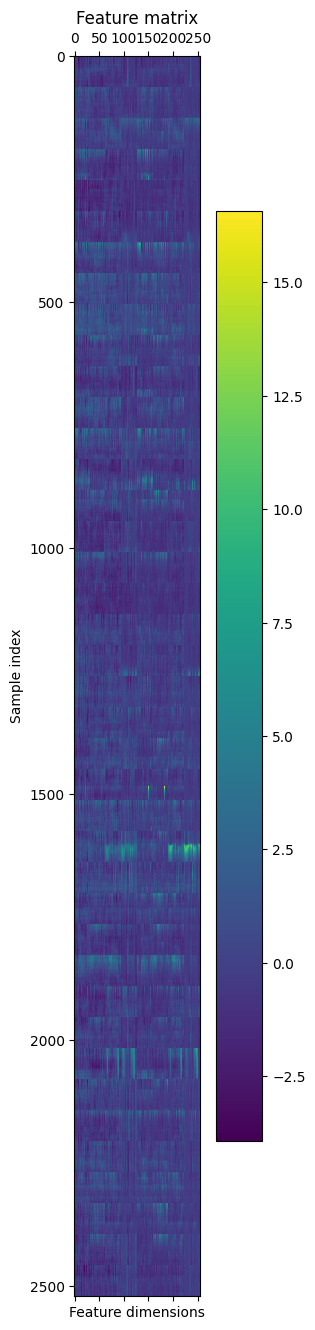

In [58]:
cp.cuda.Device(2).use()

args = get_deap_args()

device = get_device(args.bus_id, args.cuda_id[2])
setting_os_path(args.os_path)
# fix_random_variables(args.seed)


subject_de, subject_psd, subject_label, _ = load_subject_data(args.tensor_save_path, isdeap=True)

visualization_type = 1

for p in range(1):
    if p == 0:
        n_labels_by_class = args.n_labels_by_class3
    elif p == 1:
        n_labels_by_class = args.n_labels_by_class2
    else:
        n_labels_by_class = args.n_labels_by_class1
    
    
    Best_EF_vlc_acc = [[0 for _ in range(9)] for _ in range(9)]
    Best_EF_vlc_std = [[0 for _ in range(9)] for _ in range(9)]

    Best_EF_ars_acc = [[0 for _ in range(9)] for _ in range(9)]
    Best_EF_ars_std = [[0 for _ in range(9)] for _ in range(9)]
    
    for e in range(1,10):
        for f in range(1,10):
            print("+++++++++++++++++++++++++++ Pe: {}, Pf:{} +++++++++++++++++++++++++++++++++++".format(e/10,f/10))

            args.pe1 = e/10
            args.pe2 = e/10
            args.pf1 = f/10
            args.pf2 = f/10
           
            vlc_best_epoch = []
            vlc_orig_acc = []
            vlc_best_acc = []
            ars_best_epoch = []
            ars_orig_acc = []
            ars_best_acc = []
            print("========================================== DEAP Protocol {} ==========================================".format(int(n_labels_by_class)))

            for i in range(32):
                print("\n\n******************* SUBJECT : {} *********************".format(i+1))
                sub_idx = 'sub'+str(i+1)
                date = '230501'

                sub_de = subject_de[i]
                sub_psd = subject_psd[i]
                sub_label = subject_label[i]
                valence_label, arousal_label = deap_label(sub_label)

                de, psd, vlc_identifier, ars_identifier = other_preprocessing(sub_de,sub_psd, (valence_label,arousal_label), n_labels_by_class, args.out_channels, args.seed, isdeap=True)

                de = normalization(de, axis = 0, ntype='standardization')
                psd = normalization(psd, axis = 0, ntype='standardization')

                de_ssm, de_nssm = ssm_construction(de, args.n_samples,args.de_k)
                psd_ssm, psd_nssm = ssm_construction(psd, args.n_samples,args.psd_k)
                save_np(args.tensor_save_path+sub_idx, 'de_ssm_'+date, de_ssm)
                save_np(args.tensor_save_path+sub_idx, 'psd_ssm_'+date, psd_ssm)
                save_np(args.tensor_save_path+sub_idx, 'de_nssm_'+date, de_nssm)
                save_np(args.tensor_save_path+sub_idx, 'psd_nssm_'+date, psd_nssm)
                save_heatmap(de_ssm, "DE SSM", "Sample indices (axis i)", "Sample indices (axis i)", args.figure_save_path+'heatmap/'+sub_idx+'/ssm/DE_SSM_'+date+'.png',clim_min =None, clim_max =None, _dpi=300, _facecolor="#eeeeee", _bbox_inches = 'tight')
                save_heatmap(psd_ssm, "PSD SSM", "Sample indices (axis i)", "Sample indices (axis i)", args.figure_save_path+'heatmap/'+sub_idx+'/ssm/PSD_SSM_'+date+'.png',clim_min =None, clim_max =None, _dpi=300, _facecolor="#eeeeee", _bbox_inches = 'tight')
                save_heatmap(de_nssm, "DE NSSM", "Sample indices (axis i)", "Sample indices (axis i)", args.figure_save_path+'heatmap/'+sub_idx+'/ssm/DE_NSSM_'+date+'.png',clim_min =None, clim_max =None, _dpi=300, _facecolor="#eeeeee", _bbox_inches = 'tight')
                save_heatmap(psd_nssm, "PSD NSSM", "Sample indices (axis i)", "Sample indices (axis i)", args.figure_save_path+'heatmap/'+sub_idx+'/ssm/PSD_NSSM_'+date+'.png',clim_min =None, clim_max =None, _dpi=300, _facecolor="#eeeeee", _bbox_inches = 'tight')

                fsm = ssm_fusion(de_ssm,psd_ssm, de_nssm, psd_nssm, args.k1, args.t1)
                save_np(args.tensor_save_path+sub_idx, 'fused_ssm_'+date, fsm)
                save_heatmap(fsm, "Fused SSM", "Sample indices (axis i)", "Sample indices (axis i)", args.figure_save_path+'heatmap/'+sub_idx+'/fused_ssm/Fused_SSM_'+date+'.png',clim_min =None, clim_max =None, _dpi=300, _facecolor="#eeeeee", _bbox_inches = 'tight')


                adj = normalize_adj(fsm)
                save_np(args.tensor_save_path+sub_idx, 'adjacency_matrix_'+date, adj)
                save_heatmap(adj, "Normalized Adjacecy Matrix", "Sample indices (axis i)", "Sample indices (axis i)", args.figure_save_path+'heatmap/'+sub_idx+'/adjacency_matrix/Adjacecny_Matrix_'+date+'.png',clim_min =None, clim_max =None, _dpi=300, _facecolor="#eeeeee", _bbox_inches = 'tight')


                feature = input_feature(de, psd)

                save_heatmap(feature, "Feature matrix", "Feature dimensions", "Sample index", args.figure_save_path+'heatmap/'+sub_idx+'/feature/feature_matrix_'+date+'.png',clim_min =None, clim_max =None, _dpi=300, _facecolor="#eeeeee", _bbox_inches = 'tight') 

                feature = torch.from_numpy(feature).to(torch.float32).to(device)
                adj = torch.from_numpy(adj).to(torch.float32).to(device)
                ars_label = torch.from_numpy(arousal_label).to(torch.long).to(device)
                vlc_label = torch.from_numpy(valence_label).to(torch.long).to(device)

                vlc_identifier = torch.from_numpy(vlc_identifier).bool()
                vlc_train_identifier = vlc_identifier.to(device)
                isunlabeled = ~vlc_identifier
                vlc_test_identifier = isunlabeled.to(device)

                ars_identifier = torch.from_numpy(ars_identifier).bool()
                ars_train_identifier = ars_identifier.to(device)
                isunlabeled = ~ars_identifier
                ars_test_identifier = isunlabeled.to(device)

                activation = get_activation('celu')
                gcn = GraphConvolution

                encoder = Encoder(args.feature_dimension, args.gcn_hid_channels, args.gcn_out_channels, activation, args.seed, base_model = gcn).to(device)
                model = GRACE(encoder, args.feature_dimension, args.gcn_out_channels, args.proj_hid_channels, args.out_channels, args.ptau).to(device)
                optimizer = torch.optim.Adam(model.parameters(), lr = args.learning_rate)

                model, best_acc, best_epoch, best_model, best_z, result = GCA_train2(model, optimizer, feature, adj, vlc_label,
                                                                            vlc_train_identifier, vlc_test_identifier,
                                                                            args,device,date,sub_idx, isdeap=True)
                print("*** Best ACC : {} ***".format(round(best_acc.item(), 2)))
                vlc_best_acc.append(round(best_acc.item(), 2))
                vlc_orig_acc.append(best_acc.item())
                vlc_best_epoch.append(best_epoch)

                experiment_type = 'subject_dependent'
                model_save_name = sub_idx+'_model_valence'
                model_path = args.model_save_path+experiment_type+'/'+date+'/'+model_save_name
                torch.save(model.state_dict(), model_path)


                encoder = Encoder(args.feature_dimension, args.gcn_hid_channels, args.gcn_out_channels, activation, args.seed, base_model = gcn).to(device)
                model = GRACE(encoder, args.feature_dimension, args.gcn_out_channels, args.proj_hid_channels, args.out_channels, args.ptau).to(device)
                optimizer = torch.optim.Adam(model.parameters(), lr = args.learning_rate)

                model, best_acc, best_epoch, best_model, best_z, result = GCA_train2(model, optimizer, feature, adj, ars_label,
                                                                                    ars_train_identifier, ars_test_identifier,
                                                                                    args,date,sub_idx, isdeap=True)

                print("*** Best ACC : {} ***".format(round(best_acc.item(), 2)))
                ars_best_acc.append(round(best_acc.item(), 2))
                ars_orig_acc.append(best_acc.item())
                ars_best_epoch.append(best_epoch)

                experiment_type = 'subject_dependent'
                model_save_name = sub_idx+'_model_arousal'
                model_path = args.model_save_path+experiment_type+'/'+date+'/'+model_save_name
                torch.save(model.state_dict(), model_path)

            print("\n**************** Valence *********************")
            print("** Best ACC : {} **\n ** Avearge acc : {},    std : {} **\n".format(vlc_best_acc, np.mean(vlc_best_acc), np.std(vlc_best_acc)))
            print("\n Best Epochs : {}".format(vlc_best_epoch))
            print("**************** Arousal *********************")
            print("** Best ACC : {} **\n ** Avearge acc : {},    std : {} **\n".format(ars_best_acc, np.mean(ars_best_acc), np.std(ars_best_acc)))
            print("\n Best Epochs : {}".format(ars_best_epoch))


            vlc_best_acc_list = np.array(vlc_best_acc)
            save_np(args.tensor_save_path+sub_idx, 'protocol '+str(n_labels_by_class)+'_vlc_best_acc_list_'+date, vlc_best_acc_list)
            ars_best_acc_list = np.array(ars_best_acc)
            save_np(args.tensor_save_path+sub_idx, 'protocol '+str(n_labels_by_class)+'_ars_best_acc_list_'+date, ars_best_acc_list)

            Best_EF_vlc_acc[e-1][f-1] = round(np.mean(vlc_orig_acc),2)
            Best_EF_vlc_std[e-1][f-1] = round(np.std(vlc_orig_acc),2)

            Best_EF_ars_acc[e-1][f-1] = round(np.mean(ars_orig_acc),2)
            Best_EF_ars_std[e-1][f-1] = round(np.std(ars_orig_acc),2)

In [43]:
Best_EF_vlc_acc

[[97.48, 97.63, 97.52, 97.45, 97.37, 96.92, 96.29, 95.25, 93.67],
 [97.45, 97.6, 97.57, 97.43, 97.26, 96.87, 96.21, 95.09, 93.54],
 [97.5, 97.67, 97.42, 97.45, 97.17, 96.94, 96.24, 95.0, 93.43],
 [97.53, 97.55, 97.47, 97.35, 97.15, 96.94, 96.1, 94.97, 93.36],
 [97.57, 97.5, 97.46, 97.32, 97.09, 96.79, 95.93, 94.76, 93.22],
 [97.54, 97.48, 97.38, 97.25, 97.08, 96.61, 95.96, 94.48, 92.72],
 [97.39, 97.4, 97.25, 97.17, 96.83, 96.48, 95.7, 94.32, 92.27],
 [97.3, 97.18, 97.12, 96.93, 96.58, 96.17, 95.24, 93.77, 91.54],
 [96.61, 96.38, 96.31, 95.89, 95.54, 95.02, 94.11, 92.34, 89.96]]

In [44]:
Best_EF_vlc_std

[[1.45, 1.74, 1.74, 1.9, 2.04, 2.37, 2.76, 3.21, 3.49],
 [1.44, 1.6, 1.73, 1.81, 2.05, 2.4, 2.84, 3.12, 3.48],
 [1.57, 1.6, 1.88, 1.89, 2.05, 2.28, 2.75, 3.25, 3.4],
 [1.5, 1.68, 1.85, 1.88, 1.95, 2.23, 2.84, 3.16, 3.32],
 [1.56, 1.55, 1.74, 1.79, 2.0, 2.34, 2.89, 3.27, 3.35],
 [1.49, 1.58, 1.67, 1.91, 2.03, 2.39, 2.88, 3.39, 3.51],
 [1.55, 1.7, 1.78, 1.91, 2.04, 2.42, 2.89, 3.37, 3.55],
 [1.56, 1.69, 1.72, 1.89, 2.24, 2.53, 2.99, 3.43, 3.72],
 [1.8, 1.83, 1.91, 2.03, 2.37, 2.65, 3.11, 3.49, 3.58]]

In [45]:
Best_EF_ars_acc

[[97.68, 97.72, 97.64, 97.44, 97.26, 96.92, 96.44, 95.49, 93.86],
 [97.84, 97.71, 97.68, 97.55, 97.23, 97.03, 96.38, 95.56, 93.82],
 [97.76, 97.59, 97.57, 97.42, 97.26, 96.93, 96.35, 95.29, 93.56],
 [97.72, 97.62, 97.59, 97.34, 97.18, 96.98, 96.28, 95.2, 93.35],
 [97.83, 97.6, 97.54, 97.44, 97.14, 96.76, 96.21, 94.93, 93.24],
 [97.62, 97.62, 97.43, 97.29, 97.0, 96.63, 95.95, 94.86, 92.92],
 [97.65, 97.61, 97.45, 97.11, 96.93, 96.48, 95.81, 94.5, 92.5],
 [97.42, 97.43, 97.15, 96.96, 96.69, 96.19, 95.48, 93.95, 91.92],
 [96.63, 96.56, 96.39, 96.09, 95.76, 95.24, 94.28, 92.66, 90.29]]

In [46]:
Best_EF_ars_std

[[1.67, 1.71, 2.01, 2.05, 2.3, 2.3, 2.6, 2.88, 3.28],
 [1.62, 1.74, 1.99, 1.99, 2.18, 2.46, 2.6, 2.85, 3.44],
 [1.58, 1.88, 1.9, 2.15, 2.09, 2.38, 2.53, 2.85, 3.32],
 [1.71, 1.87, 2.08, 2.13, 2.18, 2.19, 2.45, 2.9, 3.34],
 [1.59, 1.88, 1.98, 2.09, 2.16, 2.3, 2.45, 3.07, 3.34],
 [1.69, 1.79, 2.06, 2.12, 2.21, 2.27, 2.7, 3.07, 3.56],
 [1.77, 1.71, 2.02, 2.1, 2.36, 2.48, 2.74, 3.09, 3.46],
 [1.77, 1.92, 2.02, 2.22, 2.27, 2.44, 2.75, 3.23, 3.48],
 [1.93, 2.1, 2.23, 2.3, 2.44, 2.55, 2.84, 3.2, 3.86]]

In [122]:

visualization_type = 1
sample = best_z.cpu().detach().numpy().copy()
drmodel = TSNE(n_components = 2, perplexity = 50., n_iter_without_progress = 4000)
tsne_sample = StandardScaler().fit_transform(sample) # standardization
dr_result = drmodel.fit_transform(tsne_sample)


/home/neuroai/anaconda3/envs/py39_dh/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/neuroai/anaconda3/envs/py39_dh/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


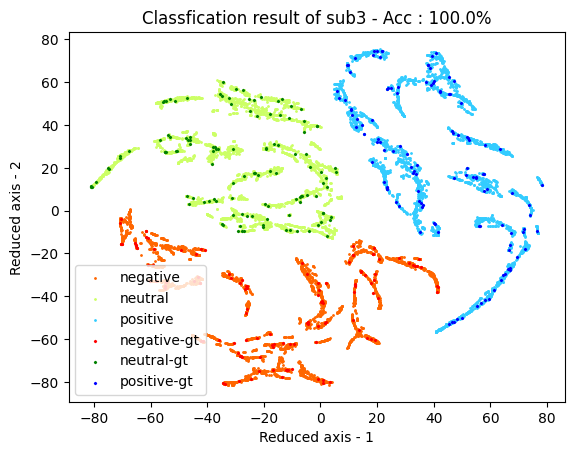

In [123]:
save_scatter(dr_result, label, best_acc.item(),sub_idx, date, args.figure_save_path, visualization_type, identifier)

In [120]:
def save_scatter(result, label, best_acc,sub_idx, date, save_path, dr_type, iden):

    negw = np.where(label.cpu()==0)[0]
    neuw = np.where(label.cpu()==1)[0]
    posw = np.where(label.cpu()==2)[0]
    if dr_type == 0:
        dr_name = 'PCA'
    elif dr_type == 1:
        dr_name = 'TSNE'
    else:
        dr_name = ''
    neg = result[negw]
    neu = result[neuw]
    pos = result[posw]

    gts = np.where(iden.cpu().numpy() ==True)[0]

    neggtw,neugtw,posgtw = [], [], []
    
    for i in gts:
        if i in negw:
            neggtw.append(i)
        elif i in neuw:
            neugtw.append(i)
        elif i in posw:
            posgtw.append(i)

    neggt = result[neggtw,:]
    neugt = result[neugtw,:]
    posgt = result[posgtw,:]
    
    plt.clf()
    c1 = plt.scatter(neg[:,0], neg[:,1], marker = "o", color='#FF6600',s=1.)
    gt1 = plt.scatter(neggt[:,0], neggt[:,1], marker = "x", color='red',s=2.)
    c2 = plt.scatter(neu[:,0], neu[:,1], marker = "o",color ='#CCFF66', s=1.)
    gt2 = plt.scatter(neugt[:,0], neugt[:,1], marker = "x", color='green',s=2.)
    c3 = plt.scatter(pos[:,0], pos[:,1], marker = "o",color ='#33CCFF', s=1.)
    gt3 = plt.scatter(posgt[:,0], posgt[:,1], marker = "x", color='blue',s=2.)
    
    plt.title('Classfication result of '+sub_idx + ' - Acc : '+ str(best_acc) +'%')
    plt.xlabel("Reduced axis - 1")
    plt.ylabel("Reduced axis - 2")
    plt.legend(handles = (c1,c2,c3, gt1,gt2,gt3),labels=("negative","neutral", "positive", "negative-gt", "neutral-gt", "positive-gt"))
    plt.savefig(save_path+'test_result/'+sub_idx+'/'+dr_name+'_classification_result_scatter_'+date+'.png', dpi=300, facecolor = "#eeeeee", bbox_inches = 'tight')
    return

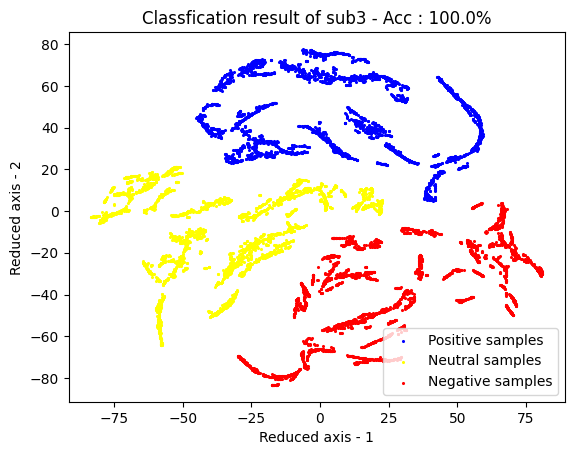

In [113]:
activation = get_activation('celu')
gcn = GraphConvolution

encoder = Encoder(args.feature_dimension, args.gcn_hid_channels, args.gcn_out_channels, activation, args.seed, base_model = gcn).to(device)
model = GRACE(encoder, args.feature_dimension, args.gcn_out_channels, args.proj_hid_channels, args.out_channels, args.ptau).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

model, best_acc, best_epoch, best_model, best_z, result = GCA_train(model, optimizer, feature, adj, vlc_label,
                                                                    vlc_train_identifier, vlc_test_identifier,
                                                                    args,device,date,sub_idx, isdeap=True)
print("*** Best ACC : {} ***".format(round(best_acc.item(), 2)))



Epoch 10 - Train Acc : 74.58    Train Loss : 0.54,    Test Acc : 65.5,    Test Loss :0.5,    Total Acc : 70.04
Epoch 20 - Train Acc : 77.08    Train Loss : 0.48,    Test Acc : 67.65,    Test Loss :0.5,    Total Acc : 72.36
Epoch 30 - Train Acc : 70.83    Train Loss : 0.65,    Test Acc : 74.79,    Test Loss :0.53,    Total Acc : 72.81
Epoch 40 - Train Acc : 83.33    Train Loss : 0.44,    Test Acc : 73.94,    Test Loss :0.46,    Total Acc : 78.64
Epoch 50 - Train Acc : 84.58    Train Loss : 0.38,    Test Acc : 76.5,    Test Loss :0.41,    Total Acc : 80.54
Epoch 60 - Train Acc : 91.25    Train Loss : 0.31,    Test Acc : 85.73,    Test Loss :0.33,    Total Acc : 88.49
Epoch 70 - Train Acc : 90.83    Train Loss : 0.35,    Test Acc : 83.44,    Test Loss :0.37,    Total Acc : 87.14
Epoch 80 - Train Acc : 88.33    Train Loss : 0.32,    Test Acc : 83.44,    Test Loss :0.35,    Total Acc : 85.89
Epoch 90 - Train Acc : 90.42    Train Loss : 0.3,    Test Acc : 81.88,    Test Loss :0.4,    Total A

Epoch 760 - Train Acc : 98.33    Train Loss : 0.12,    Test Acc : 86.0,    Test Loss :0.75,    Total Acc : 92.17
Epoch 770 - Train Acc : 99.17    Train Loss : 0.1,    Test Acc : 89.35,    Test Loss :0.84,    Total Acc : 94.26
Epoch 780 - Train Acc : 98.75    Train Loss : 0.12,    Test Acc : 89.6,    Test Loss :0.78,    Total Acc : 94.18
Epoch 790 - Train Acc : 98.75    Train Loss : 0.1,    Test Acc : 90.58,    Test Loss :0.76,    Total Acc : 94.67
Epoch 800 - Train Acc : 99.17    Train Loss : 0.1,    Test Acc : 90.92,    Test Loss :0.65,    Total Acc : 95.04
Epoch 810 - Train Acc : 99.58    Train Loss : 0.09,    Test Acc : 89.81,    Test Loss :0.79,    Total Acc : 94.7
Epoch 820 - Train Acc : 99.17    Train Loss : 0.1,    Test Acc : 89.02,    Test Loss :0.77,    Total Acc : 94.09
Epoch 830 - Train Acc : 100.0    Train Loss : 0.08,    Test Acc : 89.29,    Test Loss :0.75,    Total Acc : 94.65
Epoch 840 - Train Acc : 99.17    Train Loss : 0.09,    Test Acc : 90.52,    Test Loss :0.81,   

Epoch 1480 - Train Acc : 99.17    Train Loss : 0.09,    Test Acc : 89.77,    Test Loss :0.74,    Total Acc : 94.47
Epoch 1490 - Train Acc : 100.0    Train Loss : 0.08,    Test Acc : 91.44,    Test Loss :0.67,    Total Acc : 95.72
Epoch 1500 - Train Acc : 100.0    Train Loss : 0.08,    Test Acc : 91.98,    Test Loss :0.69,    Total Acc : 95.99
Epoch 1510 - Train Acc : 99.58    Train Loss : 0.08,    Test Acc : 91.58,    Test Loss :0.68,    Total Acc : 95.58
Epoch 1520 - Train Acc : 99.17    Train Loss : 0.1,    Test Acc : 91.27,    Test Loss :0.71,    Total Acc : 95.22
Epoch 1530 - Train Acc : 99.58    Train Loss : 0.08,    Test Acc : 90.9,    Test Loss :0.76,    Total Acc : 95.24
Epoch 1540 - Train Acc : 100.0    Train Loss : 0.08,    Test Acc : 88.96,    Test Loss :0.93,    Total Acc : 94.48
Epoch 1550 - Train Acc : 99.17    Train Loss : 0.1,    Test Acc : 90.25,    Test Loss :0.66,    Total Acc : 94.71
Epoch 1560 - Train Acc : 99.17    Train Loss : 0.09,    Test Acc : 89.52,    Test L

Epoch 2200 - Train Acc : 100.0    Train Loss : 0.08,    Test Acc : 91.23,    Test Loss :0.99,    Total Acc : 95.61
Epoch 2210 - Train Acc : 100.0    Train Loss : 0.08,    Test Acc : 92.54,    Test Loss :0.94,    Total Acc : 96.27
Epoch 2220 - Train Acc : 100.0    Train Loss : 0.08,    Test Acc : 91.9,    Test Loss :1.05,    Total Acc : 95.95
Epoch 2230 - Train Acc : 100.0    Train Loss : 0.07,    Test Acc : 91.9,    Test Loss :1.12,    Total Acc : 95.95
Epoch 2240 - Train Acc : 100.0    Train Loss : 0.07,    Test Acc : 92.17,    Test Loss :0.96,    Total Acc : 96.08
Epoch 2250 - Train Acc : 100.0    Train Loss : 0.08,    Test Acc : 91.85,    Test Loss :1.03,    Total Acc : 95.93
Epoch 2260 - Train Acc : 100.0    Train Loss : 0.08,    Test Acc : 91.69,    Test Loss :1.03,    Total Acc : 95.84
Epoch 2270 - Train Acc : 99.58    Train Loss : 0.08,    Test Acc : 90.31,    Test Loss :1.17,    Total Acc : 94.95
Epoch 2280 - Train Acc : 99.58    Train Loss : 0.09,    Test Acc : 89.88,    Test 

Epoch 2930 - Train Acc : 92.5    Train Loss : 0.25,    Test Acc : 86.96,    Test Loss :0.73,    Total Acc : 89.73
Epoch 2940 - Train Acc : 95.83    Train Loss : 0.21,    Test Acc : 86.52,    Test Loss :1.0,    Total Acc : 91.18
Epoch 2950 - Train Acc : 93.75    Train Loss : 0.2,    Test Acc : 86.15,    Test Loss :0.91,    Total Acc : 89.95
Epoch 2960 - Train Acc : 96.67    Train Loss : 0.17,    Test Acc : 86.83,    Test Loss :0.83,    Total Acc : 91.75
Epoch 2970 - Train Acc : 95.83    Train Loss : 0.16,    Test Acc : 86.88,    Test Loss :0.85,    Total Acc : 91.35
Epoch 2980 - Train Acc : 94.17    Train Loss : 0.21,    Test Acc : 83.77,    Test Loss :0.9,    Total Acc : 88.97
Epoch 2990 - Train Acc : 95.0    Train Loss : 0.19,    Test Acc : 84.88,    Test Loss :1.0,    Total Acc : 89.94
Epoch 3000 - Train Acc : 95.83    Train Loss : 0.16,    Test Acc : 84.94,    Test Loss :0.84,    Total Acc : 90.39
*** Best ACC : 94.38 ***


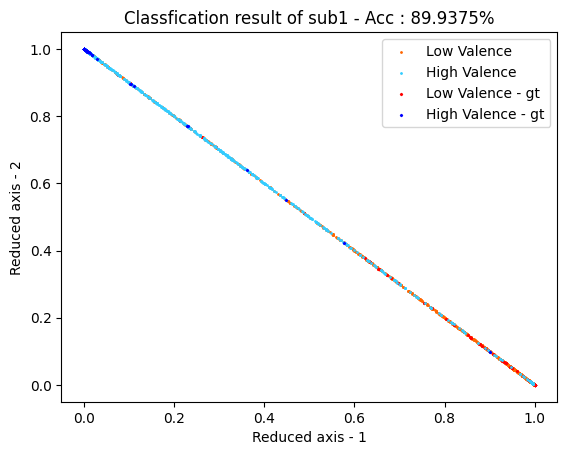

In [244]:
save_scatter_deap(result.detach().cpu().numpy(), vlc_label, best_acc, sub_idx, date, args.figure_save_path, visualization_type, vlc_train_identifier, cf_name, fig_name)

/home/neuroai/anaconda3/envs/py39_dh/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/neuroai/anaconda3/envs/py39_dh/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


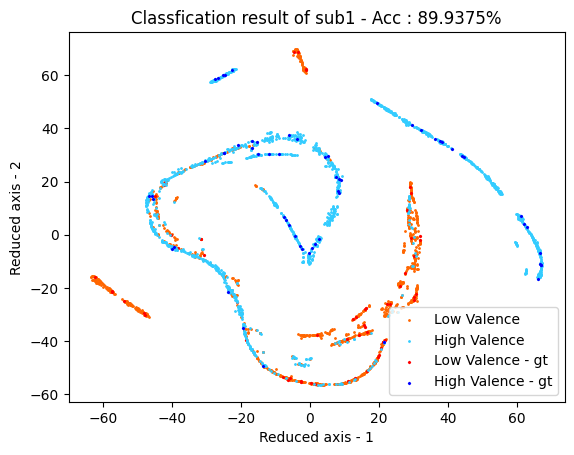

In [209]:
dr_result = feature.cpu().numpy()
visualization_type = 1
if visualization_type == 0:
    sample = result.cpu().detach().numpy().copy()
    drmodel = PCA(n_components = 2)
    pca_sample = StandardScaler().fit_transform(sample) # standardization
    dr_result = drmodel.fit_transform(pca_sample)
    
elif visualization_type == 1:
    sample = result.cpu().detach().numpy().copy()
    drmodel = TSNE(n_components = 2, n_iter_without_progress = 2000)
    tsne_sample = StandardScaler().fit_transform(sample) # standardization
    dr_result = drmodel.fit_transform(tsne_sample)
    
cf_name = 'Valence'
fig_name = 'Output'
save_scatter_deap(result, vlc_label, best_acc, sub_idx, date, args.figure_save_path, visualization_type, vlc_train_identifier, cf_name, fig_name)

# Adaptive method

# Edge drop hyperparameter validation

In [273]:
drop_features(feature, adj, 0.1)

tensor([0.9799, 0.9831, 0.9841, 0.9768, 0.9771, 0.9678, 0.9316, 0.9309, 0.8962,
        0.9055, 0.9393, 0.9465, 0.9641, 0.9234, 0.9590, 0.9240, 0.9305, 0.9317,
        0.9401, 0.9515, 0.9146, 0.9384, 0.9289, 0.9477, 0.9246, 0.9270, 0.9475,
        0.9976, 0.9988, 0.9267, 0.9059, 0.9225, 0.9338, 0.9253, 0.9638, 0.9094,
        0.9854, 0.9458, 0.9430, 0.9387, 0.9164, 0.9092, 0.9189, 0.9381, 0.9749,
        0.9880, 0.9062, 0.9382, 0.9212, 0.9268, 0.9095, 0.9084, 0.8920, 0.8948,
        0.8015, 0.9425, 0.9427, 0.9326, 0.9401, 0.9608, 0.9495, 0.9430, 0.9884,
        0.9848, 0.9785, 0.9740, 0.9787, 0.9720, 0.9536, 0.9524, 0.9413, 0.9656,
        0.8708, 0.8938, 0.9526, 0.9325, 0.9652, 0.9113, 0.9163, 0.9148, 0.9691,
        0.9783, 0.9197, 0.9212, 0.8937, 0.9526, 0.9406, 0.9471, 0.9419, 0.9970,
        1.0000, 0.9359, 0.9276, 0.9060, 0.9805, 0.9285, 0.9575, 0.9126, 0.9775,
        0.9644, 0.9618, 0.9385, 0.9209, 0.9199, 0.9463, 0.9716, 0.9474, 0.9438,
        0.9317, 0.9781, 0.9592, 0.9558, 

tensor([[-0.9299, -0.9922, -1.3947,  ..., -0.1198,  0.6016,  0.5215],
        [-0.9305, -0.9918, -1.3938,  ..., -0.1196,  0.6023,  0.5221],
        [-0.9314, -0.9922, -1.3941,  ..., -0.1192,  0.6038,  0.5234],
        ...,
        [-1.7059, -1.4937, -1.3851,  ...,  0.7166,  1.0864,  1.0704],
        [-1.7075, -1.4946, -1.3852,  ...,  0.7163,  1.0861,  1.0702],
        [-1.7081, -1.4952, -1.3858,  ...,  0.7161,  1.0858,  1.0699]],
       device='cuda:1')

In [263]:

def drop_edges(edge_weights, p: float, threshold: float = 1.):
#     alleviated_weights = torch.log(edge_weights)
    weight_max = edge_weights.max()
    weights = (weight_max-edge_weights)/(weight_max-edge_weights.mean())

    probability_weights = weights / weights.mean() * p
    probability_weights = probability_weights.where(probability_weights < threshold, torch.ones_like(probability_weights) * threshold)
    drop_mask = torch.bernoulli(1. - probability_weights).to(torch.bool)
   
    edge_weights_view = edge_weights.where(drop_mask == True, torch.zeros_like(edge_weights))
    
    return edge_weights_view

# Feature drop hyperparameter validation

In [270]:
def drop_features(features, edges, p: float, threshold: float = 0.7):
    x = torch.abs(features)
    row_sum = torch.sum(edges, axis=0)
    feature_weights = x.t() @ row_sum
    feature_weights = feature_weights.log()
    weight_max = feature_weights.max()
    w = (weight_max-feature_weights)/(weight_max-feature_weights.mean())

    probability_weights = w / w.mean() * p
    probability_weights = probability_weights.where(probability_weights < threshold, torch.ones_like(probability_weights) * threshold) 
    drop_mask = torch.bernoulli(probability_weights).to(torch.bool)
    
    features_view = features.clone()
    features_view[:,drop_mask] = 0.

    return features_view


In [10]:
def drop_features2(probability_weights, features, threshold: float = 1.):

    probability_weights = probability_weights.where(probability_weights < threshold, torch.ones_like(probability_weights) * threshold) 
    drop_mask = torch.bernoulli(probability_weights).to(torch.bool)
    
    features_view = features.clone()
    features_view[:,drop_mask] = 0.

    return features_view

def edge_rank(edge_weights):
    weight_max = edge_weights.max(axis=1).values
    weight_mean = edge_weights.sum(axis=1)/(edge_weights!=0).sum(axis=1)
    weights = (weight_max-edge_weights)/(weight_max-edge_weights.mean())
    return weights

def drop_edges2(probability_weights, edge_weights, threshold: float = 1.):
#     alleviated_weights = torch.log(edge_weights

    probability_weights = probability_weights.where(probability_weights < threshold, torch.ones_like(probability_weights) * threshold)
    drop_mask = torch.bernoulli(1. - probability_weights).to(torch.bool)
   
    edge_weights_view = edge_weights.where(drop_mask == True, torch.zeros_like(edge_weights))

    return edge_weights_view


def GCA_train2(model, otimizer, feature, orig_adj, label, train_identifier, test_identifier, args, device,date = None,sub_idx = None, isdeap=False ):
#     save_path = args.model_save_path+'subject_dependent/'+date+'/'+sub_idx+'.pt'
#     early_stopping = EarlyStopping(patience = args.patience, verbose = False, path=save_path)
    best_acc = 0
    best_epoch = 0
    best_model = None
    best_z = None
#     w = 0.5

    rankf = disc_rank(feature, label,train_identifier, args.out_channels)
    rankf1 = rankf*args.pf1
    rankf2 = rankf*args.pf2
    ranke = edge_rank(adj)
    ranke1 = ranke*args.pe1
    ranke2 = ranke*args.pe2
    
    for epoch in range(1, args.epochs+1):
        model.train()
        optimizer.zero_grad()
        x1 = drop_features2(rankf1, feature, threshold = args.tpf1)
        x2 = drop_features2(rankf2, feature, threshold = args.tpf2)
        e1 = drop_edges2(ranke1,orig_adj, threshold = args.tpe1)
        e2 = drop_edges2(ranke2,orig_adj, threshold = args.tpe2)

#         x1 = drop_features(feature, adj, p = 0.1, threshold = args.tpf1)
#         x2 = drop_features(feature, adj, p = 0.2, threshold = args.tpf2)
#         e1 = drop_edges(adj, p = 0.1, threshold = args.tpe1)
#         e2 = drop_edges(adj, p = 0.2, threshold = args.tpe2)
        
        z1 = model(x1,e1) #,bias = True)
#         z1 = model(feature,adj)
        z1 = model.projection(z1)
        z2 = model(x2,e2)
        z2 = model.projection(z2)   
        
#         ne1 = model.decoder(z1)
#         ne2 = model.decoder(z2)
 
#         ne1 = (ne1-ne1.min())/(ne1.max()-ne1.min())
#         ne2 = (ne2-ne2.min())/(ne2.max()-ne2.min())
#         nadj1 = w*adj + (1.-w)*ne1
#         nadj2 = w*adj + (1.-w)*ne2
#         nadj = 0.5*(nadj1+nadj2)
#         print(nadj)
 
        r1 = model.classification(z1)
        r1_pred = r1[train_identifier]
        r1_y = label[train_identifier]
        # L2 regularization is not implemented yet
        labeled_loss1 = criterion(r1_pred, r1_y)
        r1_acc = accuracy(r1_pred, r1_y, isdeap)

        r2 = model.classification(z2)
        r2_pred = r2[train_identifier]
        r2_y = label[train_identifier]
        # L2 regularization is not implemented yet
        labeled_loss2 = criterion(r2_pred, r2_y)
        r2_acc = accuracy(r2_pred, r2_y, isdeap)

        
        contrastive_loss = model.loss(z1,z2)
#         print(contrastive_loss)
        loss = (labeled_loss1 + labeled_loss2)/2. + contrastive_loss*args.loss_lambda
#         loss = labeled_loss1 + contrastive_loss*args.loss_lambda

        loss.backward()
        optimizer.step()
        
#         orig_adj = nadj.detach().clone().to(device)
#         print(orig_adj)
#         adj = nadj.detach().clone().cuda()
        acc = (r1_acc + r2_acc)/2.
#         acc = r1_acc
        
        tr1_pred = r1[test_identifier]
        tr1_y = label[test_identifier]
        tr1_loss = criterion(tr1_pred, tr1_y)
        tr1_acc = accuracy(tr1_pred, tr1_y, isdeap)
        
        tr2_pred = r2[test_identifier]
        tr2_y = label[test_identifier]
        tr2_acc = accuracy(tr2_pred, tr2_y, isdeap)
        tr2_loss = criterion(tr2_pred, tr2_y)
        
#         tr_acc = (tr1_acc + tr2_acc)/2.
        if tr1_acc > tr2_acc:
            result = r1
            tr_acc = tr1_acc
        else:
            result = r2
            tr_acc = tr2_acc
        
        tr_loss = (tr1_loss + tr2_loss)/2.
        total_acc = (tr_acc + acc)/2.
        
        if tr_acc > best_acc :
            best_acc = tr_acc
            best_epoch = epoch
            best_model = model
            
            best_result = result
            best_z = z1 if tr1_acc > tr2_acc else z2


#         if epoch % 10 == 0:
#             print("Epoch {} - Train Acc : {}    Train Loss : {},    Test Acc : {},    Test Loss :{},    Total Acc : {}".format(epoch, round(acc.item(), 2), round(loss.item(),2), round(tr_acc.item(),2), round(tr_loss.item(),2), round(total_acc.item(), 2)))

#         early_stopping(vloss, model)
#         if early_stopping.early_stop:
#             print('Epoch : {} - Ealry Stopping'.format(epoch))
#             break
#     model.load_state_dict(torch.load(save_path))
    return model, best_acc, best_epoch, best_model, best_z, best_result


# Row max, mean with Self-similarity 

In [85]:
args

{'bus_id': 'PCI_BUS_ID',
 'cuda_id': ['0', '1', '2'],
 'os_path': '/home/neuroai/users/dhkim/eer/SSLGCN',
 'feature_name1': 'DE_LDS_data',
 'feature_name2': 'PSD_LDS_data',
 'deap_label_dir_path': 'dataset/deap/data_preprocessed_matlab/',
 'deap_data_dir_path': 'dataset/deap/extractedfeatures/de_psd_lds/',
 'figure_save_path': 'store_deap/figure/',
 'tensor_save_path': 'store_deap/tensor/',
 'model_save_path': 'store_deap/model/',
 'valence': 'Valence',
 'arousal': 'Arousal',
 'n_subjects': 32,
 'n_trials': 40,
 'n_nodes': 32,
 'n_features': 4,
 'n_samples': 2520,
 'n_labels_by_class1': 60,
 'n_labels_by_class2': 90,
 'n_labels_by_class3': 120,
 'n_labels': 2,
 'seed': 2023,
 'EEG_band': None,
 'pca_components1': 9,
 'pca_components2': 6,
 'essm_lambda': 0.9,
 'de_k': 1200,
 'psd_k': 1200,
 'k1': 30,
 'k2': 130,
 't1': 1,
 't2': 1,
 'feature_dimension': 256,
 'gcn_hid_channels': 128,
 'gcn_out_channels': 64,
 'out_channels': 2,
 'learning_rate': 0.005,
 'l2_lambda': 0.001,
 'epochs': 3

Device: cuda
Current cuda device: 2
Count of using GPUs: 3
========================================== SEED_IV Protocol 15 ==========================================
+++++++++++++++++++++++++++ Pe: 0.1, Pf:0.1 +++++++++++++++++++++++++++++++++++


******************* SUBJECT : 1 *********************

********** SSM construction start ***********

Distance matrix construction start...
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********

Distance matrix construction start...
Done

Sparse ssm and normalized sparse ssm construction start...
Done

directory already exists
de_ssm_230405 is saved successfully
directory already exists
psd_ssm_230405 is saved successfully
directory already exists
de_nssm_230405 is saved successfully
directory already exists
psd_nssm_230405 is saved successfully

********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature 

/tmp/ipykernel_5080/4212163399.py:59: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.matshow(matrix)


*** Best ACC : 83.03 , Best Epoch : 1380***


******************* SUBJECT : 4 *********************

********** SSM construction start ***********

Distance matrix construction start...
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********

Distance matrix construction start...
Done

Sparse ssm and normalized sparse ssm construction start...
Done

directory already exists
de_ssm_230405 is saved successfully
directory already exists
psd_ssm_230405 is saved successfully
directory already exists
de_nssm_230405 is saved successfully
directory already exists
psd_nssm_230405 is saved successfully

********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
0.2886 sec
Done
**********************************************
directory already exists
fused_ssm_230405 is saved successful

sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
0.2933 sec
Done
**********************************************
directory already exists
fused_ssm_230405 is saved successfully
directory already exists
adjacency_matrix_230405 is saved successfully
*** Best ACC : 84.42 , Best Epoch : 1195***


******************* SUBJECT : 12 *********************

********** SSM construction start ***********

Distance matrix construction start...
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********

Distance matrix construction start...
Done

Sparse ssm and normalized sparse ssm construction start...
Done

directory already exists
de_ssm_230405 is saved successfully
directory already exists
psd_ssm_230405 is saved successfully
directory already exists
de_nssm_230405 is saved successfully
directory already exists
psd_

directory already exists
adjacency_matrix_230405 is saved successfully
*** Best ACC : 82.99 , Best Epoch : 479***


******************* SUBJECT : 4 *********************

********** SSM construction start ***********

Distance matrix construction start...
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********

Distance matrix construction start...
Done

Sparse ssm and normalized sparse ssm construction start...
Done

directory already exists
de_ssm_230405 is saved successfully
directory already exists
psd_ssm_230405 is saved successfully
directory already exists
de_nssm_230405 is saved successfully
directory already exists
psd_nssm_230405 is saved successfully

********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
0.2815 sec
Done
**************************************


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
0.2793 sec
Done
**********************************************
directory already exists
fused_ssm_230405 is saved successfully
directory already exists
adjacency_matrix_230405 is saved successfully


KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 400x1600 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 400x1600 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 400x1600 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 400x1600 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 400x1600 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 400x1600 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 400x1600 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 400x1600 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 400x1600 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 400x1600 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 400x1600 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 400x1600 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 400x1600 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 400x1600 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 400x1600 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 400x1600 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 400x1600 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 400x1600 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 400x1600 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 400x1600 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 400x1600 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 400x1600 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 400x1600 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 400x1600 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 400x1600 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

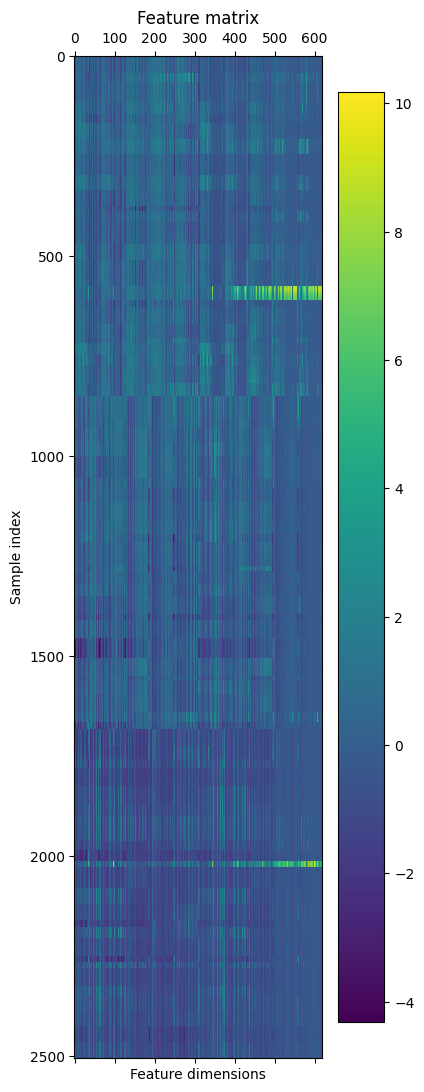

In [11]:
method
cp.cuda.Device(2).use()

args = get_seedIV_args()

device = get_device(args.bus_id, args.cuda_id[2])
setting_os_path(args.os_path)
# fix_random_variables(args.seed)

args.tpe1 = 1.
args.tpe2 = 1.
args.tpf1 = 1.
args.tpf2 = 1.

subject_de, subject_psd, subject_label, subject_sample_counts = load_subject_data(args.tensor_save_path, isdeap=False)

visualization_type = 1
for p in range(1):
    if p == 0:
        n_labels_by_class = args.n_labels_by_class1
    elif p == 1:
        n_labels_by_class = args.n_labels_by_class2
    else:
        n_labels_by_class = args.n_labels_by_class1
    



    print("========================================== SEED_IV Protocol {} ==========================================".format(int(n_labels_by_class)))
    Best_EF_acc = [[0 for _ in range(9)] for _ in range(9)]
    Best_EF_std = [[0 for _ in range(9)] for _ in range(9)]
    for e in range(1,10):
        for f in range(1,10):
            print("+++++++++++++++++++++++++++ Pe: {}, Pf:{} +++++++++++++++++++++++++++++++++++".format(e/10,f/10))
        
            best_epoch_list = []
            best_acc_list = []
            orig_acc_list = []
            args.pe1 = e/10
            args.pe2 = e/10
            args.pf1 = f/10
            args.pf2 = f/10
            for i in range(15):
                print("\n\n******************* SUBJECT : {} *********************".format(i+1))
                sub_idx = 'sub'+str(i+1)
                date = '230405'

                sub_de = subject_de[i]
                sub_psd = subject_psd[i]
                sub_label = subject_label[i]
                sub_sample_counts = subject_sample_counts[i]

                de, psd, identifier = other_preprocessing(sub_de,sub_psd,sub_label, n_labels_by_class, args.out_channels, args.seed)

                de = normalization(de, axis = 0, ntype='standardization')
                psd = normalization(psd, axis = 0, ntype='standardization')

                de_ssm, de_nssm = ssm_construction(de, args.n_samples, args.de_k)
                psd_ssm, psd_nssm = ssm_construction(psd, args.n_samples, args.psd_k)

                save_np(args.tensor_save_path+sub_idx, 'de_ssm_'+date, de_ssm)
                save_np(args.tensor_save_path+sub_idx, 'psd_ssm_'+date, psd_ssm)
                save_np(args.tensor_save_path+sub_idx, 'de_nssm_'+date, de_nssm)
                save_np(args.tensor_save_path+sub_idx, 'psd_nssm_'+date, psd_nssm)
                save_heatmap(de_ssm, "DE SSM", "Sample indices (axis i)", "Sample indices (axis i)", args.figure_save_path+'heatmap/'+sub_idx+'/ssm/DE_SSM_'+date+'.png',clim_min =None, clim_max =None, _dpi=300, _facecolor="#eeeeee", _bbox_inches = 'tight')
                save_heatmap(psd_ssm, "PSD SSM", "Sample indices (axis i)", "Sample indices (axis i)", args.figure_save_path+'heatmap/'+sub_idx+'/ssm/PSD_SSM_'+date+'.png',clim_min =None, clim_max =None, _dpi=300, _facecolor="#eeeeee", _bbox_inches = 'tight')
                save_heatmap(de_nssm, "DE NSSM", "Sample indices (axis i)", "Sample indices (axis i)", args.figure_save_path+'heatmap/'+sub_idx+'/ssm/DE_NSSM_'+date+'.png',clim_min =None, clim_max =None, _dpi=300, _facecolor="#eeeeee", _bbox_inches = 'tight')
                save_heatmap(psd_nssm, "PSD NSSM", "Sample indices (axis i)", "Sample indices (axis i)", args.figure_save_path+'heatmap/'+sub_idx+'/ssm/PSD_NSSM_'+date+'.png',clim_min =None, clim_max =None, _dpi=300, _facecolor="#eeeeee", _bbox_inches = 'tight')

                fsm = ssm_fusion(de_ssm,psd_ssm, de_nssm, psd_nssm, args.k1, args.t1)
                save_np(args.tensor_save_path+sub_idx, 'fused_ssm_'+date, fsm)
                save_heatmap(fsm, "Fused SSM", "Sample indices (axis i)", "Sample indices (axis i)", args.figure_save_path+'heatmap/'+sub_idx+'/fused_ssm/Fused_SSM_'+date+'.png',clim_min =None, clim_max =None, _dpi=300, _facecolor="#eeeeee", _bbox_inches = 'tight')

                adj = normalize_adj(fsm)
                save_np(args.tensor_save_path+sub_idx, 'adjacency_matrix_'+date, adj)
                save_heatmap(adj, "Normalized Adjacecy Matrix", "Sample indices (axis i)", "Sample indices (axis i)", args.figure_save_path+'heatmap/'+sub_idx+'/adjacency_matrix/Adjacecny_Matrix_'+date+'.png',clim_min =None, clim_max =None, _dpi=300, _facecolor="#eeeeee", _bbox_inches = 'tight')

                feature = input_feature(de, psd)
                label = sub_label

                save_heatmap(feature, "Feature matrix", "Feature dimensions", "Sample index", args.figure_save_path+'heatmap/'+sub_idx+'/feature/feature_matrix_'+date+'.png',clim_min =None, clim_max =None, _dpi=300, _facecolor="#eeeeee", _bbox_inches = 'tight') 

                feature = torch.from_numpy(feature).to(torch.float32).to(device)
                adj = torch.from_numpy(adj).to(torch.float32).to(device)
                label = torch.from_numpy(label).to(torch.long).to(device)

                identifier = torch.from_numpy(identifier).bool()
                train_identifier = identifier.to(device)
                isunlabeled = ~identifier

                test_identifier = isunlabeled.to(device)

                activation = get_activation('celu')
                gcn = GraphConvolution

                encoder = Encoder(args.feature_dimension, args.gcn_hid_channels, args.gcn_out_channels, activation, args.seed, base_model = gcn).to(device)
                model = GRACE(encoder, args.feature_dimension, args.gcn_out_channels, args.proj_hid_channels, args.out_channels, args.ptau).to(device)
                optimizer = torch.optim.Adam(model.parameters(), lr = args.learning_rate)

                model, best_acc, best_epoch, best_model, best_z, result = GCA_train2(model, optimizer, feature, adj, label,
                                                                                    train_identifier, test_identifier,
                                                                                    args,device,date,sub_idx, isdeap=False)

                experiment_type = 'subject_dependent'
                model_save_name = sub_idx+'_model'
                model_path = args.model_save_path+experiment_type+'/'+date+'/'+model_save_name
                torch.save(model.state_dict(), model_path)

                print("*** Best ACC : {} , Best Epoch : {}***".format(round(best_acc.item(), 2), best_epoch))
                best_epoch_list.append(best_epoch)
                best_acc_list.append(round(best_acc.item(), 2))
                orig_acc_list.append(best_acc.item())


            #     sample = best_z.cpu().detach().numpy().copy()
            #     drmodel = TSNE(n_components = 2, perplexity = 50., n_iter_without_progress = 4000)
            #     tsne_sample = StandardScaler().fit_transform(sample) # standardization
            #     dr_result = drmodel.fit_transform(tsne_sample)

            #     save_scatter(dr_result, label, best_acc.item(),sub_idx, date, args.figure_save_path, visualization_type, identifier)

            print("\n**************** Best acc by subject *********************")
            print("** Best ACC : {} **\n ** Avearge acc : {},    std : {} **\n".format(best_acc_list, round(np.mean(orig_acc_list),2), round(np.std(orig_acc_list),2)))

            Best_EF_acc[e-1][f-1] = round(np.mean(orig_acc_list),2)
            Best_EF_std[e-1][f-1] = round(np.std(orig_acc_list),2)
            print("\n Best Epochs : {}".format(best_epoch_list))
            best_acc_list = np.array(best_acc_list)
            save_np(args.tensor_save_path+sub_idx, 'protocol '+str(n_labels_by_class)+'_best_acc_list_'+date, best_acc_list)

In [13]:
Best_EF_acc

[[95.96, 96.44, 96.51, 96.59, 96.37, 96.71, 96.62, 96.7, 96.45],
 [95.35, 95.99, 96.32, 96.51, 96.59, 96.78, 96.7, 96.57, 96.42],
 [95.85, 96.28, 96.53, 96.44, 96.52, 96.59, 96.37, 96.57, 96.49],
 [95.79, 96.31, 96.38, 96.53, 96.74, 96.6, 96.86, 96.67, 96.39],
 [95.97, 96.45, 96.74, 96.73, 96.62, 96.79, 96.57, 96.5, 96.6],
 [96.01, 96.35, 96.27, 96.64, 96.52, 96.54, 96.4, 96.62, 96.55],
 [95.75, 96.23, 96.57, 96.54, 96.65, 96.44, 96.5, 96.37, 96.52],
 [96.08, 96.17, 96.68, 96.57, 96.6, 96.63, 96.63, 96.55, 96.55],
 [95.96, 96.06, 96.67, 96.65, 96.66, 96.59, 96.68, 96.37, 96.44]]